In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'cg-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from cg-resnet50features.npy ...


In [8]:
resnet50features.shape

(16396, 1, 1, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-resnet50-Adam-2000epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 14755 samples, validate on 1641 samples
Epoch 1/2000
14755/14755 [==============================] - 0s - loss: 0.9461 - acc: 0.4666 - val_loss: 0.8302 - val_acc: 0.5820
Epoch 2/2000
14755/14755 [==============================] - 0s - loss: 0.8313 - acc: 0.5713 - val_loss: 0.7417 - val_acc: 0.6204
Epoch 3/2000
14755/14755 [==============================] - 0s - loss: 0.7414 - acc: 0.6162 - val_loss: 0.6506 - val_acc: 0.6563
Epoch 4/2000
14755/14755 [==============================] - 0s - loss: 0.6495 - acc: 0.6572 - val_loss: 0.5891 - val_acc: 0.6910
Epoch 5/2000
14755/14755 [==============================] - 0s - loss: 0.5876 - acc: 0.6915 - val_loss: 0.5365 - val_acc: 0.7392
Epoch 6/2000
14755/14755 [==============================] - 0s - loss: 0.5343 - acc: 0.7307 - val_loss: 0.4903 - val_acc: 0.7654
Epoch 7/2000
14755/14755 [==============================] - 0s - loss: 0.4871 - acc: 0.7632 - val_loss: 0.4549 - val_acc: 0.7898
Epoch 8/2000
14755/14755 [======================

14755/14755 [==============================] - 0s - loss: 0.1654 - acc: 0.9382 - val_loss: 0.1815 - val_acc: 0.9293
Epoch 64/2000
14755/14755 [==============================] - 0s - loss: 0.1644 - acc: 0.9383 - val_loss: 0.1806 - val_acc: 0.9293
Epoch 65/2000
14755/14755 [==============================] - 0s - loss: 0.1633 - acc: 0.9389 - val_loss: 0.1799 - val_acc: 0.9293
Epoch 66/2000
14755/14755 [==============================] - 0s - loss: 0.1623 - acc: 0.9393 - val_loss: 0.1791 - val_acc: 0.9299
Epoch 67/2000
14755/14755 [==============================] - 0s - loss: 0.1613 - acc: 0.9397 - val_loss: 0.1784 - val_acc: 0.9305
Epoch 68/2000
14755/14755 [==============================] - 0s - loss: 0.1604 - acc: 0.9400 - val_loss: 0.1777 - val_acc: 0.9317
Epoch 69/2000
14755/14755 [==============================] - 0s - loss: 0.1594 - acc: 0.9406 - val_loss: 0.1770 - val_acc: 0.9317
Epoch 70/2000
14755/14755 [==============================] - 0s - loss: 0.1585 - acc: 0.9410 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.1249 - acc: 0.9549 - val_loss: 0.1535 - val_acc: 0.9403
Epoch 126/2000
14755/14755 [==============================] - 0s - loss: 0.1245 - acc: 0.9551 - val_loss: 0.1533 - val_acc: 0.9403
Epoch 127/2000
14755/14755 [==============================] - 0s - loss: 0.1240 - acc: 0.9553 - val_loss: 0.1530 - val_acc: 0.9403
Epoch 128/2000
14755/14755 [==============================] - 0s - loss: 0.1236 - acc: 0.9554 - val_loss: 0.1528 - val_acc: 0.9403
Epoch 129/2000
14755/14755 [==============================] - 0s - loss: 0.1232 - acc: 0.9556 - val_loss: 0.1525 - val_acc: 0.9403
Epoch 130/2000
14755/14755 [==============================] - 0s - loss: 0.1228 - acc: 0.9558 - val_loss: 0.1523 - val_acc: 0.9403
Epoch 131/2000
14755/14755 [==============================] - 0s - loss: 0.1224 - acc: 0.9559 - val_loss: 0.1520 - val_acc: 0.9403
Epoch 132/2000
14755/14755 [==============================] - 0s - loss: 0.1220 - acc: 0.9562 - va

14755/14755 [==============================] - 0s - loss: 0.1046 - acc: 0.9652 - val_loss: 0.1423 - val_acc: 0.9415
Epoch 188/2000
14755/14755 [==============================] - 0s - loss: 0.1044 - acc: 0.9652 - val_loss: 0.1421 - val_acc: 0.9415
Epoch 189/2000
14755/14755 [==============================] - 0s - loss: 0.1041 - acc: 0.9654 - val_loss: 0.1420 - val_acc: 0.9415
Epoch 190/2000
14755/14755 [==============================] - 0s - loss: 0.1039 - acc: 0.9654 - val_loss: 0.1419 - val_acc: 0.9415
Epoch 191/2000
14755/14755 [==============================] - 0s - loss: 0.1036 - acc: 0.9654 - val_loss: 0.1418 - val_acc: 0.9421
Epoch 192/2000
14755/14755 [==============================] - 0s - loss: 0.1034 - acc: 0.9654 - val_loss: 0.1417 - val_acc: 0.9421
Epoch 193/2000
14755/14755 [==============================] - 0s - loss: 0.1031 - acc: 0.9655 - val_loss: 0.1416 - val_acc: 0.9415
Epoch 194/2000
14755/14755 [==============================] - 0s - loss: 0.1029 - acc: 0.9655 - va

14755/14755 [==============================] - 0s - loss: 0.0916 - acc: 0.9702 - val_loss: 0.1368 - val_acc: 0.9445
Epoch 250/2000
14755/14755 [==============================] - 0s - loss: 0.0914 - acc: 0.9702 - val_loss: 0.1367 - val_acc: 0.9445
Epoch 251/2000
14755/14755 [==============================] - 0s - loss: 0.0912 - acc: 0.9703 - val_loss: 0.1367 - val_acc: 0.9445
Epoch 252/2000
14755/14755 [==============================] - 0s - loss: 0.0911 - acc: 0.9705 - val_loss: 0.1366 - val_acc: 0.9452
Epoch 253/2000
14755/14755 [==============================] - 0s - loss: 0.0909 - acc: 0.9706 - val_loss: 0.1366 - val_acc: 0.9452
Epoch 254/2000
14755/14755 [==============================] - 0s - loss: 0.0907 - acc: 0.9706 - val_loss: 0.1365 - val_acc: 0.9452
Epoch 255/2000
14755/14755 [==============================] - 0s - loss: 0.0906 - acc: 0.9707 - val_loss: 0.1364 - val_acc: 0.9452
Epoch 256/2000
14755/14755 [==============================] - 0s - loss: 0.0904 - acc: 0.9708 - va

14755/14755 [==============================] - 0s - loss: 0.0822 - acc: 0.9732 - val_loss: 0.1340 - val_acc: 0.9506
Epoch 312/2000
14755/14755 [==============================] - 0s - loss: 0.0821 - acc: 0.9732 - val_loss: 0.1340 - val_acc: 0.9506
Epoch 313/2000
14755/14755 [==============================] - 0s - loss: 0.0819 - acc: 0.9731 - val_loss: 0.1340 - val_acc: 0.9506
Epoch 314/2000
14755/14755 [==============================] - 0s - loss: 0.0818 - acc: 0.9731 - val_loss: 0.1340 - val_acc: 0.9506
Epoch 315/2000
14755/14755 [==============================] - 0s - loss: 0.0817 - acc: 0.9731 - val_loss: 0.1339 - val_acc: 0.9512
Epoch 316/2000
14755/14755 [==============================] - 0s - loss: 0.0816 - acc: 0.9734 - val_loss: 0.1339 - val_acc: 0.9512
Epoch 317/2000
14755/14755 [==============================] - 0s - loss: 0.0814 - acc: 0.9734 - val_loss: 0.1339 - val_acc: 0.9512
Epoch 318/2000
14755/14755 [==============================] - 0s - loss: 0.0813 - acc: 0.9734 - va

14755/14755 [==============================] - 0s - loss: 0.0750 - acc: 0.9760 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 374/2000
14755/14755 [==============================] - 0s - loss: 0.0749 - acc: 0.9760 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 375/2000
14755/14755 [==============================] - 0s - loss: 0.0748 - acc: 0.9761 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 376/2000
14755/14755 [==============================] - 0s - loss: 0.0747 - acc: 0.9762 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 377/2000
14755/14755 [==============================] - 0s - loss: 0.0746 - acc: 0.9762 - val_loss: 0.1327 - val_acc: 0.9525
Epoch 378/2000
14755/14755 [==============================] - 0s - loss: 0.0745 - acc: 0.9763 - val_loss: 0.1327 - val_acc: 0.9525
Epoch 379/2000
14755/14755 [==============================] - 0s - loss: 0.0744 - acc: 0.9763 - val_loss: 0.1327 - val_acc: 0.9525
Epoch 380/2000
14755/14755 [==============================] - 0s - loss: 0.0743 - acc: 0.9763 - va

14755/14755 [==============================] - 0s - loss: 0.0692 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9525
Epoch 436/2000
14755/14755 [==============================] - 0s - loss: 0.0691 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9525
Epoch 437/2000
14755/14755 [==============================] - 0s - loss: 0.0690 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9519
Epoch 438/2000
14755/14755 [==============================] - 0s - loss: 0.0689 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9519
Epoch 439/2000
14755/14755 [==============================] - 0s - loss: 0.0689 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9519
Epoch 440/2000
14755/14755 [==============================] - 0s - loss: 0.0688 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9519
Epoch 441/2000
14755/14755 [==============================] - 0s - loss: 0.0687 - acc: 0.9784 - val_loss: 0.1325 - val_acc: 0.9519
Epoch 442/2000
14755/14755 [==============================] - 0s - loss: 0.0686 - acc: 0.9784 - va

14755/14755 [==============================] - 0s - loss: 0.0644 - acc: 0.9802 - val_loss: 0.1328 - val_acc: 0.9537
Epoch 498/2000
14755/14755 [==============================] - 0s - loss: 0.0643 - acc: 0.9802 - val_loss: 0.1328 - val_acc: 0.9537
Epoch 499/2000
14755/14755 [==============================] - 0s - loss: 0.0643 - acc: 0.9802 - val_loss: 0.1328 - val_acc: 0.9543
Epoch 500/2000
14755/14755 [==============================] - 0s - loss: 0.0642 - acc: 0.9803 - val_loss: 0.1328 - val_acc: 0.9543
Epoch 501/2000
14755/14755 [==============================] - 0s - loss: 0.0641 - acc: 0.9803 - val_loss: 0.1328 - val_acc: 0.9543
Epoch 502/2000
14755/14755 [==============================] - 0s - loss: 0.0640 - acc: 0.9803 - val_loss: 0.1328 - val_acc: 0.9543
Epoch 503/2000
14755/14755 [==============================] - 0s - loss: 0.0640 - acc: 0.9803 - val_loss: 0.1328 - val_acc: 0.9543
Epoch 504/2000
14755/14755 [==============================] - 0s - loss: 0.0639 - acc: 0.9805 - va

14755/14755 [==============================] - 0s - loss: 0.0603 - acc: 0.9814 - val_loss: 0.1336 - val_acc: 0.9549
Epoch 560/2000
14755/14755 [==============================] - 0s - loss: 0.0603 - acc: 0.9814 - val_loss: 0.1336 - val_acc: 0.9549
Epoch 561/2000
14755/14755 [==============================] - 0s - loss: 0.0602 - acc: 0.9815 - val_loss: 0.1336 - val_acc: 0.9549
Epoch 562/2000
14755/14755 [==============================] - 0s - loss: 0.0601 - acc: 0.9815 - val_loss: 0.1336 - val_acc: 0.9549
Epoch 563/2000
14755/14755 [==============================] - 0s - loss: 0.0601 - acc: 0.9816 - val_loss: 0.1336 - val_acc: 0.9555
Epoch 564/2000
14755/14755 [==============================] - 0s - loss: 0.0600 - acc: 0.9816 - val_loss: 0.1337 - val_acc: 0.9555
Epoch 565/2000
14755/14755 [==============================] - 0s - loss: 0.0599 - acc: 0.9816 - val_loss: 0.1337 - val_acc: 0.9555
Epoch 566/2000
14755/14755 [==============================] - 0s - loss: 0.0599 - acc: 0.9816 - va

14755/14755 [==============================] - 0s - loss: 0.0568 - acc: 0.9838 - val_loss: 0.1348 - val_acc: 0.9555
Epoch 622/2000
14755/14755 [==============================] - 0s - loss: 0.0567 - acc: 0.9838 - val_loss: 0.1348 - val_acc: 0.9555
Epoch 623/2000
14755/14755 [==============================] - 0s - loss: 0.0567 - acc: 0.9838 - val_loss: 0.1348 - val_acc: 0.9555
Epoch 624/2000
14755/14755 [==============================] - 0s - loss: 0.0566 - acc: 0.9839 - val_loss: 0.1348 - val_acc: 0.9555
Epoch 625/2000
14755/14755 [==============================] - 0s - loss: 0.0566 - acc: 0.9839 - val_loss: 0.1348 - val_acc: 0.9555
Epoch 626/2000
14755/14755 [==============================] - 0s - loss: 0.0565 - acc: 0.9839 - val_loss: 0.1349 - val_acc: 0.9555
Epoch 627/2000
14755/14755 [==============================] - 0s - loss: 0.0565 - acc: 0.9839 - val_loss: 0.1349 - val_acc: 0.9555
Epoch 628/2000
14755/14755 [==============================] - 0s - loss: 0.0564 - acc: 0.9839 - va

14755/14755 [==============================] - 0s - loss: 0.0537 - acc: 0.9852 - val_loss: 0.1362 - val_acc: 0.9549
Epoch 684/2000
14755/14755 [==============================] - 0s - loss: 0.0536 - acc: 0.9852 - val_loss: 0.1363 - val_acc: 0.9549
Epoch 685/2000
14755/14755 [==============================] - 0s - loss: 0.0536 - acc: 0.9852 - val_loss: 0.1363 - val_acc: 0.9549
Epoch 686/2000
14755/14755 [==============================] - 0s - loss: 0.0535 - acc: 0.9852 - val_loss: 0.1363 - val_acc: 0.9549
Epoch 687/2000
14755/14755 [==============================] - 0s - loss: 0.0535 - acc: 0.9852 - val_loss: 0.1364 - val_acc: 0.9549
Epoch 688/2000
14755/14755 [==============================] - 0s - loss: 0.0534 - acc: 0.9852 - val_loss: 0.1364 - val_acc: 0.9549
Epoch 689/2000
14755/14755 [==============================] - 0s - loss: 0.0534 - acc: 0.9853 - val_loss: 0.1364 - val_acc: 0.9549
Epoch 690/2000
14755/14755 [==============================] - 0s - loss: 0.0533 - acc: 0.9853 - va

14755/14755 [==============================] - 0s - loss: 0.0509 - acc: 0.9862 - val_loss: 0.1380 - val_acc: 0.9549
Epoch 746/2000
14755/14755 [==============================] - 0s - loss: 0.0509 - acc: 0.9862 - val_loss: 0.1380 - val_acc: 0.9549
Epoch 747/2000
14755/14755 [==============================] - 0s - loss: 0.0508 - acc: 0.9862 - val_loss: 0.1380 - val_acc: 0.9549
Epoch 748/2000
14755/14755 [==============================] - 0s - loss: 0.0508 - acc: 0.9862 - val_loss: 0.1381 - val_acc: 0.9549
Epoch 749/2000
14755/14755 [==============================] - 0s - loss: 0.0507 - acc: 0.9862 - val_loss: 0.1381 - val_acc: 0.9549
Epoch 750/2000
14755/14755 [==============================] - 0s - loss: 0.0507 - acc: 0.9862 - val_loss: 0.1381 - val_acc: 0.9549
Epoch 751/2000
14755/14755 [==============================] - 0s - loss: 0.0507 - acc: 0.9862 - val_loss: 0.1382 - val_acc: 0.9549
Epoch 752/2000
14755/14755 [==============================] - 0s - loss: 0.0506 - acc: 0.9862 - va

14755/14755 [==============================] - 0s - loss: 0.0484 - acc: 0.9871 - val_loss: 0.1399 - val_acc: 0.9549
Epoch 808/2000
14755/14755 [==============================] - 0s - loss: 0.0484 - acc: 0.9871 - val_loss: 0.1400 - val_acc: 0.9549
Epoch 809/2000
14755/14755 [==============================] - 0s - loss: 0.0483 - acc: 0.9871 - val_loss: 0.1400 - val_acc: 0.9549
Epoch 810/2000
14755/14755 [==============================] - 0s - loss: 0.0483 - acc: 0.9871 - val_loss: 0.1400 - val_acc: 0.9549
Epoch 811/2000
14755/14755 [==============================] - 0s - loss: 0.0483 - acc: 0.9871 - val_loss: 0.1401 - val_acc: 0.9549
Epoch 812/2000
14755/14755 [==============================] - 0s - loss: 0.0482 - acc: 0.9871 - val_loss: 0.1401 - val_acc: 0.9549
Epoch 813/2000
14755/14755 [==============================] - 0s - loss: 0.0482 - acc: 0.9871 - val_loss: 0.1401 - val_acc: 0.9549
Epoch 814/2000
14755/14755 [==============================] - 0s - loss: 0.0482 - acc: 0.9872 - va

14755/14755 [==============================] - 0s - loss: 0.0462 - acc: 0.9877 - val_loss: 0.1421 - val_acc: 0.9549
Epoch 870/2000
14755/14755 [==============================] - 0s - loss: 0.0461 - acc: 0.9877 - val_loss: 0.1421 - val_acc: 0.9549
Epoch 871/2000
14755/14755 [==============================] - 0s - loss: 0.0461 - acc: 0.9877 - val_loss: 0.1421 - val_acc: 0.9549
Epoch 872/2000
14755/14755 [==============================] - 0s - loss: 0.0461 - acc: 0.9877 - val_loss: 0.1422 - val_acc: 0.9549
Epoch 873/2000
14755/14755 [==============================] - 0s - loss: 0.0460 - acc: 0.9877 - val_loss: 0.1422 - val_acc: 0.9549
Epoch 874/2000
14755/14755 [==============================] - 0s - loss: 0.0460 - acc: 0.9878 - val_loss: 0.1422 - val_acc: 0.9549
Epoch 875/2000
14755/14755 [==============================] - 0s - loss: 0.0460 - acc: 0.9878 - val_loss: 0.1423 - val_acc: 0.9549
Epoch 876/2000
14755/14755 [==============================] - 0s - loss: 0.0459 - acc: 0.9879 - va

14755/14755 [==============================] - 0s - loss: 0.0441 - acc: 0.9883 - val_loss: 0.1443 - val_acc: 0.9543
Epoch 932/2000
14755/14755 [==============================] - 0s - loss: 0.0441 - acc: 0.9883 - val_loss: 0.1443 - val_acc: 0.9543
Epoch 933/2000
14755/14755 [==============================] - 0s - loss: 0.0440 - acc: 0.9883 - val_loss: 0.1444 - val_acc: 0.9543
Epoch 934/2000
14755/14755 [==============================] - 0s - loss: 0.0440 - acc: 0.9883 - val_loss: 0.1444 - val_acc: 0.9543
Epoch 935/2000
14755/14755 [==============================] - 0s - loss: 0.0440 - acc: 0.9883 - val_loss: 0.1445 - val_acc: 0.9543
Epoch 936/2000
14755/14755 [==============================] - 0s - loss: 0.0439 - acc: 0.9883 - val_loss: 0.1445 - val_acc: 0.9543
Epoch 937/2000
14755/14755 [==============================] - 0s - loss: 0.0439 - acc: 0.9883 - val_loss: 0.1445 - val_acc: 0.9543
Epoch 938/2000
14755/14755 [==============================] - 0s - loss: 0.0439 - acc: 0.9883 - va

14755/14755 [==============================] - 0s - loss: 0.0422 - acc: 0.9887 - val_loss: 0.1467 - val_acc: 0.9537
Epoch 994/2000
14755/14755 [==============================] - 0s - loss: 0.0422 - acc: 0.9887 - val_loss: 0.1467 - val_acc: 0.9537
Epoch 995/2000
14755/14755 [==============================] - 0s - loss: 0.0421 - acc: 0.9887 - val_loss: 0.1468 - val_acc: 0.9537
Epoch 996/2000
14755/14755 [==============================] - 0s - loss: 0.0421 - acc: 0.9887 - val_loss: 0.1468 - val_acc: 0.9537
Epoch 997/2000
14755/14755 [==============================] - 0s - loss: 0.0421 - acc: 0.9887 - val_loss: 0.1468 - val_acc: 0.9537
Epoch 998/2000
14755/14755 [==============================] - 0s - loss: 0.0420 - acc: 0.9887 - val_loss: 0.1469 - val_acc: 0.9537
Epoch 999/2000
14755/14755 [==============================] - 0s - loss: 0.0420 - acc: 0.9887 - val_loss: 0.1469 - val_acc: 0.9537
Epoch 1000/2000
14755/14755 [==============================] - 0s - loss: 0.0420 - acc: 0.9887 - v

14755/14755 [==============================] - 0s - loss: 0.0404 - acc: 0.9896 - val_loss: 0.1492 - val_acc: 0.9531
Epoch 1056/2000
14755/14755 [==============================] - 0s - loss: 0.0404 - acc: 0.9896 - val_loss: 0.1492 - val_acc: 0.9531
Epoch 1057/2000
14755/14755 [==============================] - 0s - loss: 0.0404 - acc: 0.9896 - val_loss: 0.1493 - val_acc: 0.9531
Epoch 1058/2000
14755/14755 [==============================] - 0s - loss: 0.0403 - acc: 0.9896 - val_loss: 0.1493 - val_acc: 0.9531
Epoch 1059/2000
14755/14755 [==============================] - 0s - loss: 0.0403 - acc: 0.9896 - val_loss: 0.1493 - val_acc: 0.9531
Epoch 1060/2000
14755/14755 [==============================] - 0s - loss: 0.0403 - acc: 0.9896 - val_loss: 0.1494 - val_acc: 0.9531
Epoch 1061/2000
14755/14755 [==============================] - 0s - loss: 0.0403 - acc: 0.9896 - val_loss: 0.1494 - val_acc: 0.9531
Epoch 1062/2000
14755/14755 [==============================] - 0s - loss: 0.0402 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0388 - acc: 0.9898 - val_loss: 0.1517 - val_acc: 0.9525
Epoch 1118/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9898 - val_loss: 0.1518 - val_acc: 0.9525
Epoch 1119/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9898 - val_loss: 0.1518 - val_acc: 0.9525
Epoch 1120/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9898 - val_loss: 0.1519 - val_acc: 0.9525
Epoch 1121/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9898 - val_loss: 0.1519 - val_acc: 0.9525
Epoch 1122/2000
14755/14755 [==============================] - 0s - loss: 0.0386 - acc: 0.9898 - val_loss: 0.1520 - val_acc: 0.9525
Epoch 1123/2000
14755/14755 [==============================] - 0s - loss: 0.0386 - acc: 0.9898 - val_loss: 0.1520 - val_acc: 0.9525
Epoch 1124/2000
14755/14755 [==============================] - 0s - loss: 0.0386 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0372 - acc: 0.9902 - val_loss: 0.1544 - val_acc: 0.9519
Epoch 1180/2000
14755/14755 [==============================] - 0s - loss: 0.0372 - acc: 0.9902 - val_loss: 0.1544 - val_acc: 0.9519
Epoch 1181/2000
14755/14755 [==============================] - 0s - loss: 0.0372 - acc: 0.9902 - val_loss: 0.1545 - val_acc: 0.9519
Epoch 1182/2000
14755/14755 [==============================] - 0s - loss: 0.0372 - acc: 0.9902 - val_loss: 0.1545 - val_acc: 0.9519
Epoch 1183/2000
14755/14755 [==============================] - 0s - loss: 0.0371 - acc: 0.9902 - val_loss: 0.1546 - val_acc: 0.9519
Epoch 1184/2000
14755/14755 [==============================] - 0s - loss: 0.0371 - acc: 0.9902 - val_loss: 0.1546 - val_acc: 0.9519
Epoch 1185/2000
14755/14755 [==============================] - 0s - loss: 0.0371 - acc: 0.9902 - val_loss: 0.1547 - val_acc: 0.9519
Epoch 1186/2000
14755/14755 [==============================] - 0s - loss: 0.0371 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0358 - acc: 0.9908 - val_loss: 0.1571 - val_acc: 0.9519
Epoch 1242/2000
14755/14755 [==============================] - 0s - loss: 0.0358 - acc: 0.9908 - val_loss: 0.1572 - val_acc: 0.9519
Epoch 1243/2000
14755/14755 [==============================] - 0s - loss: 0.0357 - acc: 0.9908 - val_loss: 0.1572 - val_acc: 0.9519
Epoch 1244/2000
14755/14755 [==============================] - 0s - loss: 0.0357 - acc: 0.9908 - val_loss: 0.1573 - val_acc: 0.9519
Epoch 1245/2000
14755/14755 [==============================] - 0s - loss: 0.0357 - acc: 0.9908 - val_loss: 0.1573 - val_acc: 0.9519
Epoch 1246/2000
14755/14755 [==============================] - 0s - loss: 0.0357 - acc: 0.9908 - val_loss: 0.1574 - val_acc: 0.9519
Epoch 1247/2000
14755/14755 [==============================] - 0s - loss: 0.0356 - acc: 0.9908 - val_loss: 0.1574 - val_acc: 0.9519
Epoch 1248/2000
14755/14755 [==============================] - 0s - loss: 0.0356 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0344 - acc: 0.9910 - val_loss: 0.1599 - val_acc: 0.9519
Epoch 1304/2000
14755/14755 [==============================] - 0s - loss: 0.0344 - acc: 0.9910 - val_loss: 0.1600 - val_acc: 0.9519
Epoch 1305/2000
14755/14755 [==============================] - 0s - loss: 0.0344 - acc: 0.9911 - val_loss: 0.1600 - val_acc: 0.9519
Epoch 1306/2000
14755/14755 [==============================] - 0s - loss: 0.0344 - acc: 0.9911 - val_loss: 0.1601 - val_acc: 0.9519
Epoch 1307/2000
14755/14755 [==============================] - 0s - loss: 0.0343 - acc: 0.9911 - val_loss: 0.1601 - val_acc: 0.9519
Epoch 1308/2000
14755/14755 [==============================] - 0s - loss: 0.0343 - acc: 0.9911 - val_loss: 0.1602 - val_acc: 0.9519
Epoch 1309/2000
14755/14755 [==============================] - 0s - loss: 0.0343 - acc: 0.9911 - val_loss: 0.1602 - val_acc: 0.9519
Epoch 1310/2000
14755/14755 [==============================] - 0s - loss: 0.0343 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9920 - val_loss: 0.1628 - val_acc: 0.9519
Epoch 1366/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9920 - val_loss: 0.1628 - val_acc: 0.9519
Epoch 1367/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9921 - val_loss: 0.1629 - val_acc: 0.9519
Epoch 1368/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9921 - val_loss: 0.1629 - val_acc: 0.9519
Epoch 1369/2000
14755/14755 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1630 - val_acc: 0.9519
Epoch 1370/2000
14755/14755 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1630 - val_acc: 0.9519
Epoch 1371/2000
14755/14755 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1631 - val_acc: 0.9519
Epoch 1372/2000
14755/14755 [==============================] - 0s - loss: 0.0330 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1657 - val_acc: 0.9512
Epoch 1428/2000
14755/14755 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1658 - val_acc: 0.9512
Epoch 1429/2000
14755/14755 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1658 - val_acc: 0.9512
Epoch 1430/2000
14755/14755 [==============================] - 0s - loss: 0.0318 - acc: 0.9926 - val_loss: 0.1659 - val_acc: 0.9512
Epoch 1431/2000
14755/14755 [==============================] - 0s - loss: 0.0318 - acc: 0.9926 - val_loss: 0.1659 - val_acc: 0.9512
Epoch 1432/2000
14755/14755 [==============================] - 0s - loss: 0.0318 - acc: 0.9926 - val_loss: 0.1660 - val_acc: 0.9512
Epoch 1433/2000
14755/14755 [==============================] - 0s - loss: 0.0318 - acc: 0.9926 - val_loss: 0.1660 - val_acc: 0.9512
Epoch 1434/2000
14755/14755 [==============================] - 0s - loss: 0.0318 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1687 - val_acc: 0.9512
Epoch 1490/2000
14755/14755 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1687 - val_acc: 0.9512
Epoch 1491/2000
14755/14755 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1688 - val_acc: 0.9512
Epoch 1492/2000
14755/14755 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1688 - val_acc: 0.9512
Epoch 1493/2000
14755/14755 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1689 - val_acc: 0.9512
Epoch 1494/2000
14755/14755 [==============================] - 0s - loss: 0.0306 - acc: 0.9930 - val_loss: 0.1689 - val_acc: 0.9512
Epoch 1495/2000
14755/14755 [==============================] - 0s - loss: 0.0306 - acc: 0.9930 - val_loss: 0.1690 - val_acc: 0.9512
Epoch 1496/2000
14755/14755 [==============================] - 0s - loss: 0.0306 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0296 - acc: 0.9936 - val_loss: 0.1717 - val_acc: 0.9512
Epoch 1552/2000
14755/14755 [==============================] - 0s - loss: 0.0296 - acc: 0.9936 - val_loss: 0.1718 - val_acc: 0.9512
Epoch 1553/2000
14755/14755 [==============================] - 0s - loss: 0.0296 - acc: 0.9936 - val_loss: 0.1718 - val_acc: 0.9512
Epoch 1554/2000
14755/14755 [==============================] - 0s - loss: 0.0296 - acc: 0.9936 - val_loss: 0.1719 - val_acc: 0.9512
Epoch 1555/2000
14755/14755 [==============================] - 0s - loss: 0.0295 - acc: 0.9936 - val_loss: 0.1719 - val_acc: 0.9512
Epoch 1556/2000
14755/14755 [==============================] - 0s - loss: 0.0295 - acc: 0.9936 - val_loss: 0.1720 - val_acc: 0.9512
Epoch 1557/2000
14755/14755 [==============================] - 0s - loss: 0.0295 - acc: 0.9936 - val_loss: 0.1720 - val_acc: 0.9512
Epoch 1558/2000
14755/14755 [==============================] - 0s - loss: 0.0295 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0286 - acc: 0.9938 - val_loss: 0.1748 - val_acc: 0.9506
Epoch 1614/2000
14755/14755 [==============================] - 0s - loss: 0.0285 - acc: 0.9938 - val_loss: 0.1749 - val_acc: 0.9506
Epoch 1615/2000
14755/14755 [==============================] - 0s - loss: 0.0285 - acc: 0.9938 - val_loss: 0.1749 - val_acc: 0.9506
Epoch 1616/2000
14755/14755 [==============================] - 0s - loss: 0.0285 - acc: 0.9938 - val_loss: 0.1750 - val_acc: 0.9506
Epoch 1617/2000
14755/14755 [==============================] - 0s - loss: 0.0285 - acc: 0.9938 - val_loss: 0.1750 - val_acc: 0.9506
Epoch 1618/2000
14755/14755 [==============================] - 0s - loss: 0.0285 - acc: 0.9938 - val_loss: 0.1751 - val_acc: 0.9506
Epoch 1619/2000
14755/14755 [==============================] - 0s - loss: 0.0285 - acc: 0.9938 - val_loss: 0.1751 - val_acc: 0.9506
Epoch 1620/2000
14755/14755 [==============================] - 0s - loss: 0.0284 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0275 - acc: 0.9940 - val_loss: 0.1779 - val_acc: 0.9506
Epoch 1676/2000
14755/14755 [==============================] - 0s - loss: 0.0275 - acc: 0.9940 - val_loss: 0.1780 - val_acc: 0.9506
Epoch 1677/2000
14755/14755 [==============================] - 0s - loss: 0.0275 - acc: 0.9941 - val_loss: 0.1780 - val_acc: 0.9506
Epoch 1678/2000
14755/14755 [==============================] - 0s - loss: 0.0275 - acc: 0.9941 - val_loss: 0.1781 - val_acc: 0.9500
Epoch 1679/2000
14755/14755 [==============================] - 0s - loss: 0.0275 - acc: 0.9941 - val_loss: 0.1781 - val_acc: 0.9500
Epoch 1680/2000
14755/14755 [==============================] - 0s - loss: 0.0275 - acc: 0.9941 - val_loss: 0.1782 - val_acc: 0.9500
Epoch 1681/2000
14755/14755 [==============================] - 0s - loss: 0.0274 - acc: 0.9942 - val_loss: 0.1782 - val_acc: 0.9500
Epoch 1682/2000
14755/14755 [==============================] - 0s - loss: 0.0274 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0266 - acc: 0.9946 - val_loss: 0.1811 - val_acc: 0.9500
Epoch 1738/2000
14755/14755 [==============================] - 0s - loss: 0.0266 - acc: 0.9946 - val_loss: 0.1811 - val_acc: 0.9500
Epoch 1739/2000
14755/14755 [==============================] - 0s - loss: 0.0265 - acc: 0.9946 - val_loss: 0.1812 - val_acc: 0.9500
Epoch 1740/2000
14755/14755 [==============================] - 0s - loss: 0.0265 - acc: 0.9946 - val_loss: 0.1813 - val_acc: 0.9500
Epoch 1741/2000
14755/14755 [==============================] - 0s - loss: 0.0265 - acc: 0.9946 - val_loss: 0.1813 - val_acc: 0.9500
Epoch 1742/2000
14755/14755 [==============================] - 0s - loss: 0.0265 - acc: 0.9946 - val_loss: 0.1814 - val_acc: 0.9500
Epoch 1743/2000
14755/14755 [==============================] - 0s - loss: 0.0265 - acc: 0.9946 - val_loss: 0.1814 - val_acc: 0.9500
Epoch 1744/2000
14755/14755 [==============================] - 0s - loss: 0.0265 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1843 - val_acc: 0.9506
Epoch 1800/2000
14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1844 - val_acc: 0.9506
Epoch 1801/2000
14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1844 - val_acc: 0.9506
Epoch 1802/2000
14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1845 - val_acc: 0.9506
Epoch 1803/2000
14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1845 - val_acc: 0.9506
Epoch 1804/2000
14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9949 - val_loss: 0.1846 - val_acc: 0.9506
Epoch 1805/2000
14755/14755 [==============================] - 0s - loss: 0.0256 - acc: 0.9949 - val_loss: 0.1846 - val_acc: 0.9506
Epoch 1806/2000
14755/14755 [==============================] - 0s - loss: 0.0255 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0248 - acc: 0.9953 - val_loss: 0.1876 - val_acc: 0.9494
Epoch 1862/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.9953 - val_loss: 0.1876 - val_acc: 0.9494
Epoch 1863/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.9953 - val_loss: 0.1877 - val_acc: 0.9494
Epoch 1864/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.9953 - val_loss: 0.1877 - val_acc: 0.9494
Epoch 1865/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.9953 - val_loss: 0.1878 - val_acc: 0.9494
Epoch 1866/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.9953 - val_loss: 0.1878 - val_acc: 0.9494
Epoch 1867/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.9953 - val_loss: 0.1879 - val_acc: 0.9494
Epoch 1868/2000
14755/14755 [==============================] - 0s - loss: 0.0247 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0239 - acc: 0.9955 - val_loss: 0.1909 - val_acc: 0.9494
Epoch 1924/2000
14755/14755 [==============================] - 0s - loss: 0.0239 - acc: 0.9955 - val_loss: 0.1909 - val_acc: 0.9494
Epoch 1925/2000
14755/14755 [==============================] - 0s - loss: 0.0239 - acc: 0.9955 - val_loss: 0.1910 - val_acc: 0.9494
Epoch 1926/2000
14755/14755 [==============================] - 0s - loss: 0.0239 - acc: 0.9955 - val_loss: 0.1910 - val_acc: 0.9494
Epoch 1927/2000
14755/14755 [==============================] - 0s - loss: 0.0238 - acc: 0.9955 - val_loss: 0.1911 - val_acc: 0.9494
Epoch 1928/2000
14755/14755 [==============================] - 0s - loss: 0.0238 - acc: 0.9955 - val_loss: 0.1911 - val_acc: 0.9494
Epoch 1929/2000
14755/14755 [==============================] - 0s - loss: 0.0238 - acc: 0.9955 - val_loss: 0.1912 - val_acc: 0.9494
Epoch 1930/2000
14755/14755 [==============================] - 0s - loss: 0.0238 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0231 - acc: 0.9959 - val_loss: 0.1942 - val_acc: 0.9494
Epoch 1986/2000
14755/14755 [==============================] - 0s - loss: 0.0231 - acc: 0.9959 - val_loss: 0.1943 - val_acc: 0.9488
Epoch 1987/2000
14755/14755 [==============================] - 0s - loss: 0.0230 - acc: 0.9959 - val_loss: 0.1943 - val_acc: 0.9488
Epoch 1988/2000
14755/14755 [==============================] - 0s - loss: 0.0230 - acc: 0.9959 - val_loss: 0.1944 - val_acc: 0.9488
Epoch 1989/2000
14755/14755 [==============================] - 0s - loss: 0.0230 - acc: 0.9960 - val_loss: 0.1944 - val_acc: 0.9488
Epoch 1990/2000
14755/14755 [==============================] - 0s - loss: 0.0230 - acc: 0.9961 - val_loss: 0.1945 - val_acc: 0.9488
Epoch 1991/2000
14755/14755 [==============================] - 0s - loss: 0.0230 - acc: 0.9961 - val_loss: 0.1945 - val_acc: 0.9488
Epoch 1992/2000
14755/14755 [==============================] - 0s - loss: 0.0230 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.2135 - acc: 0.9128 - val_loss: 0.1993 - val_acc: 0.9250
Epoch 48/2000
14755/14755 [==============================] - 0s - loss: 0.2115 - acc: 0.9143 - val_loss: 0.1972 - val_acc: 0.9257
Epoch 49/2000
14755/14755 [==============================] - 0s - loss: 0.2095 - acc: 0.9158 - val_loss: 0.1953 - val_acc: 0.9269
Epoch 50/2000
14755/14755 [==============================] - 0s - loss: 0.2077 - acc: 0.9171 - val_loss: 0.1936 - val_acc: 0.9263
Epoch 51/2000
14755/14755 [==============================] - 0s - loss: 0.2061 - acc: 0.9183 - val_loss: 0.1920 - val_acc: 0.9269
Epoch 52/2000
14755/14755 [==============================] - 0s - loss: 0.2045 - acc: 0.9191 - val_loss: 0.1904 - val_acc: 0.9275
Epoch 53/2000
14755/14755 [==============================] - 0s - loss: 0.2029 - acc: 0.9193 - val_loss: 0.1889 - val_acc: 0.9293
Epoch 54/2000
14755/14755 [==============================] - 0s - loss: 0.2013 - acc: 0.9200 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.1519 - acc: 0.9428 - val_loss: 0.1448 - val_acc: 0.9470
Epoch 111/2000
14755/14755 [==============================] - 0s - loss: 0.1514 - acc: 0.9430 - val_loss: 0.1443 - val_acc: 0.9464
Epoch 112/2000
14755/14755 [==============================] - 0s - loss: 0.1508 - acc: 0.9431 - val_loss: 0.1439 - val_acc: 0.9464
Epoch 113/2000
14755/14755 [==============================] - 0s - loss: 0.1503 - acc: 0.9435 - val_loss: 0.1435 - val_acc: 0.9464
Epoch 114/2000
14755/14755 [==============================] - 0s - loss: 0.1497 - acc: 0.9437 - val_loss: 0.1431 - val_acc: 0.9464
Epoch 115/2000
14755/14755 [==============================] - 0s - loss: 0.1492 - acc: 0.9439 - val_loss: 0.1427 - val_acc: 0.9464
Epoch 116/2000
14755/14755 [==============================] - 0s - loss: 0.1487 - acc: 0.9441 - val_loss: 0.1423 - val_acc: 0.9470
Epoch 117/2000
14755/14755 [==============================] - 0s - loss: 0.1482 - acc: 0.9442 - va

14755/14755 [==============================] - 0s - loss: 0.1263 - acc: 0.9536 - val_loss: 0.1263 - val_acc: 0.9543
Epoch 173/2000
14755/14755 [==============================] - 0s - loss: 0.1259 - acc: 0.9536 - val_loss: 0.1261 - val_acc: 0.9537
Epoch 174/2000
14755/14755 [==============================] - 0s - loss: 0.1256 - acc: 0.9537 - val_loss: 0.1258 - val_acc: 0.9537
Epoch 175/2000
14755/14755 [==============================] - 0s - loss: 0.1253 - acc: 0.9538 - val_loss: 0.1256 - val_acc: 0.9543
Epoch 176/2000
14755/14755 [==============================] - 0s - loss: 0.1250 - acc: 0.9538 - val_loss: 0.1254 - val_acc: 0.9543
Epoch 177/2000
14755/14755 [==============================] - 0s - loss: 0.1247 - acc: 0.9539 - val_loss: 0.1252 - val_acc: 0.9543
Epoch 178/2000
14755/14755 [==============================] - 0s - loss: 0.1244 - acc: 0.9542 - val_loss: 0.1250 - val_acc: 0.9543
Epoch 179/2000
14755/14755 [==============================] - 0s - loss: 0.1241 - acc: 0.9544 - va

14755/14755 [==============================] - 0s - loss: 0.1103 - acc: 0.9608 - val_loss: 0.1159 - val_acc: 0.9555
Epoch 235/2000
14755/14755 [==============================] - 0s - loss: 0.1100 - acc: 0.9611 - val_loss: 0.1158 - val_acc: 0.9561
Epoch 236/2000
14755/14755 [==============================] - 0s - loss: 0.1098 - acc: 0.9612 - val_loss: 0.1157 - val_acc: 0.9561
Epoch 237/2000
14755/14755 [==============================] - 0s - loss: 0.1096 - acc: 0.9612 - val_loss: 0.1156 - val_acc: 0.9561
Epoch 238/2000
14755/14755 [==============================] - 0s - loss: 0.1094 - acc: 0.9613 - val_loss: 0.1154 - val_acc: 0.9561
Epoch 239/2000
14755/14755 [==============================] - 0s - loss: 0.1092 - acc: 0.9614 - val_loss: 0.1153 - val_acc: 0.9561
Epoch 240/2000
14755/14755 [==============================] - 0s - loss: 0.1090 - acc: 0.9614 - val_loss: 0.1152 - val_acc: 0.9561
Epoch 241/2000
14755/14755 [==============================] - 0s - loss: 0.1088 - acc: 0.9614 - va

14755/14755 [==============================] - 0s - loss: 0.0990 - acc: 0.9656 - val_loss: 0.1093 - val_acc: 0.9573
Epoch 297/2000
14755/14755 [==============================] - 0s - loss: 0.0988 - acc: 0.9656 - val_loss: 0.1093 - val_acc: 0.9573
Epoch 298/2000
14755/14755 [==============================] - 0s - loss: 0.0987 - acc: 0.9656 - val_loss: 0.1092 - val_acc: 0.9573
Epoch 299/2000
14755/14755 [==============================] - 0s - loss: 0.0985 - acc: 0.9656 - val_loss: 0.1091 - val_acc: 0.9573
Epoch 300/2000
14755/14755 [==============================] - 0s - loss: 0.0983 - acc: 0.9656 - val_loss: 0.1090 - val_acc: 0.9573
Epoch 301/2000
14755/14755 [==============================] - 0s - loss: 0.0982 - acc: 0.9656 - val_loss: 0.1089 - val_acc: 0.9573
Epoch 302/2000
14755/14755 [==============================] - 0s - loss: 0.0980 - acc: 0.9656 - val_loss: 0.1088 - val_acc: 0.9573
Epoch 303/2000
14755/14755 [==============================] - 0s - loss: 0.0979 - acc: 0.9656 - va

14755/14755 [==============================] - 0s - loss: 0.0904 - acc: 0.9688 - val_loss: 0.1049 - val_acc: 0.9567
Epoch 359/2000
14755/14755 [==============================] - 0s - loss: 0.0903 - acc: 0.9689 - val_loss: 0.1048 - val_acc: 0.9567
Epoch 360/2000
14755/14755 [==============================] - 0s - loss: 0.0902 - acc: 0.9689 - val_loss: 0.1048 - val_acc: 0.9567
Epoch 361/2000
14755/14755 [==============================] - 0s - loss: 0.0901 - acc: 0.9689 - val_loss: 0.1047 - val_acc: 0.9567
Epoch 362/2000
14755/14755 [==============================] - 0s - loss: 0.0899 - acc: 0.9689 - val_loss: 0.1046 - val_acc: 0.9567
Epoch 363/2000
14755/14755 [==============================] - 0s - loss: 0.0898 - acc: 0.9689 - val_loss: 0.1046 - val_acc: 0.9567
Epoch 364/2000
14755/14755 [==============================] - 0s - loss: 0.0897 - acc: 0.9690 - val_loss: 0.1045 - val_acc: 0.9567
Epoch 365/2000
14755/14755 [==============================] - 0s - loss: 0.0896 - acc: 0.9690 - va

14755/14755 [==============================] - 0s - loss: 0.0837 - acc: 0.9713 - val_loss: 0.1018 - val_acc: 0.9586
Epoch 421/2000
14755/14755 [==============================] - 0s - loss: 0.0836 - acc: 0.9713 - val_loss: 0.1017 - val_acc: 0.9586
Epoch 422/2000
14755/14755 [==============================] - 0s - loss: 0.0835 - acc: 0.9713 - val_loss: 0.1017 - val_acc: 0.9586
Epoch 423/2000
14755/14755 [==============================] - 0s - loss: 0.0834 - acc: 0.9715 - val_loss: 0.1016 - val_acc: 0.9586
Epoch 424/2000
14755/14755 [==============================] - 0s - loss: 0.0833 - acc: 0.9716 - val_loss: 0.1016 - val_acc: 0.9586
Epoch 425/2000
14755/14755 [==============================] - 0s - loss: 0.0832 - acc: 0.9716 - val_loss: 0.1016 - val_acc: 0.9592
Epoch 426/2000
14755/14755 [==============================] - 0s - loss: 0.0831 - acc: 0.9716 - val_loss: 0.1015 - val_acc: 0.9586
Epoch 427/2000
14755/14755 [==============================] - 0s - loss: 0.0830 - acc: 0.9716 - va

14755/14755 [==============================] - 0s - loss: 0.0781 - acc: 0.9741 - val_loss: 0.0996 - val_acc: 0.9616
Epoch 483/2000
14755/14755 [==============================] - 0s - loss: 0.0780 - acc: 0.9741 - val_loss: 0.0995 - val_acc: 0.9616
Epoch 484/2000
14755/14755 [==============================] - 0s - loss: 0.0779 - acc: 0.9741 - val_loss: 0.0995 - val_acc: 0.9622
Epoch 485/2000
14755/14755 [==============================] - 0s - loss: 0.0779 - acc: 0.9742 - val_loss: 0.0995 - val_acc: 0.9622
Epoch 486/2000
14755/14755 [==============================] - 0s - loss: 0.0778 - acc: 0.9742 - val_loss: 0.0994 - val_acc: 0.9616
Epoch 487/2000
14755/14755 [==============================] - 0s - loss: 0.0777 - acc: 0.9742 - val_loss: 0.0994 - val_acc: 0.9616
Epoch 488/2000
14755/14755 [==============================] - 0s - loss: 0.0776 - acc: 0.9742 - val_loss: 0.0994 - val_acc: 0.9616
Epoch 489/2000
14755/14755 [==============================] - 0s - loss: 0.0775 - acc: 0.9743 - va

14755/14755 [==============================] - 0s - loss: 0.0734 - acc: 0.9766 - val_loss: 0.0980 - val_acc: 0.9622
Epoch 545/2000
14755/14755 [==============================] - 0s - loss: 0.0734 - acc: 0.9767 - val_loss: 0.0980 - val_acc: 0.9622
Epoch 546/2000
14755/14755 [==============================] - 0s - loss: 0.0733 - acc: 0.9767 - val_loss: 0.0980 - val_acc: 0.9622
Epoch 547/2000
14755/14755 [==============================] - 0s - loss: 0.0732 - acc: 0.9768 - val_loss: 0.0980 - val_acc: 0.9622
Epoch 548/2000
14755/14755 [==============================] - 0s - loss: 0.0731 - acc: 0.9768 - val_loss: 0.0979 - val_acc: 0.9622
Epoch 549/2000
14755/14755 [==============================] - 0s - loss: 0.0731 - acc: 0.9768 - val_loss: 0.0979 - val_acc: 0.9622
Epoch 550/2000
14755/14755 [==============================] - 0s - loss: 0.0730 - acc: 0.9768 - val_loss: 0.0979 - val_acc: 0.9622
Epoch 551/2000
14755/14755 [==============================] - 0s - loss: 0.0729 - acc: 0.9768 - va

14755/14755 [==============================] - 0s - loss: 0.0694 - acc: 0.9780 - val_loss: 0.0970 - val_acc: 0.9622
Epoch 607/2000
14755/14755 [==============================] - 0s - loss: 0.0693 - acc: 0.9780 - val_loss: 0.0970 - val_acc: 0.9622
Epoch 608/2000
14755/14755 [==============================] - 0s - loss: 0.0693 - acc: 0.9780 - val_loss: 0.0970 - val_acc: 0.9622
Epoch 609/2000
14755/14755 [==============================] - 0s - loss: 0.0692 - acc: 0.9781 - val_loss: 0.0970 - val_acc: 0.9622
Epoch 610/2000
14755/14755 [==============================] - 0s - loss: 0.0692 - acc: 0.9781 - val_loss: 0.0969 - val_acc: 0.9622
Epoch 611/2000
14755/14755 [==============================] - 0s - loss: 0.0691 - acc: 0.9781 - val_loss: 0.0969 - val_acc: 0.9622
Epoch 612/2000
14755/14755 [==============================] - 0s - loss: 0.0690 - acc: 0.9782 - val_loss: 0.0969 - val_acc: 0.9622
Epoch 613/2000
14755/14755 [==============================] - 0s - loss: 0.0690 - acc: 0.9782 - va

14755/14755 [==============================] - 0s - loss: 0.0659 - acc: 0.9801 - val_loss: 0.0964 - val_acc: 0.9634
Epoch 669/2000
14755/14755 [==============================] - 0s - loss: 0.0658 - acc: 0.9802 - val_loss: 0.0964 - val_acc: 0.9634
Epoch 670/2000
14755/14755 [==============================] - 0s - loss: 0.0658 - acc: 0.9802 - val_loss: 0.0964 - val_acc: 0.9634
Epoch 671/2000
14755/14755 [==============================] - 0s - loss: 0.0657 - acc: 0.9802 - val_loss: 0.0964 - val_acc: 0.9634
Epoch 672/2000
14755/14755 [==============================] - 0s - loss: 0.0657 - acc: 0.9802 - val_loss: 0.0964 - val_acc: 0.9634
Epoch 673/2000
14755/14755 [==============================] - 0s - loss: 0.0656 - acc: 0.9803 - val_loss: 0.0963 - val_acc: 0.9634
Epoch 674/2000
14755/14755 [==============================] - 0s - loss: 0.0656 - acc: 0.9803 - val_loss: 0.0963 - val_acc: 0.9634
Epoch 675/2000
14755/14755 [==============================] - 0s - loss: 0.0655 - acc: 0.9803 - va

14755/14755 [==============================] - 0s - loss: 0.0628 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 731/2000
14755/14755 [==============================] - 0s - loss: 0.0627 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 732/2000
14755/14755 [==============================] - 0s - loss: 0.0627 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 733/2000
14755/14755 [==============================] - 0s - loss: 0.0626 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 734/2000
14755/14755 [==============================] - 0s - loss: 0.0626 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 735/2000
14755/14755 [==============================] - 0s - loss: 0.0625 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 736/2000
14755/14755 [==============================] - 0s - loss: 0.0625 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 737/2000
14755/14755 [==============================] - 0s - loss: 0.0624 - acc: 0.9814 - va

14755/14755 [==============================] - 0s - loss: 0.0600 - acc: 0.9825 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 793/2000
14755/14755 [==============================] - 0s - loss: 0.0599 - acc: 0.9826 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 794/2000
14755/14755 [==============================] - 0s - loss: 0.0599 - acc: 0.9826 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 795/2000
14755/14755 [==============================] - 0s - loss: 0.0598 - acc: 0.9826 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 796/2000
14755/14755 [==============================] - 0s - loss: 0.0598 - acc: 0.9826 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 797/2000
14755/14755 [==============================] - 0s - loss: 0.0597 - acc: 0.9827 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 798/2000
14755/14755 [==============================] - 0s - loss: 0.0597 - acc: 0.9827 - val_loss: 0.0961 - val_acc: 0.9628
Epoch 799/2000
14755/14755 [==============================] - 0s - loss: 0.0597 - acc: 0.9828 - va

14755/14755 [==============================] - 0s - loss: 0.0574 - acc: 0.9833 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 855/2000
14755/14755 [==============================] - 0s - loss: 0.0574 - acc: 0.9833 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 856/2000
14755/14755 [==============================] - 0s - loss: 0.0573 - acc: 0.9833 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 857/2000
14755/14755 [==============================] - 0s - loss: 0.0573 - acc: 0.9833 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 858/2000
14755/14755 [==============================] - 0s - loss: 0.0573 - acc: 0.9833 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 859/2000
14755/14755 [==============================] - 0s - loss: 0.0572 - acc: 0.9833 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 860/2000
14755/14755 [==============================] - 0s - loss: 0.0572 - acc: 0.9834 - val_loss: 0.0964 - val_acc: 0.9628
Epoch 861/2000
14755/14755 [==============================] - 0s - loss: 0.0571 - acc: 0.9834 - va

14755/14755 [==============================] - 0s - loss: 0.0551 - acc: 0.9841 - val_loss: 0.0968 - val_acc: 0.9634
Epoch 917/2000
14755/14755 [==============================] - 0s - loss: 0.0551 - acc: 0.9841 - val_loss: 0.0968 - val_acc: 0.9634
Epoch 918/2000
14755/14755 [==============================] - 0s - loss: 0.0550 - acc: 0.9841 - val_loss: 0.0968 - val_acc: 0.9634
Epoch 919/2000
14755/14755 [==============================] - 0s - loss: 0.0550 - acc: 0.9842 - val_loss: 0.0968 - val_acc: 0.9634
Epoch 920/2000
14755/14755 [==============================] - 0s - loss: 0.0549 - acc: 0.9842 - val_loss: 0.0968 - val_acc: 0.9634
Epoch 921/2000
14755/14755 [==============================] - 0s - loss: 0.0549 - acc: 0.9843 - val_loss: 0.0969 - val_acc: 0.9634
Epoch 922/2000
14755/14755 [==============================] - 0s - loss: 0.0549 - acc: 0.9843 - val_loss: 0.0969 - val_acc: 0.9634
Epoch 923/2000
14755/14755 [==============================] - 0s - loss: 0.0548 - acc: 0.9843 - va

14755/14755 [==============================] - 0s - loss: 0.0529 - acc: 0.9850 - val_loss: 0.0974 - val_acc: 0.9634
Epoch 979/2000
14755/14755 [==============================] - 0s - loss: 0.0529 - acc: 0.9850 - val_loss: 0.0975 - val_acc: 0.9634
Epoch 980/2000
14755/14755 [==============================] - 0s - loss: 0.0529 - acc: 0.9850 - val_loss: 0.0975 - val_acc: 0.9634
Epoch 981/2000
14755/14755 [==============================] - 0s - loss: 0.0528 - acc: 0.9850 - val_loss: 0.0975 - val_acc: 0.9634
Epoch 982/2000
14755/14755 [==============================] - 0s - loss: 0.0528 - acc: 0.9850 - val_loss: 0.0975 - val_acc: 0.9634
Epoch 983/2000
14755/14755 [==============================] - 0s - loss: 0.0528 - acc: 0.9850 - val_loss: 0.0975 - val_acc: 0.9634
Epoch 984/2000
14755/14755 [==============================] - 0s - loss: 0.0527 - acc: 0.9850 - val_loss: 0.0975 - val_acc: 0.9634
Epoch 985/2000
14755/14755 [==============================] - 0s - loss: 0.0527 - acc: 0.9850 - va

14755/14755 [==============================] - 0s - loss: 0.0510 - acc: 0.9858 - val_loss: 0.0982 - val_acc: 0.9640
Epoch 1041/2000
14755/14755 [==============================] - 0s - loss: 0.0509 - acc: 0.9858 - val_loss: 0.0982 - val_acc: 0.9640
Epoch 1042/2000
14755/14755 [==============================] - 0s - loss: 0.0509 - acc: 0.9858 - val_loss: 0.0983 - val_acc: 0.9640
Epoch 1043/2000
14755/14755 [==============================] - 0s - loss: 0.0509 - acc: 0.9858 - val_loss: 0.0983 - val_acc: 0.9640
Epoch 1044/2000
14755/14755 [==============================] - 0s - loss: 0.0508 - acc: 0.9858 - val_loss: 0.0983 - val_acc: 0.9640
Epoch 1045/2000
14755/14755 [==============================] - 0s - loss: 0.0508 - acc: 0.9858 - val_loss: 0.0983 - val_acc: 0.9640
Epoch 1046/2000
14755/14755 [==============================] - 0s - loss: 0.0508 - acc: 0.9859 - val_loss: 0.0983 - val_acc: 0.9640
Epoch 1047/2000
14755/14755 [==============================] - 0s - loss: 0.0507 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0491 - acc: 0.9865 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1103/2000
14755/14755 [==============================] - 0s - loss: 0.0491 - acc: 0.9865 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1104/2000
14755/14755 [==============================] - 0s - loss: 0.0491 - acc: 0.9866 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1105/2000
14755/14755 [==============================] - 0s - loss: 0.0490 - acc: 0.9866 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1106/2000
14755/14755 [==============================] - 0s - loss: 0.0490 - acc: 0.9866 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1107/2000
14755/14755 [==============================] - 0s - loss: 0.0490 - acc: 0.9866 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1108/2000
14755/14755 [==============================] - 0s - loss: 0.0489 - acc: 0.9866 - val_loss: 0.0992 - val_acc: 0.9640
Epoch 1109/2000
14755/14755 [==============================] - 0s - loss: 0.0489 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0474 - acc: 0.9871 - val_loss: 0.1002 - val_acc: 0.9640
Epoch 1165/2000
14755/14755 [==============================] - 0s - loss: 0.0473 - acc: 0.9871 - val_loss: 0.1002 - val_acc: 0.9640
Epoch 1166/2000
14755/14755 [==============================] - 0s - loss: 0.0473 - acc: 0.9871 - val_loss: 0.1002 - val_acc: 0.9640
Epoch 1167/2000
14755/14755 [==============================] - 0s - loss: 0.0473 - acc: 0.9871 - val_loss: 0.1003 - val_acc: 0.9640
Epoch 1168/2000
14755/14755 [==============================] - 0s - loss: 0.0473 - acc: 0.9871 - val_loss: 0.1003 - val_acc: 0.9640
Epoch 1169/2000
14755/14755 [==============================] - 0s - loss: 0.0472 - acc: 0.9871 - val_loss: 0.1003 - val_acc: 0.9640
Epoch 1170/2000
14755/14755 [==============================] - 0s - loss: 0.0472 - acc: 0.9871 - val_loss: 0.1003 - val_acc: 0.9640
Epoch 1171/2000
14755/14755 [==============================] - 0s - loss: 0.0472 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0457 - acc: 0.9877 - val_loss: 0.1014 - val_acc: 0.9647
Epoch 1227/2000
14755/14755 [==============================] - 0s - loss: 0.0457 - acc: 0.9877 - val_loss: 0.1014 - val_acc: 0.9647
Epoch 1228/2000
14755/14755 [==============================] - 0s - loss: 0.0457 - acc: 0.9877 - val_loss: 0.1014 - val_acc: 0.9647
Epoch 1229/2000
14755/14755 [==============================] - 0s - loss: 0.0457 - acc: 0.9877 - val_loss: 0.1014 - val_acc: 0.9647
Epoch 1230/2000
14755/14755 [==============================] - 0s - loss: 0.0456 - acc: 0.9877 - val_loss: 0.1014 - val_acc: 0.9647
Epoch 1231/2000
14755/14755 [==============================] - 0s - loss: 0.0456 - acc: 0.9878 - val_loss: 0.1015 - val_acc: 0.9647
Epoch 1232/2000
14755/14755 [==============================] - 0s - loss: 0.0456 - acc: 0.9878 - val_loss: 0.1015 - val_acc: 0.9647
Epoch 1233/2000
14755/14755 [==============================] - 0s - loss: 0.0456 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0442 - acc: 0.9881 - val_loss: 0.1026 - val_acc: 0.9647
Epoch 1289/2000
14755/14755 [==============================] - 0s - loss: 0.0442 - acc: 0.9882 - val_loss: 0.1026 - val_acc: 0.9647
Epoch 1290/2000
14755/14755 [==============================] - 0s - loss: 0.0442 - acc: 0.9882 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 1291/2000
14755/14755 [==============================] - 0s - loss: 0.0441 - acc: 0.9882 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 1292/2000
14755/14755 [==============================] - 0s - loss: 0.0441 - acc: 0.9882 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 1293/2000
14755/14755 [==============================] - 0s - loss: 0.0441 - acc: 0.9882 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 1294/2000
14755/14755 [==============================] - 0s - loss: 0.0441 - acc: 0.9882 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 1295/2000
14755/14755 [==============================] - 0s - loss: 0.0440 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0427 - acc: 0.9884 - val_loss: 0.1040 - val_acc: 0.9634
Epoch 1351/2000
14755/14755 [==============================] - 0s - loss: 0.0427 - acc: 0.9885 - val_loss: 0.1040 - val_acc: 0.9634
Epoch 1352/2000
14755/14755 [==============================] - 0s - loss: 0.0427 - acc: 0.9885 - val_loss: 0.1040 - val_acc: 0.9634
Epoch 1353/2000
14755/14755 [==============================] - 0s - loss: 0.0427 - acc: 0.9885 - val_loss: 0.1040 - val_acc: 0.9634
Epoch 1354/2000
14755/14755 [==============================] - 0s - loss: 0.0427 - acc: 0.9885 - val_loss: 0.1041 - val_acc: 0.9634
Epoch 1355/2000
14755/14755 [==============================] - 0s - loss: 0.0426 - acc: 0.9885 - val_loss: 0.1041 - val_acc: 0.9634
Epoch 1356/2000
14755/14755 [==============================] - 0s - loss: 0.0426 - acc: 0.9885 - val_loss: 0.1041 - val_acc: 0.9634
Epoch 1357/2000
14755/14755 [==============================] - 0s - loss: 0.0426 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0414 - acc: 0.9887 - val_loss: 0.1054 - val_acc: 0.9616
Epoch 1413/2000
14755/14755 [==============================] - 0s - loss: 0.0413 - acc: 0.9888 - val_loss: 0.1054 - val_acc: 0.9616
Epoch 1414/2000
14755/14755 [==============================] - 0s - loss: 0.0413 - acc: 0.9888 - val_loss: 0.1054 - val_acc: 0.9616
Epoch 1415/2000
14755/14755 [==============================] - 0s - loss: 0.0413 - acc: 0.9889 - val_loss: 0.1055 - val_acc: 0.9616
Epoch 1416/2000
14755/14755 [==============================] - 0s - loss: 0.0413 - acc: 0.9889 - val_loss: 0.1055 - val_acc: 0.9616
Epoch 1417/2000
14755/14755 [==============================] - 0s - loss: 0.0412 - acc: 0.9889 - val_loss: 0.1055 - val_acc: 0.9616
Epoch 1418/2000
14755/14755 [==============================] - 0s - loss: 0.0412 - acc: 0.9889 - val_loss: 0.1055 - val_acc: 0.9616
Epoch 1419/2000
14755/14755 [==============================] - 0s - loss: 0.0412 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0400 - acc: 0.9894 - val_loss: 0.1069 - val_acc: 0.9610
Epoch 1475/2000
14755/14755 [==============================] - 0s - loss: 0.0400 - acc: 0.9894 - val_loss: 0.1069 - val_acc: 0.9610
Epoch 1476/2000
14755/14755 [==============================] - 0s - loss: 0.0400 - acc: 0.9894 - val_loss: 0.1070 - val_acc: 0.9610
Epoch 1477/2000
14755/14755 [==============================] - 0s - loss: 0.0400 - acc: 0.9894 - val_loss: 0.1070 - val_acc: 0.9610
Epoch 1478/2000
14755/14755 [==============================] - 0s - loss: 0.0400 - acc: 0.9894 - val_loss: 0.1070 - val_acc: 0.9610
Epoch 1479/2000
14755/14755 [==============================] - 0s - loss: 0.0399 - acc: 0.9894 - val_loss: 0.1070 - val_acc: 0.9610
Epoch 1480/2000
14755/14755 [==============================] - 0s - loss: 0.0399 - acc: 0.9894 - val_loss: 0.1071 - val_acc: 0.9610
Epoch 1481/2000
14755/14755 [==============================] - 0s - loss: 0.0399 - acc: 0.98

14755/14755 [==============================] - 0s - loss: 0.0388 - acc: 0.9899 - val_loss: 0.1085 - val_acc: 0.9610
Epoch 1537/2000
14755/14755 [==============================] - 0s - loss: 0.0388 - acc: 0.9899 - val_loss: 0.1085 - val_acc: 0.9610
Epoch 1538/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9899 - val_loss: 0.1085 - val_acc: 0.9610
Epoch 1539/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9899 - val_loss: 0.1086 - val_acc: 0.9610
Epoch 1540/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9899 - val_loss: 0.1086 - val_acc: 0.9610
Epoch 1541/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9900 - val_loss: 0.1086 - val_acc: 0.9610
Epoch 1542/2000
14755/14755 [==============================] - 0s - loss: 0.0387 - acc: 0.9900 - val_loss: 0.1086 - val_acc: 0.9610
Epoch 1543/2000
14755/14755 [==============================] - 0s - loss: 0.0386 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0376 - acc: 0.9902 - val_loss: 0.1101 - val_acc: 0.9604
Epoch 1599/2000
14755/14755 [==============================] - 0s - loss: 0.0375 - acc: 0.9902 - val_loss: 0.1102 - val_acc: 0.9604
Epoch 1600/2000
14755/14755 [==============================] - 0s - loss: 0.0375 - acc: 0.9902 - val_loss: 0.1102 - val_acc: 0.9604
Epoch 1601/2000
14755/14755 [==============================] - 0s - loss: 0.0375 - acc: 0.9902 - val_loss: 0.1102 - val_acc: 0.9604
Epoch 1602/2000
14755/14755 [==============================] - 0s - loss: 0.0375 - acc: 0.9902 - val_loss: 0.1102 - val_acc: 0.9604
Epoch 1603/2000
14755/14755 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1103 - val_acc: 0.9604
Epoch 1604/2000
14755/14755 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1103 - val_acc: 0.9604
Epoch 1605/2000
14755/14755 [==============================] - 0s - loss: 0.0374 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0364 - acc: 0.9909 - val_loss: 0.1118 - val_acc: 0.9598
Epoch 1661/2000
14755/14755 [==============================] - 0s - loss: 0.0364 - acc: 0.9909 - val_loss: 0.1119 - val_acc: 0.9598
Epoch 1662/2000
14755/14755 [==============================] - 0s - loss: 0.0364 - acc: 0.9909 - val_loss: 0.1119 - val_acc: 0.9598
Epoch 1663/2000
14755/14755 [==============================] - 0s - loss: 0.0364 - acc: 0.9911 - val_loss: 0.1119 - val_acc: 0.9598
Epoch 1664/2000
14755/14755 [==============================] - 0s - loss: 0.0363 - acc: 0.9911 - val_loss: 0.1120 - val_acc: 0.9598
Epoch 1665/2000
14755/14755 [==============================] - 0s - loss: 0.0363 - acc: 0.9911 - val_loss: 0.1120 - val_acc: 0.9598
Epoch 1666/2000
14755/14755 [==============================] - 0s - loss: 0.0363 - acc: 0.9911 - val_loss: 0.1120 - val_acc: 0.9598
Epoch 1667/2000
14755/14755 [==============================] - 0s - loss: 0.0363 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1136 - val_acc: 0.9586
Epoch 1723/2000
14755/14755 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1136 - val_acc: 0.9586
Epoch 1724/2000
14755/14755 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1137 - val_acc: 0.9586
Epoch 1725/2000
14755/14755 [==============================] - 0s - loss: 0.0352 - acc: 0.9913 - val_loss: 0.1137 - val_acc: 0.9586
Epoch 1726/2000
14755/14755 [==============================] - 0s - loss: 0.0352 - acc: 0.9913 - val_loss: 0.1137 - val_acc: 0.9586
Epoch 1727/2000
14755/14755 [==============================] - 0s - loss: 0.0352 - acc: 0.9913 - val_loss: 0.1138 - val_acc: 0.9586
Epoch 1728/2000
14755/14755 [==============================] - 0s - loss: 0.0352 - acc: 0.9913 - val_loss: 0.1138 - val_acc: 0.9586
Epoch 1729/2000
14755/14755 [==============================] - 0s - loss: 0.0352 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0342 - acc: 0.9915 - val_loss: 0.1154 - val_acc: 0.9586
Epoch 1785/2000
14755/14755 [==============================] - 0s - loss: 0.0342 - acc: 0.9915 - val_loss: 0.1155 - val_acc: 0.9586
Epoch 1786/2000
14755/14755 [==============================] - 0s - loss: 0.0342 - acc: 0.9915 - val_loss: 0.1155 - val_acc: 0.9586
Epoch 1787/2000
14755/14755 [==============================] - 0s - loss: 0.0342 - acc: 0.9915 - val_loss: 0.1155 - val_acc: 0.9586
Epoch 1788/2000
14755/14755 [==============================] - 0s - loss: 0.0342 - acc: 0.9915 - val_loss: 0.1156 - val_acc: 0.9586
Epoch 1789/2000
14755/14755 [==============================] - 0s - loss: 0.0341 - acc: 0.9915 - val_loss: 0.1156 - val_acc: 0.9586
Epoch 1790/2000
14755/14755 [==============================] - 0s - loss: 0.0341 - acc: 0.9915 - val_loss: 0.1156 - val_acc: 0.9586
Epoch 1791/2000
14755/14755 [==============================] - 0s - loss: 0.0341 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0332 - acc: 0.9921 - val_loss: 0.1173 - val_acc: 0.9586
Epoch 1847/2000
14755/14755 [==============================] - 0s - loss: 0.0332 - acc: 0.9921 - val_loss: 0.1173 - val_acc: 0.9586
Epoch 1848/2000
14755/14755 [==============================] - 0s - loss: 0.0332 - acc: 0.9921 - val_loss: 0.1174 - val_acc: 0.9586
Epoch 1849/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9921 - val_loss: 0.1174 - val_acc: 0.9586
Epoch 1850/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9921 - val_loss: 0.1174 - val_acc: 0.9586
Epoch 1851/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9921 - val_loss: 0.1175 - val_acc: 0.9586
Epoch 1852/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.9921 - val_loss: 0.1175 - val_acc: 0.9586
Epoch 1853/2000
14755/14755 [==============================] - 0s - loss: 0.0331 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0322 - acc: 0.9923 - val_loss: 0.1192 - val_acc: 0.9586
Epoch 1909/2000
14755/14755 [==============================] - 0s - loss: 0.0322 - acc: 0.9923 - val_loss: 0.1193 - val_acc: 0.9586
Epoch 1910/2000
14755/14755 [==============================] - 0s - loss: 0.0322 - acc: 0.9923 - val_loss: 0.1193 - val_acc: 0.9586
Epoch 1911/2000
14755/14755 [==============================] - 0s - loss: 0.0322 - acc: 0.9924 - val_loss: 0.1193 - val_acc: 0.9586
Epoch 1912/2000
14755/14755 [==============================] - 0s - loss: 0.0321 - acc: 0.9924 - val_loss: 0.1194 - val_acc: 0.9586
Epoch 1913/2000
14755/14755 [==============================] - 0s - loss: 0.0321 - acc: 0.9924 - val_loss: 0.1194 - val_acc: 0.9586
Epoch 1914/2000
14755/14755 [==============================] - 0s - loss: 0.0321 - acc: 0.9924 - val_loss: 0.1194 - val_acc: 0.9586
Epoch 1915/2000
14755/14755 [==============================] - 0s - loss: 0.0321 - acc: 0.99

14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1212 - val_acc: 0.9580
Epoch 1971/2000
14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1212 - val_acc: 0.9580
Epoch 1972/2000
14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1213 - val_acc: 0.9580
Epoch 1973/2000
14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1213 - val_acc: 0.9580
Epoch 1974/2000
14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1213 - val_acc: 0.9580
Epoch 1975/2000
14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1214 - val_acc: 0.9580
Epoch 1976/2000
14755/14755 [==============================] - 0s - loss: 0.0312 - acc: 0.9927 - val_loss: 0.1214 - val_acc: 0.9580
Epoch 1977/2000
14755/14755 [==============================] - 0s - loss: 0.0311 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.2703 - acc: 0.8886 - val_loss: 0.2598 - val_acc: 0.8939
Epoch 33/2000
14756/14756 [==============================] - 0s - loss: 0.2659 - acc: 0.8906 - val_loss: 0.2572 - val_acc: 0.8915
Epoch 34/2000
14756/14756 [==============================] - 0s - loss: 0.2623 - acc: 0.8918 - val_loss: 0.2549 - val_acc: 0.8939
Epoch 35/2000
14756/14756 [==============================] - 0s - loss: 0.2592 - acc: 0.8926 - val_loss: 0.2524 - val_acc: 0.8957
Epoch 36/2000
14756/14756 [==============================] - 0s - loss: 0.2562 - acc: 0.8931 - val_loss: 0.2495 - val_acc: 0.8976
Epoch 37/2000
14756/14756 [==============================] - 0s - loss: 0.2528 - acc: 0.8947 - val_loss: 0.2461 - val_acc: 0.8994
Epoch 38/2000
14756/14756 [==============================] - 0s - loss: 0.2493 - acc: 0.8965 - val_loss: 0.2427 - val_acc: 0.9037
Epoch 39/2000
14756/14756 [==============================] - 0s - loss: 0.2458 - acc: 0.8982 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1684 - acc: 0.9362 - val_loss: 0.1788 - val_acc: 0.9329
Epoch 96/2000
14756/14756 [==============================] - 0s - loss: 0.1677 - acc: 0.9365 - val_loss: 0.1783 - val_acc: 0.9335
Epoch 97/2000
14756/14756 [==============================] - 0s - loss: 0.1670 - acc: 0.9369 - val_loss: 0.1777 - val_acc: 0.9348
Epoch 98/2000
14756/14756 [==============================] - 0s - loss: 0.1663 - acc: 0.9372 - val_loss: 0.1772 - val_acc: 0.9354
Epoch 99/2000
14756/14756 [==============================] - 0s - loss: 0.1656 - acc: 0.9374 - val_loss: 0.1767 - val_acc: 0.9354
Epoch 100/2000
14756/14756 [==============================] - 0s - loss: 0.1650 - acc: 0.9377 - val_loss: 0.1762 - val_acc: 0.9354
Epoch 101/2000
14756/14756 [==============================] - 0s - loss: 0.1643 - acc: 0.9379 - val_loss: 0.1756 - val_acc: 0.9354
Epoch 102/2000
14756/14756 [==============================] - 0s - loss: 0.1637 - acc: 0.9385 - val_lo

14756/14756 [==============================] - 0s - loss: 0.1372 - acc: 0.9489 - val_loss: 0.1541 - val_acc: 0.9415
Epoch 158/2000
14756/14756 [==============================] - 0s - loss: 0.1369 - acc: 0.9489 - val_loss: 0.1538 - val_acc: 0.9415
Epoch 159/2000
14756/14756 [==============================] - 0s - loss: 0.1365 - acc: 0.9490 - val_loss: 0.1535 - val_acc: 0.9415
Epoch 160/2000
14756/14756 [==============================] - 0s - loss: 0.1361 - acc: 0.9491 - val_loss: 0.1532 - val_acc: 0.9415
Epoch 161/2000
14756/14756 [==============================] - 0s - loss: 0.1358 - acc: 0.9492 - val_loss: 0.1529 - val_acc: 0.9409
Epoch 162/2000
14756/14756 [==============================] - 0s - loss: 0.1354 - acc: 0.9494 - val_loss: 0.1527 - val_acc: 0.9409
Epoch 163/2000
14756/14756 [==============================] - 0s - loss: 0.1351 - acc: 0.9495 - val_loss: 0.1524 - val_acc: 0.9402
Epoch 164/2000
14756/14756 [==============================] - 0s - loss: 0.1347 - acc: 0.9496 - va

14756/14756 [==============================] - 0s - loss: 0.1190 - acc: 0.9562 - val_loss: 0.1400 - val_acc: 0.9433
Epoch 220/2000
14756/14756 [==============================] - 0s - loss: 0.1188 - acc: 0.9567 - val_loss: 0.1398 - val_acc: 0.9427
Epoch 221/2000
14756/14756 [==============================] - 0s - loss: 0.1186 - acc: 0.9567 - val_loss: 0.1396 - val_acc: 0.9427
Epoch 222/2000
14756/14756 [==============================] - 0s - loss: 0.1183 - acc: 0.9569 - val_loss: 0.1395 - val_acc: 0.9433
Epoch 223/2000
14756/14756 [==============================] - 0s - loss: 0.1181 - acc: 0.9572 - val_loss: 0.1393 - val_acc: 0.9433
Epoch 224/2000
14756/14756 [==============================] - 0s - loss: 0.1179 - acc: 0.9573 - val_loss: 0.1391 - val_acc: 0.9433
Epoch 225/2000
14756/14756 [==============================] - 0s - loss: 0.1176 - acc: 0.9576 - val_loss: 0.1390 - val_acc: 0.9427
Epoch 226/2000
14756/14756 [==============================] - 0s - loss: 0.1174 - acc: 0.9578 - va

14756/14756 [==============================] - 0s - loss: 0.1066 - acc: 0.9619 - val_loss: 0.1310 - val_acc: 0.9482
Epoch 282/2000
14756/14756 [==============================] - 0s - loss: 0.1064 - acc: 0.9619 - val_loss: 0.1309 - val_acc: 0.9482
Epoch 283/2000
14756/14756 [==============================] - 0s - loss: 0.1062 - acc: 0.9620 - val_loss: 0.1308 - val_acc: 0.9482
Epoch 284/2000
14756/14756 [==============================] - 0s - loss: 0.1060 - acc: 0.9620 - val_loss: 0.1307 - val_acc: 0.9482
Epoch 285/2000
14756/14756 [==============================] - 0s - loss: 0.1059 - acc: 0.9620 - val_loss: 0.1305 - val_acc: 0.9482
Epoch 286/2000
14756/14756 [==============================] - 0s - loss: 0.1057 - acc: 0.9620 - val_loss: 0.1304 - val_acc: 0.9482
Epoch 287/2000
14756/14756 [==============================] - 0s - loss: 0.1055 - acc: 0.9623 - val_loss: 0.1303 - val_acc: 0.9482
Epoch 288/2000
14756/14756 [==============================] - 0s - loss: 0.1054 - acc: 0.9623 - va

14756/14756 [==============================] - 0s - loss: 0.0972 - acc: 0.9658 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 344/2000
14756/14756 [==============================] - 0s - loss: 0.0971 - acc: 0.9658 - val_loss: 0.1248 - val_acc: 0.9500
Epoch 345/2000
14756/14756 [==============================] - 0s - loss: 0.0969 - acc: 0.9658 - val_loss: 0.1247 - val_acc: 0.9500
Epoch 346/2000
14756/14756 [==============================] - 0s - loss: 0.0968 - acc: 0.9658 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 347/2000
14756/14756 [==============================] - 0s - loss: 0.0967 - acc: 0.9659 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 348/2000
14756/14756 [==============================] - 0s - loss: 0.0966 - acc: 0.9659 - val_loss: 0.1245 - val_acc: 0.9494
Epoch 349/2000
14756/14756 [==============================] - 0s - loss: 0.0964 - acc: 0.9659 - val_loss: 0.1244 - val_acc: 0.9494
Epoch 350/2000
14756/14756 [==============================] - 0s - loss: 0.0963 - acc: 0.9659 - va

14756/14756 [==============================] - 0s - loss: 0.0898 - acc: 0.9691 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 406/2000
14756/14756 [==============================] - 0s - loss: 0.0897 - acc: 0.9691 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 407/2000
14756/14756 [==============================] - 0s - loss: 0.0896 - acc: 0.9692 - val_loss: 0.1205 - val_acc: 0.9518
Epoch 408/2000
14756/14756 [==============================] - 0s - loss: 0.0895 - acc: 0.9692 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 409/2000
14756/14756 [==============================] - 0s - loss: 0.0894 - acc: 0.9692 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 410/2000
14756/14756 [==============================] - 0s - loss: 0.0893 - acc: 0.9694 - val_loss: 0.1203 - val_acc: 0.9518
Epoch 411/2000
14756/14756 [==============================] - 0s - loss: 0.0892 - acc: 0.9694 - val_loss: 0.1203 - val_acc: 0.9524
Epoch 412/2000
14756/14756 [==============================] - 0s - loss: 0.0891 - acc: 0.9694 - va

14756/14756 [==============================] - 0s - loss: 0.0838 - acc: 0.9717 - val_loss: 0.1176 - val_acc: 0.9543
Epoch 468/2000
14756/14756 [==============================] - 0s - loss: 0.0837 - acc: 0.9717 - val_loss: 0.1175 - val_acc: 0.9543
Epoch 469/2000
14756/14756 [==============================] - 0s - loss: 0.0836 - acc: 0.9718 - val_loss: 0.1175 - val_acc: 0.9543
Epoch 470/2000
14756/14756 [==============================] - 0s - loss: 0.0835 - acc: 0.9719 - val_loss: 0.1175 - val_acc: 0.9543
Epoch 471/2000
14756/14756 [==============================] - 0s - loss: 0.0834 - acc: 0.9720 - val_loss: 0.1174 - val_acc: 0.9543
Epoch 472/2000
14756/14756 [==============================] - 0s - loss: 0.0834 - acc: 0.9721 - val_loss: 0.1174 - val_acc: 0.9543
Epoch 473/2000
14756/14756 [==============================] - 0s - loss: 0.0833 - acc: 0.9721 - val_loss: 0.1173 - val_acc: 0.9543
Epoch 474/2000
14756/14756 [==============================] - 0s - loss: 0.0832 - acc: 0.9721 - va

14756/14756 [==============================] - 0s - loss: 0.0787 - acc: 0.9743 - val_loss: 0.1154 - val_acc: 0.9524
Epoch 530/2000
14756/14756 [==============================] - 0s - loss: 0.0786 - acc: 0.9744 - val_loss: 0.1154 - val_acc: 0.9524
Epoch 531/2000
14756/14756 [==============================] - 0s - loss: 0.0786 - acc: 0.9744 - val_loss: 0.1154 - val_acc: 0.9524
Epoch 532/2000
14756/14756 [==============================] - 0s - loss: 0.0785 - acc: 0.9744 - val_loss: 0.1154 - val_acc: 0.9524
Epoch 533/2000
14756/14756 [==============================] - 0s - loss: 0.0784 - acc: 0.9744 - val_loss: 0.1153 - val_acc: 0.9524
Epoch 534/2000
14756/14756 [==============================] - 0s - loss: 0.0783 - acc: 0.9745 - val_loss: 0.1153 - val_acc: 0.9524
Epoch 535/2000
14756/14756 [==============================] - 0s - loss: 0.0783 - acc: 0.9745 - val_loss: 0.1153 - val_acc: 0.9524
Epoch 536/2000
14756/14756 [==============================] - 0s - loss: 0.0782 - acc: 0.9745 - va

14756/14756 [==============================] - 0s - loss: 0.0743 - acc: 0.9762 - val_loss: 0.1140 - val_acc: 0.9543
Epoch 592/2000
14756/14756 [==============================] - 0s - loss: 0.0743 - acc: 0.9763 - val_loss: 0.1140 - val_acc: 0.9543
Epoch 593/2000
14756/14756 [==============================] - 0s - loss: 0.0742 - acc: 0.9763 - val_loss: 0.1139 - val_acc: 0.9543
Epoch 594/2000
14756/14756 [==============================] - 0s - loss: 0.0741 - acc: 0.9763 - val_loss: 0.1139 - val_acc: 0.9543
Epoch 595/2000
14756/14756 [==============================] - 0s - loss: 0.0741 - acc: 0.9763 - val_loss: 0.1139 - val_acc: 0.9543
Epoch 596/2000
14756/14756 [==============================] - 0s - loss: 0.0740 - acc: 0.9763 - val_loss: 0.1139 - val_acc: 0.9549
Epoch 597/2000
14756/14756 [==============================] - 0s - loss: 0.0740 - acc: 0.9763 - val_loss: 0.1139 - val_acc: 0.9549
Epoch 598/2000
14756/14756 [==============================] - 0s - loss: 0.0739 - acc: 0.9763 - va

14756/14756 [==============================] - 0s - loss: 0.0705 - acc: 0.9778 - val_loss: 0.1131 - val_acc: 0.9530
Epoch 654/2000
14756/14756 [==============================] - 0s - loss: 0.0705 - acc: 0.9778 - val_loss: 0.1130 - val_acc: 0.9530
Epoch 655/2000
14756/14756 [==============================] - 0s - loss: 0.0704 - acc: 0.9778 - val_loss: 0.1130 - val_acc: 0.9530
Epoch 656/2000
14756/14756 [==============================] - 0s - loss: 0.0704 - acc: 0.9778 - val_loss: 0.1130 - val_acc: 0.9530
Epoch 657/2000
14756/14756 [==============================] - 0s - loss: 0.0703 - acc: 0.9778 - val_loss: 0.1130 - val_acc: 0.9530
Epoch 658/2000
14756/14756 [==============================] - 0s - loss: 0.0702 - acc: 0.9779 - val_loss: 0.1130 - val_acc: 0.9530
Epoch 659/2000
14756/14756 [==============================] - 0s - loss: 0.0702 - acc: 0.9780 - val_loss: 0.1130 - val_acc: 0.9530
Epoch 660/2000
14756/14756 [==============================] - 0s - loss: 0.0701 - acc: 0.9780 - va

14756/14756 [==============================] - 0s - loss: 0.0671 - acc: 0.9791 - val_loss: 0.1126 - val_acc: 0.9512
Epoch 716/2000
14756/14756 [==============================] - 0s - loss: 0.0671 - acc: 0.9791 - val_loss: 0.1126 - val_acc: 0.9512
Epoch 717/2000
14756/14756 [==============================] - 0s - loss: 0.0670 - acc: 0.9791 - val_loss: 0.1125 - val_acc: 0.9512
Epoch 718/2000
14756/14756 [==============================] - 0s - loss: 0.0670 - acc: 0.9792 - val_loss: 0.1125 - val_acc: 0.9512
Epoch 719/2000
14756/14756 [==============================] - 0s - loss: 0.0669 - acc: 0.9793 - val_loss: 0.1125 - val_acc: 0.9512
Epoch 720/2000
14756/14756 [==============================] - 0s - loss: 0.0669 - acc: 0.9793 - val_loss: 0.1125 - val_acc: 0.9512
Epoch 721/2000
14756/14756 [==============================] - 0s - loss: 0.0668 - acc: 0.9793 - val_loss: 0.1125 - val_acc: 0.9512
Epoch 722/2000
14756/14756 [==============================] - 0s - loss: 0.0668 - acc: 0.9793 - va

14756/14756 [==============================] - 0s - loss: 0.0641 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 778/2000
14756/14756 [==============================] - 0s - loss: 0.0641 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 779/2000
14756/14756 [==============================] - 0s - loss: 0.0640 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 780/2000
14756/14756 [==============================] - 0s - loss: 0.0640 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 781/2000
14756/14756 [==============================] - 0s - loss: 0.0639 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 782/2000
14756/14756 [==============================] - 0s - loss: 0.0639 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 783/2000
14756/14756 [==============================] - 0s - loss: 0.0638 - acc: 0.9803 - val_loss: 0.1124 - val_acc: 0.9524
Epoch 784/2000
14756/14756 [==============================] - 0s - loss: 0.0638 - acc: 0.9803 - va

14756/14756 [==============================] - 0s - loss: 0.0614 - acc: 0.9815 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 840/2000
14756/14756 [==============================] - 0s - loss: 0.0613 - acc: 0.9815 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 841/2000
14756/14756 [==============================] - 0s - loss: 0.0613 - acc: 0.9815 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 842/2000
14756/14756 [==============================] - 0s - loss: 0.0613 - acc: 0.9815 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 843/2000
14756/14756 [==============================] - 0s - loss: 0.0612 - acc: 0.9815 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 844/2000
14756/14756 [==============================] - 0s - loss: 0.0612 - acc: 0.9815 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 845/2000
14756/14756 [==============================] - 0s - loss: 0.0611 - acc: 0.9816 - val_loss: 0.1126 - val_acc: 0.9524
Epoch 846/2000
14756/14756 [==============================] - 0s - loss: 0.0611 - acc: 0.9816 - va

14756/14756 [==============================] - 0s - loss: 0.0589 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9518
Epoch 902/2000
14756/14756 [==============================] - 0s - loss: 0.0588 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9518
Epoch 903/2000
14756/14756 [==============================] - 0s - loss: 0.0588 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9518
Epoch 904/2000
14756/14756 [==============================] - 0s - loss: 0.0588 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9518
Epoch 905/2000
14756/14756 [==============================] - 0s - loss: 0.0587 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9518
Epoch 906/2000
14756/14756 [==============================] - 0s - loss: 0.0587 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9512
Epoch 907/2000
14756/14756 [==============================] - 0s - loss: 0.0587 - acc: 0.9824 - val_loss: 0.1130 - val_acc: 0.9512
Epoch 908/2000
14756/14756 [==============================] - 0s - loss: 0.0586 - acc: 0.9825 - va

14756/14756 [==============================] - 0s - loss: 0.0566 - acc: 0.9829 - val_loss: 0.1136 - val_acc: 0.9512
Epoch 964/2000
14756/14756 [==============================] - 0s - loss: 0.0566 - acc: 0.9829 - val_loss: 0.1136 - val_acc: 0.9512
Epoch 965/2000
14756/14756 [==============================] - 0s - loss: 0.0565 - acc: 0.9829 - val_loss: 0.1136 - val_acc: 0.9512
Epoch 966/2000
14756/14756 [==============================] - 0s - loss: 0.0565 - acc: 0.9829 - val_loss: 0.1136 - val_acc: 0.9512
Epoch 967/2000
14756/14756 [==============================] - 0s - loss: 0.0565 - acc: 0.9829 - val_loss: 0.1136 - val_acc: 0.9512
Epoch 968/2000
14756/14756 [==============================] - 0s - loss: 0.0564 - acc: 0.9829 - val_loss: 0.1137 - val_acc: 0.9512
Epoch 969/2000
14756/14756 [==============================] - 0s - loss: 0.0564 - acc: 0.9829 - val_loss: 0.1137 - val_acc: 0.9512
Epoch 970/2000
14756/14756 [==============================] - 0s - loss: 0.0563 - acc: 0.9829 - va

14756/14756 [==============================] - 0s - loss: 0.0545 - acc: 0.9838 - val_loss: 0.1144 - val_acc: 0.9512
Epoch 1026/2000
14756/14756 [==============================] - 0s - loss: 0.0544 - acc: 0.9838 - val_loss: 0.1144 - val_acc: 0.9512
Epoch 1027/2000
14756/14756 [==============================] - 0s - loss: 0.0544 - acc: 0.9838 - val_loss: 0.1144 - val_acc: 0.9512
Epoch 1028/2000
14756/14756 [==============================] - 0s - loss: 0.0544 - acc: 0.9839 - val_loss: 0.1144 - val_acc: 0.9512
Epoch 1029/2000
14756/14756 [==============================] - 0s - loss: 0.0544 - acc: 0.9839 - val_loss: 0.1145 - val_acc: 0.9512
Epoch 1030/2000
14756/14756 [==============================] - 0s - loss: 0.0543 - acc: 0.9840 - val_loss: 0.1145 - val_acc: 0.9512
Epoch 1031/2000
14756/14756 [==============================] - 0s - loss: 0.0543 - acc: 0.9841 - val_loss: 0.1145 - val_acc: 0.9512
Epoch 1032/2000
14756/14756 [==============================] - 0s - loss: 0.0543 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0525 - acc: 0.9845 - val_loss: 0.1154 - val_acc: 0.9506
Epoch 1088/2000
14756/14756 [==============================] - 0s - loss: 0.0525 - acc: 0.9845 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 1089/2000
14756/14756 [==============================] - 0s - loss: 0.0525 - acc: 0.9846 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 1090/2000
14756/14756 [==============================] - 0s - loss: 0.0524 - acc: 0.9846 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 1091/2000
14756/14756 [==============================] - 0s - loss: 0.0524 - acc: 0.9846 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 1092/2000
14756/14756 [==============================] - 0s - loss: 0.0524 - acc: 0.9846 - val_loss: 0.1155 - val_acc: 0.9500
Epoch 1093/2000
14756/14756 [==============================] - 0s - loss: 0.0523 - acc: 0.9845 - val_loss: 0.1155 - val_acc: 0.9500
Epoch 1094/2000
14756/14756 [==============================] - 0s - loss: 0.0523 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0507 - acc: 0.9855 - val_loss: 0.1165 - val_acc: 0.9512
Epoch 1150/2000
14756/14756 [==============================] - 0s - loss: 0.0507 - acc: 0.9856 - val_loss: 0.1165 - val_acc: 0.9512
Epoch 1151/2000
14756/14756 [==============================] - 0s - loss: 0.0506 - acc: 0.9856 - val_loss: 0.1165 - val_acc: 0.9512
Epoch 1152/2000
14756/14756 [==============================] - 0s - loss: 0.0506 - acc: 0.9856 - val_loss: 0.1166 - val_acc: 0.9512
Epoch 1153/2000
14756/14756 [==============================] - 0s - loss: 0.0506 - acc: 0.9856 - val_loss: 0.1166 - val_acc: 0.9512
Epoch 1154/2000
14756/14756 [==============================] - 0s - loss: 0.0505 - acc: 0.9856 - val_loss: 0.1166 - val_acc: 0.9512
Epoch 1155/2000
14756/14756 [==============================] - 0s - loss: 0.0505 - acc: 0.9856 - val_loss: 0.1166 - val_acc: 0.9512
Epoch 1156/2000
14756/14756 [==============================] - 0s - loss: 0.0505 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0490 - acc: 0.9861 - val_loss: 0.1177 - val_acc: 0.9518
Epoch 1212/2000
14756/14756 [==============================] - 0s - loss: 0.0489 - acc: 0.9861 - val_loss: 0.1178 - val_acc: 0.9518
Epoch 1213/2000
14756/14756 [==============================] - 0s - loss: 0.0489 - acc: 0.9861 - val_loss: 0.1178 - val_acc: 0.9518
Epoch 1214/2000
14756/14756 [==============================] - 0s - loss: 0.0489 - acc: 0.9861 - val_loss: 0.1178 - val_acc: 0.9518
Epoch 1215/2000
14756/14756 [==============================] - 0s - loss: 0.0489 - acc: 0.9861 - val_loss: 0.1178 - val_acc: 0.9518
Epoch 1216/2000
14756/14756 [==============================] - 0s - loss: 0.0488 - acc: 0.9861 - val_loss: 0.1178 - val_acc: 0.9518
Epoch 1217/2000
14756/14756 [==============================] - 0s - loss: 0.0488 - acc: 0.9861 - val_loss: 0.1179 - val_acc: 0.9518
Epoch 1218/2000
14756/14756 [==============================] - 0s - loss: 0.0488 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0473 - acc: 0.9867 - val_loss: 0.1191 - val_acc: 0.9524
Epoch 1274/2000
14756/14756 [==============================] - 0s - loss: 0.0473 - acc: 0.9867 - val_loss: 0.1191 - val_acc: 0.9524
Epoch 1275/2000
14756/14756 [==============================] - 0s - loss: 0.0473 - acc: 0.9867 - val_loss: 0.1191 - val_acc: 0.9524
Epoch 1276/2000
14756/14756 [==============================] - 0s - loss: 0.0473 - acc: 0.9867 - val_loss: 0.1192 - val_acc: 0.9524
Epoch 1277/2000
14756/14756 [==============================] - 0s - loss: 0.0472 - acc: 0.9867 - val_loss: 0.1192 - val_acc: 0.9524
Epoch 1278/2000
14756/14756 [==============================] - 0s - loss: 0.0472 - acc: 0.9867 - val_loss: 0.1192 - val_acc: 0.9524
Epoch 1279/2000
14756/14756 [==============================] - 0s - loss: 0.0472 - acc: 0.9867 - val_loss: 0.1192 - val_acc: 0.9524
Epoch 1280/2000
14756/14756 [==============================] - 0s - loss: 0.0472 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0458 - acc: 0.9871 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 1336/2000
14756/14756 [==============================] - 0s - loss: 0.0458 - acc: 0.9871 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 1337/2000
14756/14756 [==============================] - 0s - loss: 0.0458 - acc: 0.9871 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 1338/2000
14756/14756 [==============================] - 0s - loss: 0.0457 - acc: 0.9871 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 1339/2000
14756/14756 [==============================] - 0s - loss: 0.0457 - acc: 0.9871 - val_loss: 0.1207 - val_acc: 0.9518
Epoch 1340/2000
14756/14756 [==============================] - 0s - loss: 0.0457 - acc: 0.9871 - val_loss: 0.1207 - val_acc: 0.9518
Epoch 1341/2000
14756/14756 [==============================] - 0s - loss: 0.0457 - acc: 0.9871 - val_loss: 0.1207 - val_acc: 0.9518
Epoch 1342/2000
14756/14756 [==============================] - 0s - loss: 0.0457 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0444 - acc: 0.9875 - val_loss: 0.1221 - val_acc: 0.9524
Epoch 1398/2000
14756/14756 [==============================] - 0s - loss: 0.0443 - acc: 0.9875 - val_loss: 0.1221 - val_acc: 0.9524
Epoch 1399/2000
14756/14756 [==============================] - 0s - loss: 0.0443 - acc: 0.9875 - val_loss: 0.1222 - val_acc: 0.9524
Epoch 1400/2000
14756/14756 [==============================] - 0s - loss: 0.0443 - acc: 0.9875 - val_loss: 0.1222 - val_acc: 0.9524
Epoch 1401/2000
14756/14756 [==============================] - 0s - loss: 0.0443 - acc: 0.9876 - val_loss: 0.1222 - val_acc: 0.9524
Epoch 1402/2000
14756/14756 [==============================] - 0s - loss: 0.0443 - acc: 0.9876 - val_loss: 0.1222 - val_acc: 0.9524
Epoch 1403/2000
14756/14756 [==============================] - 0s - loss: 0.0442 - acc: 0.9876 - val_loss: 0.1223 - val_acc: 0.9518
Epoch 1404/2000
14756/14756 [==============================] - 0s - loss: 0.0442 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0430 - acc: 0.9883 - val_loss: 0.1238 - val_acc: 0.9494
Epoch 1460/2000
14756/14756 [==============================] - 0s - loss: 0.0430 - acc: 0.9883 - val_loss: 0.1238 - val_acc: 0.9494
Epoch 1461/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9883 - val_loss: 0.1238 - val_acc: 0.9494
Epoch 1462/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9883 - val_loss: 0.1238 - val_acc: 0.9494
Epoch 1463/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9883 - val_loss: 0.1239 - val_acc: 0.9494
Epoch 1464/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9883 - val_loss: 0.1239 - val_acc: 0.9494
Epoch 1465/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9883 - val_loss: 0.1239 - val_acc: 0.9494
Epoch 1466/2000
14756/14756 [==============================] - 0s - loss: 0.0428 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0417 - acc: 0.9888 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 1522/2000
14756/14756 [==============================] - 0s - loss: 0.0417 - acc: 0.9888 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 1523/2000
14756/14756 [==============================] - 0s - loss: 0.0416 - acc: 0.9888 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 1524/2000
14756/14756 [==============================] - 0s - loss: 0.0416 - acc: 0.9888 - val_loss: 0.1256 - val_acc: 0.9494
Epoch 1525/2000
14756/14756 [==============================] - 0s - loss: 0.0416 - acc: 0.9888 - val_loss: 0.1256 - val_acc: 0.9494
Epoch 1526/2000
14756/14756 [==============================] - 0s - loss: 0.0416 - acc: 0.9888 - val_loss: 0.1256 - val_acc: 0.9494
Epoch 1527/2000
14756/14756 [==============================] - 0s - loss: 0.0416 - acc: 0.9888 - val_loss: 0.1256 - val_acc: 0.9494
Epoch 1528/2000
14756/14756 [==============================] - 0s - loss: 0.0415 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0404 - acc: 0.9892 - val_loss: 0.1273 - val_acc: 0.9500
Epoch 1584/2000
14756/14756 [==============================] - 0s - loss: 0.0404 - acc: 0.9892 - val_loss: 0.1273 - val_acc: 0.9500
Epoch 1585/2000
14756/14756 [==============================] - 0s - loss: 0.0404 - acc: 0.9892 - val_loss: 0.1273 - val_acc: 0.9500
Epoch 1586/2000
14756/14756 [==============================] - 0s - loss: 0.0404 - acc: 0.9892 - val_loss: 0.1273 - val_acc: 0.9500
Epoch 1587/2000
14756/14756 [==============================] - 0s - loss: 0.0403 - acc: 0.9892 - val_loss: 0.1274 - val_acc: 0.9500
Epoch 1588/2000
14756/14756 [==============================] - 0s - loss: 0.0403 - acc: 0.9892 - val_loss: 0.1274 - val_acc: 0.9500
Epoch 1589/2000
14756/14756 [==============================] - 0s - loss: 0.0403 - acc: 0.9892 - val_loss: 0.1274 - val_acc: 0.9500
Epoch 1590/2000
14756/14756 [==============================] - 0s - loss: 0.0403 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0392 - acc: 0.9897 - val_loss: 0.1291 - val_acc: 0.9482
Epoch 1646/2000
14756/14756 [==============================] - 0s - loss: 0.0392 - acc: 0.9897 - val_loss: 0.1291 - val_acc: 0.9482
Epoch 1647/2000
14756/14756 [==============================] - 0s - loss: 0.0392 - acc: 0.9897 - val_loss: 0.1292 - val_acc: 0.9482
Epoch 1648/2000
14756/14756 [==============================] - 0s - loss: 0.0392 - acc: 0.9897 - val_loss: 0.1292 - val_acc: 0.9482
Epoch 1649/2000
14756/14756 [==============================] - 0s - loss: 0.0391 - acc: 0.9897 - val_loss: 0.1292 - val_acc: 0.9482
Epoch 1650/2000
14756/14756 [==============================] - 0s - loss: 0.0391 - acc: 0.9898 - val_loss: 0.1293 - val_acc: 0.9482
Epoch 1651/2000
14756/14756 [==============================] - 0s - loss: 0.0391 - acc: 0.9898 - val_loss: 0.1293 - val_acc: 0.9482
Epoch 1652/2000
14756/14756 [==============================] - 0s - loss: 0.0391 - acc: 0.98

14756/14756 [==============================] - 0s - loss: 0.0381 - acc: 0.9902 - val_loss: 0.1310 - val_acc: 0.9476
Epoch 1708/2000
14756/14756 [==============================] - 0s - loss: 0.0380 - acc: 0.9902 - val_loss: 0.1311 - val_acc: 0.9476
Epoch 1709/2000
14756/14756 [==============================] - 0s - loss: 0.0380 - acc: 0.9902 - val_loss: 0.1311 - val_acc: 0.9476
Epoch 1710/2000
14756/14756 [==============================] - 0s - loss: 0.0380 - acc: 0.9902 - val_loss: 0.1311 - val_acc: 0.9476
Epoch 1711/2000
14756/14756 [==============================] - 0s - loss: 0.0380 - acc: 0.9902 - val_loss: 0.1312 - val_acc: 0.9476
Epoch 1712/2000
14756/14756 [==============================] - 0s - loss: 0.0380 - acc: 0.9902 - val_loss: 0.1312 - val_acc: 0.9476
Epoch 1713/2000
14756/14756 [==============================] - 0s - loss: 0.0380 - acc: 0.9903 - val_loss: 0.1312 - val_acc: 0.9476
Epoch 1714/2000
14756/14756 [==============================] - 0s - loss: 0.0379 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0370 - acc: 0.9906 - val_loss: 0.1330 - val_acc: 0.9470
Epoch 1770/2000
14756/14756 [==============================] - 0s - loss: 0.0369 - acc: 0.9906 - val_loss: 0.1330 - val_acc: 0.9470
Epoch 1771/2000
14756/14756 [==============================] - 0s - loss: 0.0369 - acc: 0.9907 - val_loss: 0.1331 - val_acc: 0.9470
Epoch 1772/2000
14756/14756 [==============================] - 0s - loss: 0.0369 - acc: 0.9907 - val_loss: 0.1331 - val_acc: 0.9470
Epoch 1773/2000
14756/14756 [==============================] - 0s - loss: 0.0369 - acc: 0.9908 - val_loss: 0.1331 - val_acc: 0.9470
Epoch 1774/2000
14756/14756 [==============================] - 0s - loss: 0.0369 - acc: 0.9908 - val_loss: 0.1332 - val_acc: 0.9470
Epoch 1775/2000
14756/14756 [==============================] - 0s - loss: 0.0369 - acc: 0.9908 - val_loss: 0.1332 - val_acc: 0.9470
Epoch 1776/2000
14756/14756 [==============================] - 0s - loss: 0.0368 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0359 - acc: 0.9910 - val_loss: 0.1350 - val_acc: 0.9457
Epoch 1832/2000
14756/14756 [==============================] - 0s - loss: 0.0359 - acc: 0.9910 - val_loss: 0.1351 - val_acc: 0.9457
Epoch 1833/2000
14756/14756 [==============================] - 0s - loss: 0.0359 - acc: 0.9911 - val_loss: 0.1351 - val_acc: 0.9457
Epoch 1834/2000
14756/14756 [==============================] - 0s - loss: 0.0358 - acc: 0.9911 - val_loss: 0.1351 - val_acc: 0.9457
Epoch 1835/2000
14756/14756 [==============================] - 0s - loss: 0.0358 - acc: 0.9911 - val_loss: 0.1352 - val_acc: 0.9457
Epoch 1836/2000
14756/14756 [==============================] - 0s - loss: 0.0358 - acc: 0.9911 - val_loss: 0.1352 - val_acc: 0.9457
Epoch 1837/2000
14756/14756 [==============================] - 0s - loss: 0.0358 - acc: 0.9911 - val_loss: 0.1352 - val_acc: 0.9457
Epoch 1838/2000
14756/14756 [==============================] - 0s - loss: 0.0358 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0349 - acc: 0.9914 - val_loss: 0.1371 - val_acc: 0.9451
Epoch 1894/2000
14756/14756 [==============================] - 0s - loss: 0.0348 - acc: 0.9914 - val_loss: 0.1372 - val_acc: 0.9451
Epoch 1895/2000
14756/14756 [==============================] - 0s - loss: 0.0348 - acc: 0.9914 - val_loss: 0.1372 - val_acc: 0.9451
Epoch 1896/2000
14756/14756 [==============================] - 0s - loss: 0.0348 - acc: 0.9914 - val_loss: 0.1372 - val_acc: 0.9451
Epoch 1897/2000
14756/14756 [==============================] - 0s - loss: 0.0348 - acc: 0.9914 - val_loss: 0.1373 - val_acc: 0.9451
Epoch 1898/2000
14756/14756 [==============================] - 0s - loss: 0.0348 - acc: 0.9914 - val_loss: 0.1373 - val_acc: 0.9451
Epoch 1899/2000
14756/14756 [==============================] - 0s - loss: 0.0348 - acc: 0.9914 - val_loss: 0.1373 - val_acc: 0.9451
Epoch 1900/2000
14756/14756 [==============================] - 0s - loss: 0.0347 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0339 - acc: 0.9919 - val_loss: 0.1393 - val_acc: 0.9457
Epoch 1956/2000
14756/14756 [==============================] - 0s - loss: 0.0339 - acc: 0.9919 - val_loss: 0.1393 - val_acc: 0.9457
Epoch 1957/2000
14756/14756 [==============================] - 0s - loss: 0.0338 - acc: 0.9919 - val_loss: 0.1393 - val_acc: 0.9457
Epoch 1958/2000
14756/14756 [==============================] - 0s - loss: 0.0338 - acc: 0.9919 - val_loss: 0.1394 - val_acc: 0.9457
Epoch 1959/2000
14756/14756 [==============================] - 0s - loss: 0.0338 - acc: 0.9919 - val_loss: 0.1394 - val_acc: 0.9457
Epoch 1960/2000
14756/14756 [==============================] - 0s - loss: 0.0338 - acc: 0.9919 - val_loss: 0.1395 - val_acc: 0.9457
Epoch 1961/2000
14756/14756 [==============================] - 0s - loss: 0.0338 - acc: 0.9919 - val_loss: 0.1395 - val_acc: 0.9457
Epoch 1962/2000
14756/14756 [==============================] - 0s - loss: 0.0338 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.2928 - acc: 0.8757 - val_loss: 0.2909 - val_acc: 0.8750
Epoch 17/2000
14756/14756 [==============================] - 0s - loss: 0.2847 - acc: 0.8796 - val_loss: 0.2830 - val_acc: 0.8799
Epoch 18/2000
14756/14756 [==============================] - 0s - loss: 0.2770 - acc: 0.8835 - val_loss: 0.2755 - val_acc: 0.8854
Epoch 19/2000
14756/14756 [==============================] - 0s - loss: 0.2697 - acc: 0.8870 - val_loss: 0.2683 - val_acc: 0.8890
Epoch 20/2000
14756/14756 [==============================] - 0s - loss: 0.2627 - acc: 0.8896 - val_loss: 0.2616 - val_acc: 0.8884
Epoch 21/2000
14756/14756 [==============================] - 0s - loss: 0.2561 - acc: 0.8923 - val_loss: 0.2553 - val_acc: 0.8915
Epoch 22/2000
14756/14756 [==============================] - 0s - loss: 0.2497 - acc: 0.8960 - val_loss: 0.2494 - val_acc: 0.8933
Epoch 23/2000
14756/14756 [==============================] - 0s - loss: 0.2437 - acc: 0.8990 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1378 - acc: 0.9488 - val_loss: 0.1563 - val_acc: 0.9427
Epoch 80/2000
14756/14756 [==============================] - 0s - loss: 0.1371 - acc: 0.9489 - val_loss: 0.1558 - val_acc: 0.9421
Epoch 81/2000
14756/14756 [==============================] - 0s - loss: 0.1364 - acc: 0.9492 - val_loss: 0.1553 - val_acc: 0.9427
Epoch 82/2000
14756/14756 [==============================] - 0s - loss: 0.1357 - acc: 0.9495 - val_loss: 0.1548 - val_acc: 0.9427
Epoch 83/2000
14756/14756 [==============================] - 0s - loss: 0.1351 - acc: 0.9499 - val_loss: 0.1543 - val_acc: 0.9421
Epoch 84/2000
14756/14756 [==============================] - 0s - loss: 0.1344 - acc: 0.9502 - val_loss: 0.1539 - val_acc: 0.9427
Epoch 85/2000
14756/14756 [==============================] - 0s - loss: 0.1338 - acc: 0.9505 - val_loss: 0.1534 - val_acc: 0.9427
Epoch 86/2000
14756/14756 [==============================] - 0s - loss: 0.1331 - acc: 0.9505 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1081 - acc: 0.9613 - val_loss: 0.1363 - val_acc: 0.9494
Epoch 142/2000
14756/14756 [==============================] - 0s - loss: 0.1078 - acc: 0.9614 - val_loss: 0.1361 - val_acc: 0.9494
Epoch 143/2000
14756/14756 [==============================] - 0s - loss: 0.1075 - acc: 0.9616 - val_loss: 0.1359 - val_acc: 0.9494
Epoch 144/2000
14756/14756 [==============================] - 0s - loss: 0.1072 - acc: 0.9618 - val_loss: 0.1357 - val_acc: 0.9494
Epoch 145/2000
14756/14756 [==============================] - 0s - loss: 0.1068 - acc: 0.9620 - val_loss: 0.1355 - val_acc: 0.9494
Epoch 146/2000
14756/14756 [==============================] - 0s - loss: 0.1065 - acc: 0.9620 - val_loss: 0.1353 - val_acc: 0.9500
Epoch 147/2000
14756/14756 [==============================] - 0s - loss: 0.1062 - acc: 0.9621 - val_loss: 0.1352 - val_acc: 0.9500
Epoch 148/2000
14756/14756 [==============================] - 0s - loss: 0.1059 - acc: 0.9623 - va

14756/14756 [==============================] - 0s - loss: 0.0918 - acc: 0.9685 - val_loss: 0.1276 - val_acc: 0.9573
Epoch 204/2000
14756/14756 [==============================] - 0s - loss: 0.0916 - acc: 0.9686 - val_loss: 0.1275 - val_acc: 0.9573
Epoch 205/2000
14756/14756 [==============================] - 0s - loss: 0.0914 - acc: 0.9686 - val_loss: 0.1274 - val_acc: 0.9573
Epoch 206/2000
14756/14756 [==============================] - 0s - loss: 0.0912 - acc: 0.9688 - val_loss: 0.1273 - val_acc: 0.9567
Epoch 207/2000
14756/14756 [==============================] - 0s - loss: 0.0910 - acc: 0.9688 - val_loss: 0.1272 - val_acc: 0.9567
Epoch 208/2000
14756/14756 [==============================] - 0s - loss: 0.0908 - acc: 0.9689 - val_loss: 0.1271 - val_acc: 0.9567
Epoch 209/2000
14756/14756 [==============================] - 0s - loss: 0.0906 - acc: 0.9690 - val_loss: 0.1270 - val_acc: 0.9567
Epoch 210/2000
14756/14756 [==============================] - 0s - loss: 0.0904 - acc: 0.9691 - va

14756/14756 [==============================] - 0s - loss: 0.0809 - acc: 0.9737 - val_loss: 0.1232 - val_acc: 0.9585
Epoch 266/2000
14756/14756 [==============================] - 0s - loss: 0.0807 - acc: 0.9738 - val_loss: 0.1232 - val_acc: 0.9585
Epoch 267/2000
14756/14756 [==============================] - 0s - loss: 0.0806 - acc: 0.9738 - val_loss: 0.1231 - val_acc: 0.9585
Epoch 268/2000
14756/14756 [==============================] - 0s - loss: 0.0804 - acc: 0.9739 - val_loss: 0.1231 - val_acc: 0.9585
Epoch 269/2000
14756/14756 [==============================] - 0s - loss: 0.0803 - acc: 0.9739 - val_loss: 0.1231 - val_acc: 0.9585
Epoch 270/2000
14756/14756 [==============================] - 0s - loss: 0.0802 - acc: 0.9740 - val_loss: 0.1230 - val_acc: 0.9585
Epoch 271/2000
14756/14756 [==============================] - 0s - loss: 0.0800 - acc: 0.9740 - val_loss: 0.1230 - val_acc: 0.9585
Epoch 272/2000
14756/14756 [==============================] - 0s - loss: 0.0799 - acc: 0.9740 - va

14756/14756 [==============================] - 0s - loss: 0.0729 - acc: 0.9765 - val_loss: 0.1212 - val_acc: 0.9591
Epoch 328/2000
14756/14756 [==============================] - 0s - loss: 0.0728 - acc: 0.9765 - val_loss: 0.1212 - val_acc: 0.9591
Epoch 329/2000
14756/14756 [==============================] - 0s - loss: 0.0727 - acc: 0.9765 - val_loss: 0.1211 - val_acc: 0.9591
Epoch 330/2000
14756/14756 [==============================] - 0s - loss: 0.0726 - acc: 0.9765 - val_loss: 0.1211 - val_acc: 0.9591
Epoch 331/2000
14756/14756 [==============================] - 0s - loss: 0.0724 - acc: 0.9765 - val_loss: 0.1211 - val_acc: 0.9591
Epoch 332/2000
14756/14756 [==============================] - 0s - loss: 0.0723 - acc: 0.9765 - val_loss: 0.1211 - val_acc: 0.9591
Epoch 333/2000
14756/14756 [==============================] - 0s - loss: 0.0722 - acc: 0.9766 - val_loss: 0.1211 - val_acc: 0.9591
Epoch 334/2000
14756/14756 [==============================] - 0s - loss: 0.0721 - acc: 0.9766 - va

14756/14756 [==============================] - 0s - loss: 0.0667 - acc: 0.9790 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 390/2000
14756/14756 [==============================] - 0s - loss: 0.0666 - acc: 0.9791 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 391/2000
14756/14756 [==============================] - 0s - loss: 0.0665 - acc: 0.9791 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 392/2000
14756/14756 [==============================] - 0s - loss: 0.0664 - acc: 0.9792 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 393/2000
14756/14756 [==============================] - 0s - loss: 0.0663 - acc: 0.9791 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 394/2000
14756/14756 [==============================] - 0s - loss: 0.0662 - acc: 0.9791 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 395/2000
14756/14756 [==============================] - 0s - loss: 0.0661 - acc: 0.9791 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 396/2000
14756/14756 [==============================] - 0s - loss: 0.0660 - acc: 0.9792 - va

14756/14756 [==============================] - 0s - loss: 0.0616 - acc: 0.9814 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 452/2000
14756/14756 [==============================] - 0s - loss: 0.0615 - acc: 0.9815 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 453/2000
14756/14756 [==============================] - 0s - loss: 0.0615 - acc: 0.9816 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 454/2000
14756/14756 [==============================] - 0s - loss: 0.0614 - acc: 0.9816 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 455/2000
14756/14756 [==============================] - 0s - loss: 0.0613 - acc: 0.9816 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 456/2000
14756/14756 [==============================] - 0s - loss: 0.0612 - acc: 0.9817 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 457/2000
14756/14756 [==============================] - 0s - loss: 0.0612 - acc: 0.9818 - val_loss: 0.1208 - val_acc: 0.9598
Epoch 458/2000
14756/14756 [==============================] - 0s - loss: 0.0611 - acc: 0.9818 - va

14756/14756 [==============================] - 0s - loss: 0.0574 - acc: 0.9829 - val_loss: 0.1216 - val_acc: 0.9585
Epoch 514/2000
14756/14756 [==============================] - 0s - loss: 0.0573 - acc: 0.9829 - val_loss: 0.1216 - val_acc: 0.9585
Epoch 515/2000
14756/14756 [==============================] - 0s - loss: 0.0573 - acc: 0.9830 - val_loss: 0.1217 - val_acc: 0.9585
Epoch 516/2000
14756/14756 [==============================] - 0s - loss: 0.0572 - acc: 0.9830 - val_loss: 0.1217 - val_acc: 0.9585
Epoch 517/2000
14756/14756 [==============================] - 0s - loss: 0.0571 - acc: 0.9830 - val_loss: 0.1217 - val_acc: 0.9585
Epoch 518/2000
14756/14756 [==============================] - 0s - loss: 0.0571 - acc: 0.9830 - val_loss: 0.1217 - val_acc: 0.9585
Epoch 519/2000
14756/14756 [==============================] - 0s - loss: 0.0570 - acc: 0.9830 - val_loss: 0.1217 - val_acc: 0.9585
Epoch 520/2000
14756/14756 [==============================] - 0s - loss: 0.0569 - acc: 0.9831 - va

14756/14756 [==============================] - 0s - loss: 0.0538 - acc: 0.9842 - val_loss: 0.1229 - val_acc: 0.9598
Epoch 576/2000
14756/14756 [==============================] - 0s - loss: 0.0537 - acc: 0.9842 - val_loss: 0.1229 - val_acc: 0.9598
Epoch 577/2000
14756/14756 [==============================] - 0s - loss: 0.0536 - acc: 0.9842 - val_loss: 0.1230 - val_acc: 0.9598
Epoch 578/2000
14756/14756 [==============================] - 0s - loss: 0.0536 - acc: 0.9843 - val_loss: 0.1230 - val_acc: 0.9598
Epoch 579/2000
14756/14756 [==============================] - 0s - loss: 0.0535 - acc: 0.9843 - val_loss: 0.1230 - val_acc: 0.9598
Epoch 580/2000
14756/14756 [==============================] - 0s - loss: 0.0535 - acc: 0.9843 - val_loss: 0.1230 - val_acc: 0.9598
Epoch 581/2000
14756/14756 [==============================] - 0s - loss: 0.0534 - acc: 0.9843 - val_loss: 0.1231 - val_acc: 0.9598
Epoch 582/2000
14756/14756 [==============================] - 0s - loss: 0.0534 - acc: 0.9843 - va

14756/14756 [==============================] - 0s - loss: 0.0506 - acc: 0.9855 - val_loss: 0.1245 - val_acc: 0.9591
Epoch 638/2000
14756/14756 [==============================] - 0s - loss: 0.0505 - acc: 0.9855 - val_loss: 0.1245 - val_acc: 0.9591
Epoch 639/2000
14756/14756 [==============================] - 0s - loss: 0.0505 - acc: 0.9855 - val_loss: 0.1246 - val_acc: 0.9585
Epoch 640/2000
14756/14756 [==============================] - 0s - loss: 0.0504 - acc: 0.9856 - val_loss: 0.1246 - val_acc: 0.9585
Epoch 641/2000
14756/14756 [==============================] - 0s - loss: 0.0504 - acc: 0.9856 - val_loss: 0.1246 - val_acc: 0.9585
Epoch 642/2000
14756/14756 [==============================] - 0s - loss: 0.0504 - acc: 0.9856 - val_loss: 0.1247 - val_acc: 0.9585
Epoch 643/2000
14756/14756 [==============================] - 0s - loss: 0.0503 - acc: 0.9856 - val_loss: 0.1247 - val_acc: 0.9585
Epoch 644/2000
14756/14756 [==============================] - 0s - loss: 0.0503 - acc: 0.9856 - va

14756/14756 [==============================] - 0s - loss: 0.0478 - acc: 0.9865 - val_loss: 0.1264 - val_acc: 0.9585
Epoch 700/2000
14756/14756 [==============================] - 0s - loss: 0.0477 - acc: 0.9865 - val_loss: 0.1264 - val_acc: 0.9585
Epoch 701/2000
14756/14756 [==============================] - 0s - loss: 0.0477 - acc: 0.9865 - val_loss: 0.1264 - val_acc: 0.9585
Epoch 702/2000
14756/14756 [==============================] - 0s - loss: 0.0477 - acc: 0.9865 - val_loss: 0.1265 - val_acc: 0.9585
Epoch 703/2000
14756/14756 [==============================] - 0s - loss: 0.0476 - acc: 0.9865 - val_loss: 0.1265 - val_acc: 0.9585
Epoch 704/2000
14756/14756 [==============================] - 0s - loss: 0.0476 - acc: 0.9865 - val_loss: 0.1265 - val_acc: 0.9585
Epoch 705/2000
14756/14756 [==============================] - 0s - loss: 0.0475 - acc: 0.9865 - val_loss: 0.1266 - val_acc: 0.9585
Epoch 706/2000
14756/14756 [==============================] - 0s - loss: 0.0475 - acc: 0.9865 - va

14756/14756 [==============================] - 0s - loss: 0.0453 - acc: 0.9871 - val_loss: 0.1284 - val_acc: 0.9591
Epoch 762/2000
14756/14756 [==============================] - 0s - loss: 0.0452 - acc: 0.9871 - val_loss: 0.1284 - val_acc: 0.9591
Epoch 763/2000
14756/14756 [==============================] - 0s - loss: 0.0452 - acc: 0.9871 - val_loss: 0.1285 - val_acc: 0.9591
Epoch 764/2000
14756/14756 [==============================] - 0s - loss: 0.0452 - acc: 0.9871 - val_loss: 0.1285 - val_acc: 0.9598
Epoch 765/2000
14756/14756 [==============================] - 0s - loss: 0.0451 - acc: 0.9871 - val_loss: 0.1285 - val_acc: 0.9598
Epoch 766/2000
14756/14756 [==============================] - 0s - loss: 0.0451 - acc: 0.9872 - val_loss: 0.1286 - val_acc: 0.9598
Epoch 767/2000
14756/14756 [==============================] - 0s - loss: 0.0450 - acc: 0.9872 - val_loss: 0.1286 - val_acc: 0.9598
Epoch 768/2000
14756/14756 [==============================] - 0s - loss: 0.0450 - acc: 0.9872 - va

14756/14756 [==============================] - 0s - loss: 0.0430 - acc: 0.9879 - val_loss: 0.1306 - val_acc: 0.9585
Epoch 824/2000
14756/14756 [==============================] - 0s - loss: 0.0430 - acc: 0.9879 - val_loss: 0.1306 - val_acc: 0.9585
Epoch 825/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9879 - val_loss: 0.1307 - val_acc: 0.9585
Epoch 826/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9879 - val_loss: 0.1307 - val_acc: 0.9585
Epoch 827/2000
14756/14756 [==============================] - 0s - loss: 0.0429 - acc: 0.9879 - val_loss: 0.1307 - val_acc: 0.9585
Epoch 828/2000
14756/14756 [==============================] - 0s - loss: 0.0428 - acc: 0.9879 - val_loss: 0.1308 - val_acc: 0.9585
Epoch 829/2000
14756/14756 [==============================] - 0s - loss: 0.0428 - acc: 0.9880 - val_loss: 0.1308 - val_acc: 0.9585
Epoch 830/2000
14756/14756 [==============================] - 0s - loss: 0.0428 - acc: 0.9881 - va

14756/14756 [==============================] - 0s - loss: 0.0409 - acc: 0.9892 - val_loss: 0.1329 - val_acc: 0.9585
Epoch 886/2000
14756/14756 [==============================] - 0s - loss: 0.0409 - acc: 0.9892 - val_loss: 0.1330 - val_acc: 0.9585
Epoch 887/2000
14756/14756 [==============================] - 0s - loss: 0.0409 - acc: 0.9892 - val_loss: 0.1330 - val_acc: 0.9585
Epoch 888/2000
14756/14756 [==============================] - 0s - loss: 0.0408 - acc: 0.9892 - val_loss: 0.1330 - val_acc: 0.9585
Epoch 889/2000
14756/14756 [==============================] - 0s - loss: 0.0408 - acc: 0.9892 - val_loss: 0.1331 - val_acc: 0.9585
Epoch 890/2000
14756/14756 [==============================] - 0s - loss: 0.0408 - acc: 0.9892 - val_loss: 0.1331 - val_acc: 0.9585
Epoch 891/2000
14756/14756 [==============================] - 0s - loss: 0.0407 - acc: 0.9892 - val_loss: 0.1332 - val_acc: 0.9585
Epoch 892/2000
14756/14756 [==============================] - 0s - loss: 0.0407 - acc: 0.9892 - va

14756/14756 [==============================] - 0s - loss: 0.0390 - acc: 0.9898 - val_loss: 0.1353 - val_acc: 0.9567
Epoch 948/2000
14756/14756 [==============================] - 0s - loss: 0.0390 - acc: 0.9898 - val_loss: 0.1354 - val_acc: 0.9567
Epoch 949/2000
14756/14756 [==============================] - 0s - loss: 0.0390 - acc: 0.9898 - val_loss: 0.1354 - val_acc: 0.9567
Epoch 950/2000
14756/14756 [==============================] - 0s - loss: 0.0389 - acc: 0.9898 - val_loss: 0.1355 - val_acc: 0.9567
Epoch 951/2000
14756/14756 [==============================] - 0s - loss: 0.0389 - acc: 0.9898 - val_loss: 0.1355 - val_acc: 0.9567
Epoch 952/2000
14756/14756 [==============================] - 0s - loss: 0.0389 - acc: 0.9898 - val_loss: 0.1355 - val_acc: 0.9567
Epoch 953/2000
14756/14756 [==============================] - 0s - loss: 0.0388 - acc: 0.9898 - val_loss: 0.1356 - val_acc: 0.9567
Epoch 954/2000
14756/14756 [==============================] - 0s - loss: 0.0388 - acc: 0.9898 - va

14756/14756 [==============================] - 0s - loss: 0.0372 - acc: 0.9904 - val_loss: 0.1379 - val_acc: 0.9567
Epoch 1010/2000
14756/14756 [==============================] - 0s - loss: 0.0372 - acc: 0.9904 - val_loss: 0.1379 - val_acc: 0.9567
Epoch 1011/2000
14756/14756 [==============================] - 0s - loss: 0.0372 - acc: 0.9904 - val_loss: 0.1380 - val_acc: 0.9567
Epoch 1012/2000
14756/14756 [==============================] - 0s - loss: 0.0372 - acc: 0.9905 - val_loss: 0.1380 - val_acc: 0.9567
Epoch 1013/2000
14756/14756 [==============================] - 0s - loss: 0.0371 - acc: 0.9905 - val_loss: 0.1380 - val_acc: 0.9567
Epoch 1014/2000
14756/14756 [==============================] - 0s - loss: 0.0371 - acc: 0.9906 - val_loss: 0.1381 - val_acc: 0.9567
Epoch 1015/2000
14756/14756 [==============================] - 0s - loss: 0.0371 - acc: 0.9906 - val_loss: 0.1381 - val_acc: 0.9567
Epoch 1016/2000
14756/14756 [==============================] - 0s - loss: 0.0371 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0356 - acc: 0.9910 - val_loss: 0.1405 - val_acc: 0.9555
Epoch 1072/2000
14756/14756 [==============================] - 0s - loss: 0.0356 - acc: 0.9910 - val_loss: 0.1405 - val_acc: 0.9555
Epoch 1073/2000
14756/14756 [==============================] - 0s - loss: 0.0356 - acc: 0.9910 - val_loss: 0.1406 - val_acc: 0.9555
Epoch 1074/2000
14756/14756 [==============================] - 0s - loss: 0.0355 - acc: 0.9910 - val_loss: 0.1406 - val_acc: 0.9555
Epoch 1075/2000
14756/14756 [==============================] - 0s - loss: 0.0355 - acc: 0.9910 - val_loss: 0.1406 - val_acc: 0.9555
Epoch 1076/2000
14756/14756 [==============================] - 0s - loss: 0.0355 - acc: 0.9910 - val_loss: 0.1407 - val_acc: 0.9549
Epoch 1077/2000
14756/14756 [==============================] - 0s - loss: 0.0355 - acc: 0.9910 - val_loss: 0.1407 - val_acc: 0.9549
Epoch 1078/2000
14756/14756 [==============================] - 0s - loss: 0.0354 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0341 - acc: 0.9915 - val_loss: 0.1431 - val_acc: 0.9555
Epoch 1134/2000
14756/14756 [==============================] - 0s - loss: 0.0340 - acc: 0.9915 - val_loss: 0.1432 - val_acc: 0.9555
Epoch 1135/2000
14756/14756 [==============================] - 0s - loss: 0.0340 - acc: 0.9915 - val_loss: 0.1432 - val_acc: 0.9555
Epoch 1136/2000
14756/14756 [==============================] - 0s - loss: 0.0340 - acc: 0.9915 - val_loss: 0.1433 - val_acc: 0.9555
Epoch 1137/2000
14756/14756 [==============================] - 0s - loss: 0.0340 - acc: 0.9915 - val_loss: 0.1433 - val_acc: 0.9555
Epoch 1138/2000
14756/14756 [==============================] - 0s - loss: 0.0340 - acc: 0.9915 - val_loss: 0.1434 - val_acc: 0.9555
Epoch 1139/2000
14756/14756 [==============================] - 0s - loss: 0.0339 - acc: 0.9915 - val_loss: 0.1434 - val_acc: 0.9555
Epoch 1140/2000
14756/14756 [==============================] - 0s - loss: 0.0339 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0326 - acc: 0.9921 - val_loss: 0.1459 - val_acc: 0.9567
Epoch 1196/2000
14756/14756 [==============================] - 0s - loss: 0.0326 - acc: 0.9921 - val_loss: 0.1459 - val_acc: 0.9567
Epoch 1197/2000
14756/14756 [==============================] - 0s - loss: 0.0326 - acc: 0.9921 - val_loss: 0.1460 - val_acc: 0.9567
Epoch 1198/2000
14756/14756 [==============================] - 0s - loss: 0.0326 - acc: 0.9921 - val_loss: 0.1460 - val_acc: 0.9567
Epoch 1199/2000
14756/14756 [==============================] - 0s - loss: 0.0325 - acc: 0.9921 - val_loss: 0.1460 - val_acc: 0.9567
Epoch 1200/2000
14756/14756 [==============================] - 0s - loss: 0.0325 - acc: 0.9921 - val_loss: 0.1461 - val_acc: 0.9567
Epoch 1201/2000
14756/14756 [==============================] - 0s - loss: 0.0325 - acc: 0.9921 - val_loss: 0.1461 - val_acc: 0.9567
Epoch 1202/2000
14756/14756 [==============================] - 0s - loss: 0.0325 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0313 - acc: 0.9929 - val_loss: 0.1486 - val_acc: 0.9567
Epoch 1258/2000
14756/14756 [==============================] - 0s - loss: 0.0313 - acc: 0.9929 - val_loss: 0.1487 - val_acc: 0.9567
Epoch 1259/2000
14756/14756 [==============================] - 0s - loss: 0.0312 - acc: 0.9929 - val_loss: 0.1487 - val_acc: 0.9567
Epoch 1260/2000
14756/14756 [==============================] - 0s - loss: 0.0312 - acc: 0.9929 - val_loss: 0.1488 - val_acc: 0.9567
Epoch 1261/2000
14756/14756 [==============================] - 0s - loss: 0.0312 - acc: 0.9929 - val_loss: 0.1488 - val_acc: 0.9567
Epoch 1262/2000
14756/14756 [==============================] - 0s - loss: 0.0312 - acc: 0.9929 - val_loss: 0.1489 - val_acc: 0.9567
Epoch 1263/2000
14756/14756 [==============================] - 0s - loss: 0.0312 - acc: 0.9929 - val_loss: 0.1489 - val_acc: 0.9567
Epoch 1264/2000
14756/14756 [==============================] - 0s - loss: 0.0311 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0300 - acc: 0.9934 - val_loss: 0.1515 - val_acc: 0.9573
Epoch 1320/2000
14756/14756 [==============================] - 0s - loss: 0.0300 - acc: 0.9934 - val_loss: 0.1515 - val_acc: 0.9573
Epoch 1321/2000
14756/14756 [==============================] - 0s - loss: 0.0300 - acc: 0.9934 - val_loss: 0.1515 - val_acc: 0.9573
Epoch 1322/2000
14756/14756 [==============================] - 0s - loss: 0.0300 - acc: 0.9934 - val_loss: 0.1516 - val_acc: 0.9573
Epoch 1323/2000
14756/14756 [==============================] - 0s - loss: 0.0299 - acc: 0.9934 - val_loss: 0.1516 - val_acc: 0.9567
Epoch 1324/2000
14756/14756 [==============================] - 0s - loss: 0.0299 - acc: 0.9934 - val_loss: 0.1517 - val_acc: 0.9567
Epoch 1325/2000
14756/14756 [==============================] - 0s - loss: 0.0299 - acc: 0.9934 - val_loss: 0.1517 - val_acc: 0.9567
Epoch 1326/2000
14756/14756 [==============================] - 0s - loss: 0.0299 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0288 - acc: 0.9940 - val_loss: 0.1541 - val_acc: 0.9567
Epoch 1382/2000
14756/14756 [==============================] - 0s - loss: 0.0288 - acc: 0.9940 - val_loss: 0.1541 - val_acc: 0.9567
Epoch 1383/2000
14756/14756 [==============================] - 0s - loss: 0.0288 - acc: 0.9940 - val_loss: 0.1542 - val_acc: 0.9567
Epoch 1384/2000
14756/14756 [==============================] - 0s - loss: 0.0288 - acc: 0.9941 - val_loss: 0.1542 - val_acc: 0.9567
Epoch 1385/2000
14756/14756 [==============================] - 0s - loss: 0.0287 - acc: 0.9941 - val_loss: 0.1543 - val_acc: 0.9567
Epoch 1386/2000
14756/14756 [==============================] - 0s - loss: 0.0287 - acc: 0.9941 - val_loss: 0.1543 - val_acc: 0.9567
Epoch 1387/2000
14756/14756 [==============================] - 0s - loss: 0.0287 - acc: 0.9941 - val_loss: 0.1543 - val_acc: 0.9567
Epoch 1388/2000
14756/14756 [==============================] - 0s - loss: 0.0287 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0277 - acc: 0.9946 - val_loss: 0.1567 - val_acc: 0.9561
Epoch 1444/2000
14756/14756 [==============================] - 0s - loss: 0.0277 - acc: 0.9946 - val_loss: 0.1567 - val_acc: 0.9561
Epoch 1445/2000
14756/14756 [==============================] - 0s - loss: 0.0276 - acc: 0.9946 - val_loss: 0.1568 - val_acc: 0.9561
Epoch 1446/2000
14756/14756 [==============================] - 0s - loss: 0.0276 - acc: 0.9946 - val_loss: 0.1568 - val_acc: 0.9561
Epoch 1447/2000
14756/14756 [==============================] - 0s - loss: 0.0276 - acc: 0.9946 - val_loss: 0.1569 - val_acc: 0.9561
Epoch 1448/2000
14756/14756 [==============================] - 0s - loss: 0.0276 - acc: 0.9946 - val_loss: 0.1569 - val_acc: 0.9561
Epoch 1449/2000
14756/14756 [==============================] - 0s - loss: 0.0276 - acc: 0.9946 - val_loss: 0.1570 - val_acc: 0.9561
Epoch 1450/2000
14756/14756 [==============================] - 0s - loss: 0.0275 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0266 - acc: 0.9950 - val_loss: 0.1593 - val_acc: 0.9561
Epoch 1506/2000
14756/14756 [==============================] - 0s - loss: 0.0266 - acc: 0.9951 - val_loss: 0.1594 - val_acc: 0.9561
Epoch 1507/2000
14756/14756 [==============================] - 0s - loss: 0.0266 - acc: 0.9951 - val_loss: 0.1594 - val_acc: 0.9561
Epoch 1508/2000
14756/14756 [==============================] - 0s - loss: 0.0265 - acc: 0.9951 - val_loss: 0.1595 - val_acc: 0.9561
Epoch 1509/2000
14756/14756 [==============================] - 0s - loss: 0.0265 - acc: 0.9951 - val_loss: 0.1595 - val_acc: 0.9561
Epoch 1510/2000
14756/14756 [==============================] - 0s - loss: 0.0265 - acc: 0.9951 - val_loss: 0.1596 - val_acc: 0.9561
Epoch 1511/2000
14756/14756 [==============================] - 0s - loss: 0.0265 - acc: 0.9951 - val_loss: 0.1596 - val_acc: 0.9561
Epoch 1512/2000
14756/14756 [==============================] - 0s - loss: 0.0265 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0256 - acc: 0.9955 - val_loss: 0.1620 - val_acc: 0.9561
Epoch 1568/2000
14756/14756 [==============================] - 0s - loss: 0.0255 - acc: 0.9955 - val_loss: 0.1621 - val_acc: 0.9561
Epoch 1569/2000
14756/14756 [==============================] - 0s - loss: 0.0255 - acc: 0.9955 - val_loss: 0.1621 - val_acc: 0.9561
Epoch 1570/2000
14756/14756 [==============================] - 0s - loss: 0.0255 - acc: 0.9955 - val_loss: 0.1621 - val_acc: 0.9561
Epoch 1571/2000
14756/14756 [==============================] - 0s - loss: 0.0255 - acc: 0.9955 - val_loss: 0.1622 - val_acc: 0.9561
Epoch 1572/2000
14756/14756 [==============================] - 0s - loss: 0.0255 - acc: 0.9955 - val_loss: 0.1622 - val_acc: 0.9561
Epoch 1573/2000
14756/14756 [==============================] - 0s - loss: 0.0255 - acc: 0.9955 - val_loss: 0.1623 - val_acc: 0.9561
Epoch 1574/2000
14756/14756 [==============================] - 0s - loss: 0.0254 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0246 - acc: 0.9956 - val_loss: 0.1647 - val_acc: 0.9561
Epoch 1630/2000
14756/14756 [==============================] - 0s - loss: 0.0246 - acc: 0.9956 - val_loss: 0.1647 - val_acc: 0.9561
Epoch 1631/2000
14756/14756 [==============================] - 0s - loss: 0.0246 - acc: 0.9956 - val_loss: 0.1648 - val_acc: 0.9561
Epoch 1632/2000
14756/14756 [==============================] - 0s - loss: 0.0245 - acc: 0.9956 - val_loss: 0.1648 - val_acc: 0.9561
Epoch 1633/2000
14756/14756 [==============================] - 0s - loss: 0.0245 - acc: 0.9956 - val_loss: 0.1649 - val_acc: 0.9561
Epoch 1634/2000
14756/14756 [==============================] - 0s - loss: 0.0245 - acc: 0.9956 - val_loss: 0.1649 - val_acc: 0.9561
Epoch 1635/2000
14756/14756 [==============================] - 0s - loss: 0.0245 - acc: 0.9956 - val_loss: 0.1650 - val_acc: 0.9561
Epoch 1636/2000
14756/14756 [==============================] - 0s - loss: 0.0245 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1674 - val_acc: 0.9561
Epoch 1692/2000
14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1675 - val_acc: 0.9561
Epoch 1693/2000
14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1675 - val_acc: 0.9561
Epoch 1694/2000
14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1675 - val_acc: 0.9561
Epoch 1695/2000
14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1676 - val_acc: 0.9561
Epoch 1696/2000
14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1676 - val_acc: 0.9561
Epoch 1697/2000
14756/14756 [==============================] - 0s - loss: 0.0236 - acc: 0.9960 - val_loss: 0.1677 - val_acc: 0.9561
Epoch 1698/2000
14756/14756 [==============================] - 0s - loss: 0.0235 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0228 - acc: 0.9963 - val_loss: 0.1701 - val_acc: 0.9561
Epoch 1754/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.9963 - val_loss: 0.1702 - val_acc: 0.9561
Epoch 1755/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.9963 - val_loss: 0.1702 - val_acc: 0.9561
Epoch 1756/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.9963 - val_loss: 0.1703 - val_acc: 0.9561
Epoch 1757/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.9963 - val_loss: 0.1703 - val_acc: 0.9561
Epoch 1758/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.9963 - val_loss: 0.1704 - val_acc: 0.9561
Epoch 1759/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.9963 - val_loss: 0.1704 - val_acc: 0.9561
Epoch 1760/2000
14756/14756 [==============================] - 0s - loss: 0.0227 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0219 - acc: 0.9966 - val_loss: 0.1729 - val_acc: 0.9561
Epoch 1816/2000
14756/14756 [==============================] - 0s - loss: 0.0219 - acc: 0.9966 - val_loss: 0.1729 - val_acc: 0.9561
Epoch 1817/2000
14756/14756 [==============================] - 0s - loss: 0.0219 - acc: 0.9966 - val_loss: 0.1730 - val_acc: 0.9561
Epoch 1818/2000
14756/14756 [==============================] - 0s - loss: 0.0219 - acc: 0.9966 - val_loss: 0.1730 - val_acc: 0.9561
Epoch 1819/2000
14756/14756 [==============================] - 0s - loss: 0.0219 - acc: 0.9966 - val_loss: 0.1731 - val_acc: 0.9561
Epoch 1820/2000
14756/14756 [==============================] - 0s - loss: 0.0218 - acc: 0.9967 - val_loss: 0.1731 - val_acc: 0.9561
Epoch 1821/2000
14756/14756 [==============================] - 0s - loss: 0.0218 - acc: 0.9967 - val_loss: 0.1732 - val_acc: 0.9561
Epoch 1822/2000
14756/14756 [==============================] - 0s - loss: 0.0218 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0211 - acc: 0.9969 - val_loss: 0.1757 - val_acc: 0.9561
Epoch 1878/2000
14756/14756 [==============================] - 0s - loss: 0.0211 - acc: 0.9969 - val_loss: 0.1757 - val_acc: 0.9561
Epoch 1879/2000
14756/14756 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1758 - val_acc: 0.9561
Epoch 1880/2000
14756/14756 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1758 - val_acc: 0.9561
Epoch 1881/2000
14756/14756 [==============================] - 0s - loss: 0.0210 - acc: 0.9970 - val_loss: 0.1759 - val_acc: 0.9561
Epoch 1882/2000
14756/14756 [==============================] - 0s - loss: 0.0210 - acc: 0.9970 - val_loss: 0.1759 - val_acc: 0.9561
Epoch 1883/2000
14756/14756 [==============================] - 0s - loss: 0.0210 - acc: 0.9970 - val_loss: 0.1759 - val_acc: 0.9561
Epoch 1884/2000
14756/14756 [==============================] - 0s - loss: 0.0210 - acc: 0.99

14756/14756 [==============================] - 0s - loss: 0.0203 - acc: 0.9971 - val_loss: 0.1785 - val_acc: 0.9549
Epoch 1940/2000
14756/14756 [==============================] - 0s - loss: 0.0203 - acc: 0.9971 - val_loss: 0.1785 - val_acc: 0.9549
Epoch 1941/2000
14756/14756 [==============================] - 0s - loss: 0.0203 - acc: 0.9971 - val_loss: 0.1786 - val_acc: 0.9549
Epoch 1942/2000
14756/14756 [==============================] - 0s - loss: 0.0203 - acc: 0.9971 - val_loss: 0.1786 - val_acc: 0.9549
Epoch 1943/2000
14756/14756 [==============================] - 0s - loss: 0.0203 - acc: 0.9971 - val_loss: 0.1787 - val_acc: 0.9549
Epoch 1944/2000
14756/14756 [==============================] - 0s - loss: 0.0202 - acc: 0.9971 - val_loss: 0.1787 - val_acc: 0.9549
Epoch 1945/2000
14756/14756 [==============================] - 0s - loss: 0.0202 - acc: 0.9971 - val_loss: 0.1787 - val_acc: 0.9549
Epoch 1946/2000
14756/14756 [==============================] - 0s - loss: 0.0202 - acc: 0.99

Train on 14757 samples, validate on 1639 samples
Epoch 1/2000
14757/14757 [==============================] - 0s - loss: 1.0271 - acc: 0.5211 - val_loss: 0.8648 - val_acc: 0.4863
Epoch 2/2000
14757/14757 [==============================] - 0s - loss: 0.8658 - acc: 0.4893 - val_loss: 0.8378 - val_acc: 0.5253
Epoch 3/2000
14757/14757 [==============================] - 0s - loss: 0.8436 - acc: 0.5160 - val_loss: 0.7498 - val_acc: 0.5778
Epoch 4/2000
14757/14757 [==============================] - 0s - loss: 0.7587 - acc: 0.5741 - val_loss: 0.6501 - val_acc: 0.6492
Epoch 5/2000
14757/14757 [==============================] - 0s - loss: 0.6615 - acc: 0.6392 - val_loss: 0.5840 - val_acc: 0.6998
Epoch 6/2000
14757/14757 [==============================] - 0s - loss: 0.5976 - acc: 0.6866 - val_loss: 0.5478 - val_acc: 0.7285
Epoch 7/2000
14757/14757 [==============================] - 0s - loss: 0.5632 - acc: 0.7132 - val_loss: 0.5161 - val_acc: 0.7535
Epoch 8/2000
14757/14757 [======================

14757/14757 [==============================] - 0s - loss: 0.1997 - acc: 0.9244 - val_loss: 0.1969 - val_acc: 0.9286
Epoch 64/2000
14757/14757 [==============================] - 0s - loss: 0.1984 - acc: 0.9251 - val_loss: 0.1958 - val_acc: 0.9280
Epoch 65/2000
14757/14757 [==============================] - 0s - loss: 0.1971 - acc: 0.9264 - val_loss: 0.1948 - val_acc: 0.9292
Epoch 66/2000
14757/14757 [==============================] - 0s - loss: 0.1958 - acc: 0.9273 - val_loss: 0.1939 - val_acc: 0.9298
Epoch 67/2000
14757/14757 [==============================] - 0s - loss: 0.1946 - acc: 0.9276 - val_loss: 0.1930 - val_acc: 0.9292
Epoch 68/2000
14757/14757 [==============================] - 0s - loss: 0.1934 - acc: 0.9282 - val_loss: 0.1921 - val_acc: 0.9298
Epoch 69/2000
14757/14757 [==============================] - 0s - loss: 0.1922 - acc: 0.9285 - val_loss: 0.1913 - val_acc: 0.9304
Epoch 70/2000
14757/14757 [==============================] - 0s - loss: 0.1910 - acc: 0.9289 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1500 - acc: 0.9453 - val_loss: 0.1640 - val_acc: 0.9384
Epoch 126/2000
14757/14757 [==============================] - 0s - loss: 0.1495 - acc: 0.9454 - val_loss: 0.1637 - val_acc: 0.9384
Epoch 127/2000
14757/14757 [==============================] - 0s - loss: 0.1490 - acc: 0.9459 - val_loss: 0.1634 - val_acc: 0.9384
Epoch 128/2000
14757/14757 [==============================] - 0s - loss: 0.1485 - acc: 0.9461 - val_loss: 0.1631 - val_acc: 0.9384
Epoch 129/2000
14757/14757 [==============================] - 0s - loss: 0.1481 - acc: 0.9464 - val_loss: 0.1628 - val_acc: 0.9384
Epoch 130/2000
14757/14757 [==============================] - 0s - loss: 0.1476 - acc: 0.9466 - val_loss: 0.1625 - val_acc: 0.9384
Epoch 131/2000
14757/14757 [==============================] - 0s - loss: 0.1471 - acc: 0.9466 - val_loss: 0.1622 - val_acc: 0.9384
Epoch 132/2000
14757/14757 [==============================] - 0s - loss: 0.1466 - acc: 0.9468 - va

14757/14757 [==============================] - 0s - loss: 0.1260 - acc: 0.9538 - val_loss: 0.1500 - val_acc: 0.9445
Epoch 188/2000
14757/14757 [==============================] - 0s - loss: 0.1257 - acc: 0.9539 - val_loss: 0.1498 - val_acc: 0.9445
Epoch 189/2000
14757/14757 [==============================] - 0s - loss: 0.1254 - acc: 0.9543 - val_loss: 0.1497 - val_acc: 0.9445
Epoch 190/2000
14757/14757 [==============================] - 0s - loss: 0.1251 - acc: 0.9544 - val_loss: 0.1495 - val_acc: 0.9445
Epoch 191/2000
14757/14757 [==============================] - 0s - loss: 0.1248 - acc: 0.9545 - val_loss: 0.1493 - val_acc: 0.9445
Epoch 192/2000
14757/14757 [==============================] - 0s - loss: 0.1246 - acc: 0.9545 - val_loss: 0.1492 - val_acc: 0.9445
Epoch 193/2000
14757/14757 [==============================] - 0s - loss: 0.1243 - acc: 0.9545 - val_loss: 0.1490 - val_acc: 0.9445
Epoch 194/2000
14757/14757 [==============================] - 0s - loss: 0.1240 - acc: 0.9546 - va

14757/14757 [==============================] - 0s - loss: 0.1107 - acc: 0.9601 - val_loss: 0.1418 - val_acc: 0.9463
Epoch 250/2000
14757/14757 [==============================] - 0s - loss: 0.1105 - acc: 0.9602 - val_loss: 0.1417 - val_acc: 0.9463
Epoch 251/2000
14757/14757 [==============================] - 0s - loss: 0.1103 - acc: 0.9603 - val_loss: 0.1416 - val_acc: 0.9463
Epoch 252/2000
14757/14757 [==============================] - 0s - loss: 0.1101 - acc: 0.9603 - val_loss: 0.1415 - val_acc: 0.9463
Epoch 253/2000
14757/14757 [==============================] - 0s - loss: 0.1099 - acc: 0.9603 - val_loss: 0.1414 - val_acc: 0.9463
Epoch 254/2000
14757/14757 [==============================] - 0s - loss: 0.1097 - acc: 0.9606 - val_loss: 0.1413 - val_acc: 0.9469
Epoch 255/2000
14757/14757 [==============================] - 0s - loss: 0.1095 - acc: 0.9606 - val_loss: 0.1412 - val_acc: 0.9469
Epoch 256/2000
14757/14757 [==============================] - 0s - loss: 0.1093 - acc: 0.9607 - va

14757/14757 [==============================] - 0s - loss: 0.0998 - acc: 0.9641 - val_loss: 0.1365 - val_acc: 0.9481
Epoch 312/2000
14757/14757 [==============================] - 0s - loss: 0.0996 - acc: 0.9642 - val_loss: 0.1364 - val_acc: 0.9481
Epoch 313/2000
14757/14757 [==============================] - 0s - loss: 0.0995 - acc: 0.9642 - val_loss: 0.1364 - val_acc: 0.9481
Epoch 314/2000
14757/14757 [==============================] - 0s - loss: 0.0993 - acc: 0.9644 - val_loss: 0.1363 - val_acc: 0.9481
Epoch 315/2000
14757/14757 [==============================] - 0s - loss: 0.0992 - acc: 0.9645 - val_loss: 0.1362 - val_acc: 0.9487
Epoch 316/2000
14757/14757 [==============================] - 0s - loss: 0.0990 - acc: 0.9646 - val_loss: 0.1362 - val_acc: 0.9487
Epoch 317/2000
14757/14757 [==============================] - 0s - loss: 0.0989 - acc: 0.9647 - val_loss: 0.1361 - val_acc: 0.9487
Epoch 318/2000
14757/14757 [==============================] - 0s - loss: 0.0987 - acc: 0.9648 - va

14757/14757 [==============================] - 0s - loss: 0.0914 - acc: 0.9681 - val_loss: 0.1329 - val_acc: 0.9500
Epoch 374/2000
14757/14757 [==============================] - 0s - loss: 0.0913 - acc: 0.9682 - val_loss: 0.1329 - val_acc: 0.9500
Epoch 375/2000
14757/14757 [==============================] - 0s - loss: 0.0912 - acc: 0.9684 - val_loss: 0.1328 - val_acc: 0.9500
Epoch 376/2000
14757/14757 [==============================] - 0s - loss: 0.0910 - acc: 0.9684 - val_loss: 0.1328 - val_acc: 0.9500
Epoch 377/2000
14757/14757 [==============================] - 0s - loss: 0.0909 - acc: 0.9685 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 378/2000
14757/14757 [==============================] - 0s - loss: 0.0908 - acc: 0.9685 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 379/2000
14757/14757 [==============================] - 0s - loss: 0.0907 - acc: 0.9685 - val_loss: 0.1326 - val_acc: 0.9500
Epoch 380/2000
14757/14757 [==============================] - 0s - loss: 0.0906 - acc: 0.9684 - va

14757/14757 [==============================] - 0s - loss: 0.0847 - acc: 0.9711 - val_loss: 0.1304 - val_acc: 0.9506
Epoch 436/2000
14757/14757 [==============================] - 0s - loss: 0.0846 - acc: 0.9713 - val_loss: 0.1304 - val_acc: 0.9506
Epoch 437/2000
14757/14757 [==============================] - 0s - loss: 0.0845 - acc: 0.9713 - val_loss: 0.1304 - val_acc: 0.9506
Epoch 438/2000
14757/14757 [==============================] - 0s - loss: 0.0844 - acc: 0.9713 - val_loss: 0.1303 - val_acc: 0.9506
Epoch 439/2000
14757/14757 [==============================] - 0s - loss: 0.0843 - acc: 0.9713 - val_loss: 0.1303 - val_acc: 0.9506
Epoch 440/2000
14757/14757 [==============================] - 0s - loss: 0.0842 - acc: 0.9714 - val_loss: 0.1303 - val_acc: 0.9506
Epoch 441/2000
14757/14757 [==============================] - 0s - loss: 0.0841 - acc: 0.9715 - val_loss: 0.1302 - val_acc: 0.9506
Epoch 442/2000
14757/14757 [==============================] - 0s - loss: 0.0840 - acc: 0.9715 - va

14757/14757 [==============================] - 0s - loss: 0.0792 - acc: 0.9736 - val_loss: 0.1287 - val_acc: 0.9500
Epoch 498/2000
14757/14757 [==============================] - 0s - loss: 0.0791 - acc: 0.9735 - val_loss: 0.1287 - val_acc: 0.9500
Epoch 499/2000
14757/14757 [==============================] - 0s - loss: 0.0790 - acc: 0.9735 - val_loss: 0.1287 - val_acc: 0.9494
Epoch 500/2000
14757/14757 [==============================] - 0s - loss: 0.0789 - acc: 0.9736 - val_loss: 0.1287 - val_acc: 0.9494
Epoch 501/2000
14757/14757 [==============================] - 0s - loss: 0.0789 - acc: 0.9736 - val_loss: 0.1286 - val_acc: 0.9494
Epoch 502/2000
14757/14757 [==============================] - 0s - loss: 0.0788 - acc: 0.9736 - val_loss: 0.1286 - val_acc: 0.9494
Epoch 503/2000
14757/14757 [==============================] - 0s - loss: 0.0787 - acc: 0.9736 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 504/2000
14757/14757 [==============================] - 0s - loss: 0.0786 - acc: 0.9737 - va

14757/14757 [==============================] - 0s - loss: 0.0745 - acc: 0.9753 - val_loss: 0.1276 - val_acc: 0.9512
Epoch 560/2000
14757/14757 [==============================] - 0s - loss: 0.0744 - acc: 0.9753 - val_loss: 0.1275 - val_acc: 0.9512
Epoch 561/2000
14757/14757 [==============================] - 0s - loss: 0.0744 - acc: 0.9753 - val_loss: 0.1275 - val_acc: 0.9512
Epoch 562/2000
14757/14757 [==============================] - 0s - loss: 0.0743 - acc: 0.9753 - val_loss: 0.1275 - val_acc: 0.9512
Epoch 563/2000
14757/14757 [==============================] - 0s - loss: 0.0742 - acc: 0.9753 - val_loss: 0.1275 - val_acc: 0.9512
Epoch 564/2000
14757/14757 [==============================] - 0s - loss: 0.0742 - acc: 0.9754 - val_loss: 0.1275 - val_acc: 0.9512
Epoch 565/2000
14757/14757 [==============================] - 0s - loss: 0.0741 - acc: 0.9754 - val_loss: 0.1275 - val_acc: 0.9512
Epoch 566/2000
14757/14757 [==============================] - 0s - loss: 0.0740 - acc: 0.9754 - va

14757/14757 [==============================] - 0s - loss: 0.0705 - acc: 0.9772 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 622/2000
14757/14757 [==============================] - 0s - loss: 0.0704 - acc: 0.9772 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 623/2000
14757/14757 [==============================] - 0s - loss: 0.0704 - acc: 0.9772 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 624/2000
14757/14757 [==============================] - 0s - loss: 0.0703 - acc: 0.9772 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 625/2000
14757/14757 [==============================] - 0s - loss: 0.0702 - acc: 0.9773 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 626/2000
14757/14757 [==============================] - 0s - loss: 0.0702 - acc: 0.9774 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 627/2000
14757/14757 [==============================] - 0s - loss: 0.0701 - acc: 0.9774 - val_loss: 0.1268 - val_acc: 0.9524
Epoch 628/2000
14757/14757 [==============================] - 0s - loss: 0.0700 - acc: 0.9774 - va

14757/14757 [==============================] - 0s - loss: 0.0669 - acc: 0.9784 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 684/2000
14757/14757 [==============================] - 0s - loss: 0.0669 - acc: 0.9784 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 685/2000
14757/14757 [==============================] - 0s - loss: 0.0668 - acc: 0.9784 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 686/2000
14757/14757 [==============================] - 0s - loss: 0.0668 - acc: 0.9785 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 687/2000
14757/14757 [==============================] - 0s - loss: 0.0667 - acc: 0.9785 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 688/2000
14757/14757 [==============================] - 0s - loss: 0.0667 - acc: 0.9785 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 689/2000
14757/14757 [==============================] - 0s - loss: 0.0666 - acc: 0.9787 - val_loss: 0.1264 - val_acc: 0.9518
Epoch 690/2000
14757/14757 [==============================] - 0s - loss: 0.0666 - acc: 0.9787 - va

14757/14757 [==============================] - 0s - loss: 0.0638 - acc: 0.9794 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 746/2000
14757/14757 [==============================] - 0s - loss: 0.0637 - acc: 0.9794 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 747/2000
14757/14757 [==============================] - 0s - loss: 0.0637 - acc: 0.9795 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 748/2000
14757/14757 [==============================] - 0s - loss: 0.0637 - acc: 0.9795 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 749/2000
14757/14757 [==============================] - 0s - loss: 0.0636 - acc: 0.9795 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 750/2000
14757/14757 [==============================] - 0s - loss: 0.0636 - acc: 0.9795 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 751/2000
14757/14757 [==============================] - 0s - loss: 0.0635 - acc: 0.9795 - val_loss: 0.1263 - val_acc: 0.9518
Epoch 752/2000
14757/14757 [==============================] - 0s - loss: 0.0635 - acc: 0.9795 - va

14757/14757 [==============================] - 0s - loss: 0.0610 - acc: 0.9808 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 808/2000
14757/14757 [==============================] - 0s - loss: 0.0609 - acc: 0.9808 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 809/2000
14757/14757 [==============================] - 0s - loss: 0.0609 - acc: 0.9809 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 810/2000
14757/14757 [==============================] - 0s - loss: 0.0609 - acc: 0.9809 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 811/2000
14757/14757 [==============================] - 0s - loss: 0.0608 - acc: 0.9809 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 812/2000
14757/14757 [==============================] - 0s - loss: 0.0608 - acc: 0.9809 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 813/2000
14757/14757 [==============================] - 0s - loss: 0.0607 - acc: 0.9809 - val_loss: 0.1264 - val_acc: 0.9524
Epoch 814/2000
14757/14757 [==============================] - 0s - loss: 0.0607 - acc: 0.9809 - va

14757/14757 [==============================] - 0s - loss: 0.0584 - acc: 0.9818 - val_loss: 0.1267 - val_acc: 0.9518
Epoch 870/2000
14757/14757 [==============================] - 0s - loss: 0.0584 - acc: 0.9818 - val_loss: 0.1267 - val_acc: 0.9518
Epoch 871/2000
14757/14757 [==============================] - 0s - loss: 0.0583 - acc: 0.9818 - val_loss: 0.1267 - val_acc: 0.9518
Epoch 872/2000
14757/14757 [==============================] - 0s - loss: 0.0583 - acc: 0.9818 - val_loss: 0.1267 - val_acc: 0.9518
Epoch 873/2000
14757/14757 [==============================] - 0s - loss: 0.0583 - acc: 0.9818 - val_loss: 0.1267 - val_acc: 0.9518
Epoch 874/2000
14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9818 - val_loss: 0.1268 - val_acc: 0.9518
Epoch 875/2000
14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9818 - val_loss: 0.1268 - val_acc: 0.9518
Epoch 876/2000
14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9818 - va

14757/14757 [==============================] - 0s - loss: 0.0561 - acc: 0.9827 - val_loss: 0.1272 - val_acc: 0.9530
Epoch 932/2000
14757/14757 [==============================] - 0s - loss: 0.0561 - acc: 0.9827 - val_loss: 0.1272 - val_acc: 0.9530
Epoch 933/2000
14757/14757 [==============================] - 0s - loss: 0.0560 - acc: 0.9827 - val_loss: 0.1272 - val_acc: 0.9530
Epoch 934/2000
14757/14757 [==============================] - 0s - loss: 0.0560 - acc: 0.9828 - val_loss: 0.1272 - val_acc: 0.9530
Epoch 935/2000
14757/14757 [==============================] - 0s - loss: 0.0560 - acc: 0.9828 - val_loss: 0.1272 - val_acc: 0.9530
Epoch 936/2000
14757/14757 [==============================] - 0s - loss: 0.0559 - acc: 0.9829 - val_loss: 0.1273 - val_acc: 0.9530
Epoch 937/2000
14757/14757 [==============================] - 0s - loss: 0.0559 - acc: 0.9829 - val_loss: 0.1273 - val_acc: 0.9530
Epoch 938/2000
14757/14757 [==============================] - 0s - loss: 0.0558 - acc: 0.9829 - va

14757/14757 [==============================] - 0s - loss: 0.0540 - acc: 0.9835 - val_loss: 0.1278 - val_acc: 0.9536
Epoch 994/2000
14757/14757 [==============================] - 0s - loss: 0.0539 - acc: 0.9835 - val_loss: 0.1279 - val_acc: 0.9536
Epoch 995/2000
14757/14757 [==============================] - 0s - loss: 0.0539 - acc: 0.9835 - val_loss: 0.1279 - val_acc: 0.9536
Epoch 996/2000
14757/14757 [==============================] - 0s - loss: 0.0539 - acc: 0.9835 - val_loss: 0.1279 - val_acc: 0.9536
Epoch 997/2000
14757/14757 [==============================] - 0s - loss: 0.0538 - acc: 0.9835 - val_loss: 0.1279 - val_acc: 0.9536
Epoch 998/2000
14757/14757 [==============================] - 0s - loss: 0.0538 - acc: 0.9835 - val_loss: 0.1279 - val_acc: 0.9536
Epoch 999/2000
14757/14757 [==============================] - 0s - loss: 0.0538 - acc: 0.9835 - val_loss: 0.1279 - val_acc: 0.9536
Epoch 1000/2000
14757/14757 [==============================] - 0s - loss: 0.0537 - acc: 0.9836 - v

14757/14757 [==============================] - 0s - loss: 0.0520 - acc: 0.9841 - val_loss: 0.1286 - val_acc: 0.9530
Epoch 1056/2000
14757/14757 [==============================] - 0s - loss: 0.0519 - acc: 0.9841 - val_loss: 0.1286 - val_acc: 0.9530
Epoch 1057/2000
14757/14757 [==============================] - 0s - loss: 0.0519 - acc: 0.9841 - val_loss: 0.1286 - val_acc: 0.9530
Epoch 1058/2000
14757/14757 [==============================] - 0s - loss: 0.0519 - acc: 0.9841 - val_loss: 0.1286 - val_acc: 0.9530
Epoch 1059/2000
14757/14757 [==============================] - 0s - loss: 0.0518 - acc: 0.9841 - val_loss: 0.1287 - val_acc: 0.9530
Epoch 1060/2000
14757/14757 [==============================] - 0s - loss: 0.0518 - acc: 0.9841 - val_loss: 0.1287 - val_acc: 0.9530
Epoch 1061/2000
14757/14757 [==============================] - 0s - loss: 0.0518 - acc: 0.9841 - val_loss: 0.1287 - val_acc: 0.9530
Epoch 1062/2000
14757/14757 [==============================] - 0s - loss: 0.0518 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0501 - acc: 0.9849 - val_loss: 0.1295 - val_acc: 0.9524
Epoch 1118/2000
14757/14757 [==============================] - 0s - loss: 0.0501 - acc: 0.9849 - val_loss: 0.1295 - val_acc: 0.9524
Epoch 1119/2000
14757/14757 [==============================] - 0s - loss: 0.0501 - acc: 0.9849 - val_loss: 0.1295 - val_acc: 0.9524
Epoch 1120/2000
14757/14757 [==============================] - 0s - loss: 0.0500 - acc: 0.9849 - val_loss: 0.1295 - val_acc: 0.9524
Epoch 1121/2000
14757/14757 [==============================] - 0s - loss: 0.0500 - acc: 0.9850 - val_loss: 0.1295 - val_acc: 0.9524
Epoch 1122/2000
14757/14757 [==============================] - 0s - loss: 0.0500 - acc: 0.9850 - val_loss: 0.1296 - val_acc: 0.9524
Epoch 1123/2000
14757/14757 [==============================] - 0s - loss: 0.0500 - acc: 0.9850 - val_loss: 0.1296 - val_acc: 0.9524
Epoch 1124/2000
14757/14757 [==============================] - 0s - loss: 0.0499 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0484 - acc: 0.9858 - val_loss: 0.1305 - val_acc: 0.9530
Epoch 1180/2000
14757/14757 [==============================] - 0s - loss: 0.0484 - acc: 0.9858 - val_loss: 0.1305 - val_acc: 0.9530
Epoch 1181/2000
14757/14757 [==============================] - 0s - loss: 0.0483 - acc: 0.9858 - val_loss: 0.1305 - val_acc: 0.9530
Epoch 1182/2000
14757/14757 [==============================] - 0s - loss: 0.0483 - acc: 0.9858 - val_loss: 0.1305 - val_acc: 0.9530
Epoch 1183/2000
14757/14757 [==============================] - 0s - loss: 0.0483 - acc: 0.9858 - val_loss: 0.1305 - val_acc: 0.9530
Epoch 1184/2000
14757/14757 [==============================] - 0s - loss: 0.0483 - acc: 0.9858 - val_loss: 0.1306 - val_acc: 0.9530
Epoch 1185/2000
14757/14757 [==============================] - 0s - loss: 0.0482 - acc: 0.9858 - val_loss: 0.1306 - val_acc: 0.9530
Epoch 1186/2000
14757/14757 [==============================] - 0s - loss: 0.0482 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0468 - acc: 0.9864 - val_loss: 0.1316 - val_acc: 0.9530
Epoch 1242/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9865 - val_loss: 0.1316 - val_acc: 0.9530
Epoch 1243/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9865 - val_loss: 0.1316 - val_acc: 0.9530
Epoch 1244/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9865 - val_loss: 0.1316 - val_acc: 0.9530
Epoch 1245/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9865 - val_loss: 0.1316 - val_acc: 0.9530
Epoch 1246/2000
14757/14757 [==============================] - 0s - loss: 0.0466 - acc: 0.9866 - val_loss: 0.1317 - val_acc: 0.9530
Epoch 1247/2000
14757/14757 [==============================] - 0s - loss: 0.0466 - acc: 0.9866 - val_loss: 0.1317 - val_acc: 0.9530
Epoch 1248/2000
14757/14757 [==============================] - 0s - loss: 0.0466 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0452 - acc: 0.9872 - val_loss: 0.1327 - val_acc: 0.9524
Epoch 1304/2000
14757/14757 [==============================] - 0s - loss: 0.0452 - acc: 0.9872 - val_loss: 0.1328 - val_acc: 0.9524
Epoch 1305/2000
14757/14757 [==============================] - 0s - loss: 0.0452 - acc: 0.9872 - val_loss: 0.1328 - val_acc: 0.9524
Epoch 1306/2000
14757/14757 [==============================] - 0s - loss: 0.0452 - acc: 0.9873 - val_loss: 0.1328 - val_acc: 0.9524
Epoch 1307/2000
14757/14757 [==============================] - 0s - loss: 0.0451 - acc: 0.9873 - val_loss: 0.1328 - val_acc: 0.9524
Epoch 1308/2000
14757/14757 [==============================] - 0s - loss: 0.0451 - acc: 0.9873 - val_loss: 0.1328 - val_acc: 0.9524
Epoch 1309/2000
14757/14757 [==============================] - 0s - loss: 0.0451 - acc: 0.9873 - val_loss: 0.1328 - val_acc: 0.9524
Epoch 1310/2000
14757/14757 [==============================] - 0s - loss: 0.0451 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9877 - val_loss: 0.1340 - val_acc: 0.9524
Epoch 1366/2000
14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9877 - val_loss: 0.1340 - val_acc: 0.9524
Epoch 1367/2000
14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9878 - val_loss: 0.1340 - val_acc: 0.9524
Epoch 1368/2000
14757/14757 [==============================] - 0s - loss: 0.0437 - acc: 0.9878 - val_loss: 0.1340 - val_acc: 0.9524
Epoch 1369/2000
14757/14757 [==============================] - 0s - loss: 0.0437 - acc: 0.9878 - val_loss: 0.1341 - val_acc: 0.9524
Epoch 1370/2000
14757/14757 [==============================] - 0s - loss: 0.0437 - acc: 0.9878 - val_loss: 0.1341 - val_acc: 0.9524
Epoch 1371/2000
14757/14757 [==============================] - 0s - loss: 0.0437 - acc: 0.9878 - val_loss: 0.1341 - val_acc: 0.9524
Epoch 1372/2000
14757/14757 [==============================] - 0s - loss: 0.0436 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9881 - val_loss: 0.1353 - val_acc: 0.9536
Epoch 1428/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9881 - val_loss: 0.1353 - val_acc: 0.9536
Epoch 1429/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9881 - val_loss: 0.1354 - val_acc: 0.9536
Epoch 1430/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9881 - val_loss: 0.1354 - val_acc: 0.9536
Epoch 1431/2000
14757/14757 [==============================] - 0s - loss: 0.0423 - acc: 0.9881 - val_loss: 0.1354 - val_acc: 0.9536
Epoch 1432/2000
14757/14757 [==============================] - 0s - loss: 0.0423 - acc: 0.9881 - val_loss: 0.1354 - val_acc: 0.9536
Epoch 1433/2000
14757/14757 [==============================] - 0s - loss: 0.0423 - acc: 0.9881 - val_loss: 0.1355 - val_acc: 0.9536
Epoch 1434/2000
14757/14757 [==============================] - 0s - loss: 0.0423 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9887 - val_loss: 0.1367 - val_acc: 0.9542
Epoch 1490/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9887 - val_loss: 0.1367 - val_acc: 0.9542
Epoch 1491/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9887 - val_loss: 0.1368 - val_acc: 0.9542
Epoch 1492/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9887 - val_loss: 0.1368 - val_acc: 0.9542
Epoch 1493/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9887 - val_loss: 0.1368 - val_acc: 0.9542
Epoch 1494/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9887 - val_loss: 0.1368 - val_acc: 0.9542
Epoch 1495/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9887 - val_loss: 0.1369 - val_acc: 0.9542
Epoch 1496/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0399 - acc: 0.9891 - val_loss: 0.1382 - val_acc: 0.9549
Epoch 1552/2000
14757/14757 [==============================] - 0s - loss: 0.0399 - acc: 0.9891 - val_loss: 0.1382 - val_acc: 0.9549
Epoch 1553/2000
14757/14757 [==============================] - 0s - loss: 0.0398 - acc: 0.9891 - val_loss: 0.1382 - val_acc: 0.9549
Epoch 1554/2000
14757/14757 [==============================] - 0s - loss: 0.0398 - acc: 0.9891 - val_loss: 0.1383 - val_acc: 0.9549
Epoch 1555/2000
14757/14757 [==============================] - 0s - loss: 0.0398 - acc: 0.9891 - val_loss: 0.1383 - val_acc: 0.9549
Epoch 1556/2000
14757/14757 [==============================] - 0s - loss: 0.0398 - acc: 0.9891 - val_loss: 0.1383 - val_acc: 0.9549
Epoch 1557/2000
14757/14757 [==============================] - 0s - loss: 0.0398 - acc: 0.9891 - val_loss: 0.1383 - val_acc: 0.9549
Epoch 1558/2000
14757/14757 [==============================] - 0s - loss: 0.0397 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0387 - acc: 0.9895 - val_loss: 0.1397 - val_acc: 0.9549
Epoch 1614/2000
14757/14757 [==============================] - 0s - loss: 0.0387 - acc: 0.9895 - val_loss: 0.1398 - val_acc: 0.9549
Epoch 1615/2000
14757/14757 [==============================] - 0s - loss: 0.0386 - acc: 0.9896 - val_loss: 0.1398 - val_acc: 0.9549
Epoch 1616/2000
14757/14757 [==============================] - 0s - loss: 0.0386 - acc: 0.9896 - val_loss: 0.1398 - val_acc: 0.9549
Epoch 1617/2000
14757/14757 [==============================] - 0s - loss: 0.0386 - acc: 0.9896 - val_loss: 0.1398 - val_acc: 0.9549
Epoch 1618/2000
14757/14757 [==============================] - 0s - loss: 0.0386 - acc: 0.9896 - val_loss: 0.1399 - val_acc: 0.9549
Epoch 1619/2000
14757/14757 [==============================] - 0s - loss: 0.0386 - acc: 0.9896 - val_loss: 0.1399 - val_acc: 0.9549
Epoch 1620/2000
14757/14757 [==============================] - 0s - loss: 0.0386 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1413 - val_acc: 0.9542
Epoch 1676/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1414 - val_acc: 0.9542
Epoch 1677/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1414 - val_acc: 0.9542
Epoch 1678/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1414 - val_acc: 0.9542
Epoch 1679/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9903 - val_loss: 0.1414 - val_acc: 0.9542
Epoch 1680/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9904 - val_loss: 0.1415 - val_acc: 0.9542
Epoch 1681/2000
14757/14757 [==============================] - 0s - loss: 0.0374 - acc: 0.9904 - val_loss: 0.1415 - val_acc: 0.9542
Epoch 1682/2000
14757/14757 [==============================] - 0s - loss: 0.0374 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9906 - val_loss: 0.1430 - val_acc: 0.9542
Epoch 1738/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9906 - val_loss: 0.1430 - val_acc: 0.9542
Epoch 1739/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9907 - val_loss: 0.1430 - val_acc: 0.9542
Epoch 1740/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9907 - val_loss: 0.1431 - val_acc: 0.9542
Epoch 1741/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9907 - val_loss: 0.1431 - val_acc: 0.9542
Epoch 1742/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9907 - val_loss: 0.1431 - val_acc: 0.9542
Epoch 1743/2000
14757/14757 [==============================] - 0s - loss: 0.0363 - acc: 0.9907 - val_loss: 0.1432 - val_acc: 0.9542
Epoch 1744/2000
14757/14757 [==============================] - 0s - loss: 0.0363 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9909 - val_loss: 0.1447 - val_acc: 0.9536
Epoch 1800/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9909 - val_loss: 0.1447 - val_acc: 0.9536
Epoch 1801/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9909 - val_loss: 0.1448 - val_acc: 0.9536
Epoch 1802/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9910 - val_loss: 0.1448 - val_acc: 0.9536
Epoch 1803/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9910 - val_loss: 0.1448 - val_acc: 0.9536
Epoch 1804/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9910 - val_loss: 0.1448 - val_acc: 0.9536
Epoch 1805/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9910 - val_loss: 0.1449 - val_acc: 0.9536
Epoch 1806/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0344 - acc: 0.9915 - val_loss: 0.1465 - val_acc: 0.9542
Epoch 1862/2000
14757/14757 [==============================] - 0s - loss: 0.0344 - acc: 0.9915 - val_loss: 0.1465 - val_acc: 0.9542
Epoch 1863/2000
14757/14757 [==============================] - 0s - loss: 0.0343 - acc: 0.9915 - val_loss: 0.1465 - val_acc: 0.9542
Epoch 1864/2000
14757/14757 [==============================] - 0s - loss: 0.0343 - acc: 0.9915 - val_loss: 0.1466 - val_acc: 0.9542
Epoch 1865/2000
14757/14757 [==============================] - 0s - loss: 0.0343 - acc: 0.9915 - val_loss: 0.1466 - val_acc: 0.9542
Epoch 1866/2000
14757/14757 [==============================] - 0s - loss: 0.0343 - acc: 0.9915 - val_loss: 0.1466 - val_acc: 0.9542
Epoch 1867/2000
14757/14757 [==============================] - 0s - loss: 0.0343 - acc: 0.9915 - val_loss: 0.1466 - val_acc: 0.9542
Epoch 1868/2000
14757/14757 [==============================] - 0s - loss: 0.0343 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9918 - val_loss: 0.1483 - val_acc: 0.9542
Epoch 1924/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9918 - val_loss: 0.1483 - val_acc: 0.9542
Epoch 1925/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9918 - val_loss: 0.1483 - val_acc: 0.9542
Epoch 1926/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9918 - val_loss: 0.1484 - val_acc: 0.9542
Epoch 1927/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.9918 - val_loss: 0.1484 - val_acc: 0.9542
Epoch 1928/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.9918 - val_loss: 0.1484 - val_acc: 0.9542
Epoch 1929/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.9918 - val_loss: 0.1485 - val_acc: 0.9542
Epoch 1930/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0325 - acc: 0.9919 - val_loss: 0.1501 - val_acc: 0.9542
Epoch 1986/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.9919 - val_loss: 0.1502 - val_acc: 0.9542
Epoch 1987/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.9919 - val_loss: 0.1502 - val_acc: 0.9542
Epoch 1988/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.9919 - val_loss: 0.1502 - val_acc: 0.9542
Epoch 1989/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.9919 - val_loss: 0.1503 - val_acc: 0.9542
Epoch 1990/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.9919 - val_loss: 0.1503 - val_acc: 0.9542
Epoch 1991/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.9919 - val_loss: 0.1503 - val_acc: 0.9542
Epoch 1992/2000
14757/14757 [==============================] - 0s - loss: 0.0324 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.1672 - acc: 0.9370 - val_loss: 0.1830 - val_acc: 0.9268
Epoch 48/2000
14757/14757 [==============================] - 0s - loss: 0.1658 - acc: 0.9378 - val_loss: 0.1818 - val_acc: 0.9268
Epoch 49/2000
14757/14757 [==============================] - 0s - loss: 0.1643 - acc: 0.9387 - val_loss: 0.1806 - val_acc: 0.9268
Epoch 50/2000
14757/14757 [==============================] - 0s - loss: 0.1630 - acc: 0.9393 - val_loss: 0.1794 - val_acc: 0.9280
Epoch 51/2000
14757/14757 [==============================] - 0s - loss: 0.1617 - acc: 0.9399 - val_loss: 0.1783 - val_acc: 0.9292
Epoch 52/2000
14757/14757 [==============================] - 0s - loss: 0.1604 - acc: 0.9403 - val_loss: 0.1772 - val_acc: 0.9280
Epoch 53/2000
14757/14757 [==============================] - 0s - loss: 0.1591 - acc: 0.9409 - val_loss: 0.1761 - val_acc: 0.9280
Epoch 54/2000
14757/14757 [==============================] - 0s - loss: 0.1579 - acc: 0.9411 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1185 - acc: 0.9579 - val_loss: 0.1463 - val_acc: 0.9402
Epoch 111/2000
14757/14757 [==============================] - 0s - loss: 0.1180 - acc: 0.9583 - val_loss: 0.1460 - val_acc: 0.9402
Epoch 112/2000
14757/14757 [==============================] - 0s - loss: 0.1176 - acc: 0.9584 - val_loss: 0.1457 - val_acc: 0.9408
Epoch 113/2000
14757/14757 [==============================] - 0s - loss: 0.1172 - acc: 0.9588 - val_loss: 0.1454 - val_acc: 0.9408
Epoch 114/2000
14757/14757 [==============================] - 0s - loss: 0.1167 - acc: 0.9589 - val_loss: 0.1452 - val_acc: 0.9408
Epoch 115/2000
14757/14757 [==============================] - 0s - loss: 0.1163 - acc: 0.9591 - val_loss: 0.1449 - val_acc: 0.9408
Epoch 116/2000
14757/14757 [==============================] - 0s - loss: 0.1159 - acc: 0.9592 - val_loss: 0.1446 - val_acc: 0.9414
Epoch 117/2000
14757/14757 [==============================] - 0s - loss: 0.1155 - acc: 0.9593 - va

14757/14757 [==============================] - 0s - loss: 0.0974 - acc: 0.9658 - val_loss: 0.1339 - val_acc: 0.9457
Epoch 173/2000
14757/14757 [==============================] - 0s - loss: 0.0972 - acc: 0.9660 - val_loss: 0.1338 - val_acc: 0.9457
Epoch 174/2000
14757/14757 [==============================] - 0s - loss: 0.0969 - acc: 0.9661 - val_loss: 0.1337 - val_acc: 0.9457
Epoch 175/2000
14757/14757 [==============================] - 0s - loss: 0.0967 - acc: 0.9662 - val_loss: 0.1335 - val_acc: 0.9463
Epoch 176/2000
14757/14757 [==============================] - 0s - loss: 0.0964 - acc: 0.9663 - val_loss: 0.1334 - val_acc: 0.9463
Epoch 177/2000
14757/14757 [==============================] - 0s - loss: 0.0962 - acc: 0.9665 - val_loss: 0.1333 - val_acc: 0.9463
Epoch 178/2000
14757/14757 [==============================] - 0s - loss: 0.0959 - acc: 0.9665 - val_loss: 0.1332 - val_acc: 0.9463
Epoch 179/2000
14757/14757 [==============================] - 0s - loss: 0.0957 - acc: 0.9665 - va

14757/14757 [==============================] - 0s - loss: 0.0842 - acc: 0.9717 - val_loss: 0.1282 - val_acc: 0.9469
Epoch 235/2000
14757/14757 [==============================] - 0s - loss: 0.0840 - acc: 0.9719 - val_loss: 0.1281 - val_acc: 0.9469
Epoch 236/2000
14757/14757 [==============================] - 0s - loss: 0.0839 - acc: 0.9719 - val_loss: 0.1280 - val_acc: 0.9469
Epoch 237/2000
14757/14757 [==============================] - 0s - loss: 0.0837 - acc: 0.9719 - val_loss: 0.1280 - val_acc: 0.9469
Epoch 238/2000
14757/14757 [==============================] - 0s - loss: 0.0835 - acc: 0.9720 - val_loss: 0.1279 - val_acc: 0.9469
Epoch 239/2000
14757/14757 [==============================] - 0s - loss: 0.0833 - acc: 0.9721 - val_loss: 0.1278 - val_acc: 0.9469
Epoch 240/2000
14757/14757 [==============================] - 0s - loss: 0.0832 - acc: 0.9723 - val_loss: 0.1278 - val_acc: 0.9469
Epoch 241/2000
14757/14757 [==============================] - 0s - loss: 0.0830 - acc: 0.9724 - va

14757/14757 [==============================] - 0s - loss: 0.0749 - acc: 0.9764 - val_loss: 0.1255 - val_acc: 0.9475
Epoch 297/2000
14757/14757 [==============================] - 0s - loss: 0.0747 - acc: 0.9764 - val_loss: 0.1255 - val_acc: 0.9475
Epoch 298/2000
14757/14757 [==============================] - 0s - loss: 0.0746 - acc: 0.9764 - val_loss: 0.1254 - val_acc: 0.9475
Epoch 299/2000
14757/14757 [==============================] - 0s - loss: 0.0745 - acc: 0.9764 - val_loss: 0.1254 - val_acc: 0.9475
Epoch 300/2000
14757/14757 [==============================] - 0s - loss: 0.0743 - acc: 0.9764 - val_loss: 0.1254 - val_acc: 0.9475
Epoch 301/2000
14757/14757 [==============================] - 0s - loss: 0.0742 - acc: 0.9764 - val_loss: 0.1254 - val_acc: 0.9475
Epoch 302/2000
14757/14757 [==============================] - 0s - loss: 0.0741 - acc: 0.9765 - val_loss: 0.1253 - val_acc: 0.9475
Epoch 303/2000
14757/14757 [==============================] - 0s - loss: 0.0740 - acc: 0.9766 - va

14757/14757 [==============================] - 0s - loss: 0.0678 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9518
Epoch 359/2000
14757/14757 [==============================] - 0s - loss: 0.0677 - acc: 0.9796 - val_loss: 0.1246 - val_acc: 0.9518
Epoch 360/2000
14757/14757 [==============================] - 0s - loss: 0.0676 - acc: 0.9796 - val_loss: 0.1246 - val_acc: 0.9518
Epoch 361/2000
14757/14757 [==============================] - 0s - loss: 0.0675 - acc: 0.9796 - val_loss: 0.1246 - val_acc: 0.9518
Epoch 362/2000
14757/14757 [==============================] - 0s - loss: 0.0674 - acc: 0.9796 - val_loss: 0.1246 - val_acc: 0.9512
Epoch 363/2000
14757/14757 [==============================] - 0s - loss: 0.0673 - acc: 0.9796 - val_loss: 0.1246 - val_acc: 0.9512
Epoch 364/2000
14757/14757 [==============================] - 0s - loss: 0.0672 - acc: 0.9797 - val_loss: 0.1246 - val_acc: 0.9512
Epoch 365/2000
14757/14757 [==============================] - 0s - loss: 0.0671 - acc: 0.9797 - va

14757/14757 [==============================] - 0s - loss: 0.0622 - acc: 0.9809 - val_loss: 0.1248 - val_acc: 0.9475
Epoch 421/2000
14757/14757 [==============================] - 0s - loss: 0.0621 - acc: 0.9809 - val_loss: 0.1248 - val_acc: 0.9475
Epoch 422/2000
14757/14757 [==============================] - 0s - loss: 0.0621 - acc: 0.9808 - val_loss: 0.1248 - val_acc: 0.9475
Epoch 423/2000
14757/14757 [==============================] - 0s - loss: 0.0620 - acc: 0.9808 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 424/2000
14757/14757 [==============================] - 0s - loss: 0.0619 - acc: 0.9808 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 425/2000
14757/14757 [==============================] - 0s - loss: 0.0618 - acc: 0.9808 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 426/2000
14757/14757 [==============================] - 0s - loss: 0.0617 - acc: 0.9808 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 427/2000
14757/14757 [==============================] - 0s - loss: 0.0617 - acc: 0.9808 - va

14757/14757 [==============================] - 0s - loss: 0.0577 - acc: 0.9824 - val_loss: 0.1258 - val_acc: 0.9487
Epoch 483/2000
14757/14757 [==============================] - 0s - loss: 0.0576 - acc: 0.9824 - val_loss: 0.1258 - val_acc: 0.9487
Epoch 484/2000
14757/14757 [==============================] - 0s - loss: 0.0575 - acc: 0.9825 - val_loss: 0.1259 - val_acc: 0.9487
Epoch 485/2000
14757/14757 [==============================] - 0s - loss: 0.0575 - acc: 0.9825 - val_loss: 0.1259 - val_acc: 0.9487
Epoch 486/2000
14757/14757 [==============================] - 0s - loss: 0.0574 - acc: 0.9825 - val_loss: 0.1259 - val_acc: 0.9487
Epoch 487/2000
14757/14757 [==============================] - 0s - loss: 0.0573 - acc: 0.9825 - val_loss: 0.1259 - val_acc: 0.9487
Epoch 488/2000
14757/14757 [==============================] - 0s - loss: 0.0573 - acc: 0.9826 - val_loss: 0.1259 - val_acc: 0.9481
Epoch 489/2000
14757/14757 [==============================] - 0s - loss: 0.0572 - acc: 0.9826 - va

14757/14757 [==============================] - 0s - loss: 0.0538 - acc: 0.9839 - val_loss: 0.1273 - val_acc: 0.9487
Epoch 545/2000
14757/14757 [==============================] - 0s - loss: 0.0537 - acc: 0.9840 - val_loss: 0.1274 - val_acc: 0.9487
Epoch 546/2000
14757/14757 [==============================] - 0s - loss: 0.0537 - acc: 0.9840 - val_loss: 0.1274 - val_acc: 0.9487
Epoch 547/2000
14757/14757 [==============================] - 0s - loss: 0.0536 - acc: 0.9841 - val_loss: 0.1274 - val_acc: 0.9487
Epoch 548/2000
14757/14757 [==============================] - 0s - loss: 0.0536 - acc: 0.9841 - val_loss: 0.1274 - val_acc: 0.9487
Epoch 549/2000
14757/14757 [==============================] - 0s - loss: 0.0535 - acc: 0.9842 - val_loss: 0.1275 - val_acc: 0.9487
Epoch 550/2000
14757/14757 [==============================] - 0s - loss: 0.0535 - acc: 0.9842 - val_loss: 0.1275 - val_acc: 0.9487
Epoch 551/2000
14757/14757 [==============================] - 0s - loss: 0.0534 - acc: 0.9843 - va

14757/14757 [==============================] - 0s - loss: 0.0505 - acc: 0.9854 - val_loss: 0.1292 - val_acc: 0.9494
Epoch 607/2000
14757/14757 [==============================] - 0s - loss: 0.0504 - acc: 0.9854 - val_loss: 0.1293 - val_acc: 0.9494
Epoch 608/2000
14757/14757 [==============================] - 0s - loss: 0.0504 - acc: 0.9854 - val_loss: 0.1293 - val_acc: 0.9494
Epoch 609/2000
14757/14757 [==============================] - 0s - loss: 0.0503 - acc: 0.9855 - val_loss: 0.1293 - val_acc: 0.9494
Epoch 610/2000
14757/14757 [==============================] - 0s - loss: 0.0503 - acc: 0.9855 - val_loss: 0.1294 - val_acc: 0.9494
Epoch 611/2000
14757/14757 [==============================] - 0s - loss: 0.0502 - acc: 0.9855 - val_loss: 0.1294 - val_acc: 0.9494
Epoch 612/2000
14757/14757 [==============================] - 0s - loss: 0.0502 - acc: 0.9855 - val_loss: 0.1294 - val_acc: 0.9494
Epoch 613/2000
14757/14757 [==============================] - 0s - loss: 0.0501 - acc: 0.9855 - va

14757/14757 [==============================] - 0s - loss: 0.0476 - acc: 0.9864 - val_loss: 0.1314 - val_acc: 0.9500
Epoch 669/2000
14757/14757 [==============================] - 0s - loss: 0.0475 - acc: 0.9864 - val_loss: 0.1315 - val_acc: 0.9500
Epoch 670/2000
14757/14757 [==============================] - 0s - loss: 0.0475 - acc: 0.9864 - val_loss: 0.1315 - val_acc: 0.9500
Epoch 671/2000
14757/14757 [==============================] - 0s - loss: 0.0474 - acc: 0.9864 - val_loss: 0.1315 - val_acc: 0.9500
Epoch 672/2000
14757/14757 [==============================] - 0s - loss: 0.0474 - acc: 0.9864 - val_loss: 0.1316 - val_acc: 0.9500
Epoch 673/2000
14757/14757 [==============================] - 0s - loss: 0.0473 - acc: 0.9865 - val_loss: 0.1316 - val_acc: 0.9500
Epoch 674/2000
14757/14757 [==============================] - 0s - loss: 0.0473 - acc: 0.9865 - val_loss: 0.1316 - val_acc: 0.9500
Epoch 675/2000
14757/14757 [==============================] - 0s - loss: 0.0472 - acc: 0.9867 - va

14757/14757 [==============================] - 0s - loss: 0.0449 - acc: 0.9877 - val_loss: 0.1338 - val_acc: 0.9512
Epoch 731/2000
14757/14757 [==============================] - 0s - loss: 0.0449 - acc: 0.9877 - val_loss: 0.1339 - val_acc: 0.9512
Epoch 732/2000
14757/14757 [==============================] - 0s - loss: 0.0449 - acc: 0.9877 - val_loss: 0.1339 - val_acc: 0.9512
Epoch 733/2000
14757/14757 [==============================] - 0s - loss: 0.0448 - acc: 0.9876 - val_loss: 0.1340 - val_acc: 0.9512
Epoch 734/2000
14757/14757 [==============================] - 0s - loss: 0.0448 - acc: 0.9876 - val_loss: 0.1340 - val_acc: 0.9512
Epoch 735/2000
14757/14757 [==============================] - 0s - loss: 0.0447 - acc: 0.9876 - val_loss: 0.1340 - val_acc: 0.9512
Epoch 736/2000
14757/14757 [==============================] - 0s - loss: 0.0447 - acc: 0.9876 - val_loss: 0.1341 - val_acc: 0.9512
Epoch 737/2000
14757/14757 [==============================] - 0s - loss: 0.0447 - acc: 0.9876 - va

14757/14757 [==============================] - 0s - loss: 0.0426 - acc: 0.9881 - val_loss: 0.1365 - val_acc: 0.9494
Epoch 793/2000
14757/14757 [==============================] - 0s - loss: 0.0426 - acc: 0.9881 - val_loss: 0.1365 - val_acc: 0.9494
Epoch 794/2000
14757/14757 [==============================] - 0s - loss: 0.0425 - acc: 0.9881 - val_loss: 0.1365 - val_acc: 0.9494
Epoch 795/2000
14757/14757 [==============================] - 0s - loss: 0.0425 - acc: 0.9881 - val_loss: 0.1366 - val_acc: 0.9494
Epoch 796/2000
14757/14757 [==============================] - 0s - loss: 0.0425 - acc: 0.9881 - val_loss: 0.1366 - val_acc: 0.9494
Epoch 797/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9881 - val_loss: 0.1367 - val_acc: 0.9494
Epoch 798/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9881 - val_loss: 0.1367 - val_acc: 0.9494
Epoch 799/2000
14757/14757 [==============================] - 0s - loss: 0.0423 - acc: 0.9881 - va

14757/14757 [==============================] - 0s - loss: 0.0405 - acc: 0.9890 - val_loss: 0.1392 - val_acc: 0.9494
Epoch 855/2000
14757/14757 [==============================] - 0s - loss: 0.0404 - acc: 0.9890 - val_loss: 0.1393 - val_acc: 0.9494
Epoch 856/2000
14757/14757 [==============================] - 0s - loss: 0.0404 - acc: 0.9890 - val_loss: 0.1393 - val_acc: 0.9494
Epoch 857/2000
14757/14757 [==============================] - 0s - loss: 0.0404 - acc: 0.9890 - val_loss: 0.1394 - val_acc: 0.9494
Epoch 858/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9890 - val_loss: 0.1394 - val_acc: 0.9494
Epoch 859/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9890 - val_loss: 0.1395 - val_acc: 0.9494
Epoch 860/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9891 - val_loss: 0.1395 - val_acc: 0.9494
Epoch 861/2000
14757/14757 [==============================] - 0s - loss: 0.0402 - acc: 0.9891 - va

14757/14757 [==============================] - 0s - loss: 0.0385 - acc: 0.9895 - val_loss: 0.1421 - val_acc: 0.9481
Epoch 917/2000
14757/14757 [==============================] - 0s - loss: 0.0385 - acc: 0.9895 - val_loss: 0.1422 - val_acc: 0.9481
Epoch 918/2000
14757/14757 [==============================] - 0s - loss: 0.0384 - acc: 0.9895 - val_loss: 0.1422 - val_acc: 0.9481
Epoch 919/2000
14757/14757 [==============================] - 0s - loss: 0.0384 - acc: 0.9895 - val_loss: 0.1423 - val_acc: 0.9481
Epoch 920/2000
14757/14757 [==============================] - 0s - loss: 0.0384 - acc: 0.9895 - val_loss: 0.1423 - val_acc: 0.9481
Epoch 921/2000
14757/14757 [==============================] - 0s - loss: 0.0384 - acc: 0.9895 - val_loss: 0.1424 - val_acc: 0.9481
Epoch 922/2000
14757/14757 [==============================] - 0s - loss: 0.0383 - acc: 0.9896 - val_loss: 0.1424 - val_acc: 0.9481
Epoch 923/2000
14757/14757 [==============================] - 0s - loss: 0.0383 - acc: 0.9896 - va

14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9900 - val_loss: 0.1451 - val_acc: 0.9475
Epoch 979/2000
14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9900 - val_loss: 0.1452 - val_acc: 0.9475
Epoch 980/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9900 - val_loss: 0.1452 - val_acc: 0.9475
Epoch 981/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9900 - val_loss: 0.1453 - val_acc: 0.9481
Epoch 982/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9900 - val_loss: 0.1453 - val_acc: 0.9481
Epoch 983/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9900 - val_loss: 0.1454 - val_acc: 0.9481
Epoch 984/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9900 - val_loss: 0.1454 - val_acc: 0.9481
Epoch 985/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9900 - va

14757/14757 [==============================] - 0s - loss: 0.0350 - acc: 0.9904 - val_loss: 0.1483 - val_acc: 0.9481
Epoch 1041/2000
14757/14757 [==============================] - 0s - loss: 0.0350 - acc: 0.9904 - val_loss: 0.1483 - val_acc: 0.9481
Epoch 1042/2000
14757/14757 [==============================] - 0s - loss: 0.0350 - acc: 0.9904 - val_loss: 0.1484 - val_acc: 0.9481
Epoch 1043/2000
14757/14757 [==============================] - 0s - loss: 0.0349 - acc: 0.9905 - val_loss: 0.1484 - val_acc: 0.9481
Epoch 1044/2000
14757/14757 [==============================] - 0s - loss: 0.0349 - acc: 0.9905 - val_loss: 0.1485 - val_acc: 0.9481
Epoch 1045/2000
14757/14757 [==============================] - 0s - loss: 0.0349 - acc: 0.9905 - val_loss: 0.1485 - val_acc: 0.9481
Epoch 1046/2000
14757/14757 [==============================] - 0s - loss: 0.0349 - acc: 0.9905 - val_loss: 0.1486 - val_acc: 0.9481
Epoch 1047/2000
14757/14757 [==============================] - 0s - loss: 0.0348 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0335 - acc: 0.9913 - val_loss: 0.1515 - val_acc: 0.9481
Epoch 1103/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9913 - val_loss: 0.1515 - val_acc: 0.9481
Epoch 1104/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9913 - val_loss: 0.1516 - val_acc: 0.9481
Epoch 1105/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9913 - val_loss: 0.1516 - val_acc: 0.9481
Epoch 1106/2000
14757/14757 [==============================] - 0s - loss: 0.0334 - acc: 0.9913 - val_loss: 0.1517 - val_acc: 0.9481
Epoch 1107/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.9913 - val_loss: 0.1517 - val_acc: 0.9481
Epoch 1108/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.9913 - val_loss: 0.1518 - val_acc: 0.9481
Epoch 1109/2000
14757/14757 [==============================] - 0s - loss: 0.0333 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0320 - acc: 0.9920 - val_loss: 0.1547 - val_acc: 0.9457
Epoch 1165/2000
14757/14757 [==============================] - 0s - loss: 0.0320 - acc: 0.9920 - val_loss: 0.1548 - val_acc: 0.9457
Epoch 1166/2000
14757/14757 [==============================] - 0s - loss: 0.0320 - acc: 0.9920 - val_loss: 0.1549 - val_acc: 0.9457
Epoch 1167/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9920 - val_loss: 0.1549 - val_acc: 0.9457
Epoch 1168/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9921 - val_loss: 0.1550 - val_acc: 0.9457
Epoch 1169/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9921 - val_loss: 0.1550 - val_acc: 0.9457
Epoch 1170/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9921 - val_loss: 0.1551 - val_acc: 0.9451
Epoch 1171/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.9927 - val_loss: 0.1581 - val_acc: 0.9457
Epoch 1227/2000
14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.9927 - val_loss: 0.1581 - val_acc: 0.9457
Epoch 1228/2000
14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.9927 - val_loss: 0.1582 - val_acc: 0.9457
Epoch 1229/2000
14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.9927 - val_loss: 0.1583 - val_acc: 0.9457
Epoch 1230/2000
14757/14757 [==============================] - 0s - loss: 0.0305 - acc: 0.9927 - val_loss: 0.1583 - val_acc: 0.9457
Epoch 1231/2000
14757/14757 [==============================] - 0s - loss: 0.0305 - acc: 0.9927 - val_loss: 0.1584 - val_acc: 0.9463
Epoch 1232/2000
14757/14757 [==============================] - 0s - loss: 0.0305 - acc: 0.9927 - val_loss: 0.1584 - val_acc: 0.9463
Epoch 1233/2000
14757/14757 [==============================] - 0s - loss: 0.0305 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0293 - acc: 0.9934 - val_loss: 0.1615 - val_acc: 0.9451
Epoch 1289/2000
14757/14757 [==============================] - 0s - loss: 0.0293 - acc: 0.9934 - val_loss: 0.1615 - val_acc: 0.9451
Epoch 1290/2000
14757/14757 [==============================] - 0s - loss: 0.0293 - acc: 0.9934 - val_loss: 0.1616 - val_acc: 0.9451
Epoch 1291/2000
14757/14757 [==============================] - 0s - loss: 0.0293 - acc: 0.9934 - val_loss: 0.1617 - val_acc: 0.9451
Epoch 1292/2000
14757/14757 [==============================] - 0s - loss: 0.0292 - acc: 0.9934 - val_loss: 0.1617 - val_acc: 0.9451
Epoch 1293/2000
14757/14757 [==============================] - 0s - loss: 0.0292 - acc: 0.9934 - val_loss: 0.1618 - val_acc: 0.9451
Epoch 1294/2000
14757/14757 [==============================] - 0s - loss: 0.0292 - acc: 0.9934 - val_loss: 0.1618 - val_acc: 0.9451
Epoch 1295/2000
14757/14757 [==============================] - 0s - loss: 0.0292 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9940 - val_loss: 0.1649 - val_acc: 0.9445
Epoch 1351/2000
14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9940 - val_loss: 0.1650 - val_acc: 0.9445
Epoch 1352/2000
14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9940 - val_loss: 0.1650 - val_acc: 0.9445
Epoch 1353/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9940 - val_loss: 0.1651 - val_acc: 0.9445
Epoch 1354/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9940 - val_loss: 0.1652 - val_acc: 0.9445
Epoch 1355/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9940 - val_loss: 0.1652 - val_acc: 0.9445
Epoch 1356/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9940 - val_loss: 0.1653 - val_acc: 0.9445
Epoch 1357/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9946 - val_loss: 0.1684 - val_acc: 0.9445
Epoch 1413/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9946 - val_loss: 0.1685 - val_acc: 0.9445
Epoch 1414/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9946 - val_loss: 0.1685 - val_acc: 0.9445
Epoch 1415/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9946 - val_loss: 0.1686 - val_acc: 0.9445
Epoch 1416/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9946 - val_loss: 0.1687 - val_acc: 0.9445
Epoch 1417/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9946 - val_loss: 0.1687 - val_acc: 0.9445
Epoch 1418/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9947 - val_loss: 0.1688 - val_acc: 0.9445
Epoch 1419/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0258 - acc: 0.9952 - val_loss: 0.1720 - val_acc: 0.9457
Epoch 1475/2000
14757/14757 [==============================] - 0s - loss: 0.0258 - acc: 0.9952 - val_loss: 0.1720 - val_acc: 0.9457
Epoch 1476/2000
14757/14757 [==============================] - 0s - loss: 0.0258 - acc: 0.9952 - val_loss: 0.1721 - val_acc: 0.9457
Epoch 1477/2000
14757/14757 [==============================] - 0s - loss: 0.0258 - acc: 0.9952 - val_loss: 0.1721 - val_acc: 0.9457
Epoch 1478/2000
14757/14757 [==============================] - 0s - loss: 0.0258 - acc: 0.9952 - val_loss: 0.1722 - val_acc: 0.9457
Epoch 1479/2000
14757/14757 [==============================] - 0s - loss: 0.0258 - acc: 0.9952 - val_loss: 0.1722 - val_acc: 0.9457
Epoch 1480/2000
14757/14757 [==============================] - 0s - loss: 0.0257 - acc: 0.9953 - val_loss: 0.1723 - val_acc: 0.9457
Epoch 1481/2000
14757/14757 [==============================] - 0s - loss: 0.0257 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0248 - acc: 0.9956 - val_loss: 0.1755 - val_acc: 0.9457
Epoch 1537/2000
14757/14757 [==============================] - 0s - loss: 0.0248 - acc: 0.9956 - val_loss: 0.1756 - val_acc: 0.9457
Epoch 1538/2000
14757/14757 [==============================] - 0s - loss: 0.0248 - acc: 0.9956 - val_loss: 0.1756 - val_acc: 0.9457
Epoch 1539/2000
14757/14757 [==============================] - 0s - loss: 0.0248 - acc: 0.9956 - val_loss: 0.1757 - val_acc: 0.9457
Epoch 1540/2000
14757/14757 [==============================] - 0s - loss: 0.0247 - acc: 0.9956 - val_loss: 0.1757 - val_acc: 0.9457
Epoch 1541/2000
14757/14757 [==============================] - 0s - loss: 0.0247 - acc: 0.9956 - val_loss: 0.1758 - val_acc: 0.9457
Epoch 1542/2000
14757/14757 [==============================] - 0s - loss: 0.0247 - acc: 0.9956 - val_loss: 0.1759 - val_acc: 0.9457
Epoch 1543/2000
14757/14757 [==============================] - 0s - loss: 0.0247 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0238 - acc: 0.9959 - val_loss: 0.1791 - val_acc: 0.9445
Epoch 1599/2000
14757/14757 [==============================] - 0s - loss: 0.0238 - acc: 0.9959 - val_loss: 0.1792 - val_acc: 0.9445
Epoch 1600/2000
14757/14757 [==============================] - 0s - loss: 0.0238 - acc: 0.9959 - val_loss: 0.1792 - val_acc: 0.9445
Epoch 1601/2000
14757/14757 [==============================] - 0s - loss: 0.0238 - acc: 0.9959 - val_loss: 0.1793 - val_acc: 0.9445
Epoch 1602/2000
14757/14757 [==============================] - 0s - loss: 0.0237 - acc: 0.9959 - val_loss: 0.1793 - val_acc: 0.9445
Epoch 1603/2000
14757/14757 [==============================] - 0s - loss: 0.0237 - acc: 0.9959 - val_loss: 0.1794 - val_acc: 0.9445
Epoch 1604/2000
14757/14757 [==============================] - 0s - loss: 0.0237 - acc: 0.9959 - val_loss: 0.1795 - val_acc: 0.9445
Epoch 1605/2000
14757/14757 [==============================] - 0s - loss: 0.0237 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0229 - acc: 0.9963 - val_loss: 0.1827 - val_acc: 0.9445
Epoch 1661/2000
14757/14757 [==============================] - 0s - loss: 0.0229 - acc: 0.9963 - val_loss: 0.1828 - val_acc: 0.9445
Epoch 1662/2000
14757/14757 [==============================] - 0s - loss: 0.0228 - acc: 0.9963 - val_loss: 0.1828 - val_acc: 0.9445
Epoch 1663/2000
14757/14757 [==============================] - 0s - loss: 0.0228 - acc: 0.9963 - val_loss: 0.1829 - val_acc: 0.9445
Epoch 1664/2000
14757/14757 [==============================] - 0s - loss: 0.0228 - acc: 0.9963 - val_loss: 0.1830 - val_acc: 0.9445
Epoch 1665/2000
14757/14757 [==============================] - 0s - loss: 0.0228 - acc: 0.9963 - val_loss: 0.1830 - val_acc: 0.9445
Epoch 1666/2000
14757/14757 [==============================] - 0s - loss: 0.0228 - acc: 0.9963 - val_loss: 0.1831 - val_acc: 0.9445
Epoch 1667/2000
14757/14757 [==============================] - 0s - loss: 0.0228 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0220 - acc: 0.9967 - val_loss: 0.1864 - val_acc: 0.9445
Epoch 1723/2000
14757/14757 [==============================] - 0s - loss: 0.0220 - acc: 0.9967 - val_loss: 0.1864 - val_acc: 0.9445
Epoch 1724/2000
14757/14757 [==============================] - 0s - loss: 0.0219 - acc: 0.9967 - val_loss: 0.1865 - val_acc: 0.9445
Epoch 1725/2000
14757/14757 [==============================] - 0s - loss: 0.0219 - acc: 0.9967 - val_loss: 0.1865 - val_acc: 0.9445
Epoch 1726/2000
14757/14757 [==============================] - 0s - loss: 0.0219 - acc: 0.9967 - val_loss: 0.1866 - val_acc: 0.9445
Epoch 1727/2000
14757/14757 [==============================] - 0s - loss: 0.0219 - acc: 0.9967 - val_loss: 0.1866 - val_acc: 0.9445
Epoch 1728/2000
14757/14757 [==============================] - 0s - loss: 0.0219 - acc: 0.9967 - val_loss: 0.1867 - val_acc: 0.9445
Epoch 1729/2000
14757/14757 [==============================] - 0s - loss: 0.0219 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1900 - val_acc: 0.9439
Epoch 1785/2000
14757/14757 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1901 - val_acc: 0.9439
Epoch 1786/2000
14757/14757 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1901 - val_acc: 0.9439
Epoch 1787/2000
14757/14757 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1902 - val_acc: 0.9439
Epoch 1788/2000
14757/14757 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1903 - val_acc: 0.9439
Epoch 1789/2000
14757/14757 [==============================] - 0s - loss: 0.0211 - acc: 0.9970 - val_loss: 0.1903 - val_acc: 0.9439
Epoch 1790/2000
14757/14757 [==============================] - 0s - loss: 0.0210 - acc: 0.9970 - val_loss: 0.1904 - val_acc: 0.9439
Epoch 1791/2000
14757/14757 [==============================] - 0s - loss: 0.0210 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0203 - acc: 0.9973 - val_loss: 0.1937 - val_acc: 0.9433
Epoch 1847/2000
14757/14757 [==============================] - 0s - loss: 0.0203 - acc: 0.9973 - val_loss: 0.1938 - val_acc: 0.9433
Epoch 1848/2000
14757/14757 [==============================] - 0s - loss: 0.0203 - acc: 0.9973 - val_loss: 0.1938 - val_acc: 0.9433
Epoch 1849/2000
14757/14757 [==============================] - 0s - loss: 0.0203 - acc: 0.9973 - val_loss: 0.1939 - val_acc: 0.9433
Epoch 1850/2000
14757/14757 [==============================] - 0s - loss: 0.0203 - acc: 0.9974 - val_loss: 0.1939 - val_acc: 0.9433
Epoch 1851/2000
14757/14757 [==============================] - 0s - loss: 0.0202 - acc: 0.9974 - val_loss: 0.1940 - val_acc: 0.9433
Epoch 1852/2000
14757/14757 [==============================] - 0s - loss: 0.0202 - acc: 0.9974 - val_loss: 0.1941 - val_acc: 0.9433
Epoch 1853/2000
14757/14757 [==============================] - 0s - loss: 0.0202 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1974 - val_acc: 0.9433
Epoch 1909/2000
14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1975 - val_acc: 0.9433
Epoch 1910/2000
14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1975 - val_acc: 0.9433
Epoch 1911/2000
14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1976 - val_acc: 0.9433
Epoch 1912/2000
14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1976 - val_acc: 0.9433
Epoch 1913/2000
14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1977 - val_acc: 0.9433
Epoch 1914/2000
14757/14757 [==============================] - 0s - loss: 0.0195 - acc: 0.9976 - val_loss: 0.1978 - val_acc: 0.9433
Epoch 1915/2000
14757/14757 [==============================] - 0s - loss: 0.0194 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0188 - acc: 0.9976 - val_loss: 0.2011 - val_acc: 0.9433
Epoch 1971/2000
14757/14757 [==============================] - 0s - loss: 0.0188 - acc: 0.9976 - val_loss: 0.2012 - val_acc: 0.9433
Epoch 1972/2000
14757/14757 [==============================] - 0s - loss: 0.0188 - acc: 0.9976 - val_loss: 0.2012 - val_acc: 0.9433
Epoch 1973/2000
14757/14757 [==============================] - 0s - loss: 0.0188 - acc: 0.9976 - val_loss: 0.2013 - val_acc: 0.9433
Epoch 1974/2000
14757/14757 [==============================] - 0s - loss: 0.0187 - acc: 0.9976 - val_loss: 0.2013 - val_acc: 0.9433
Epoch 1975/2000
14757/14757 [==============================] - 0s - loss: 0.0187 - acc: 0.9976 - val_loss: 0.2014 - val_acc: 0.9433
Epoch 1976/2000
14757/14757 [==============================] - 0s - loss: 0.0187 - acc: 0.9976 - val_loss: 0.2015 - val_acc: 0.9433
Epoch 1977/2000
14757/14757 [==============================] - 0s - loss: 0.0187 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.2188 - acc: 0.9145 - val_loss: 0.2165 - val_acc: 0.9103
Epoch 33/2000
14757/14757 [==============================] - 0s - loss: 0.2158 - acc: 0.9158 - val_loss: 0.2138 - val_acc: 0.9115
Epoch 34/2000
14757/14757 [==============================] - 0s - loss: 0.2128 - acc: 0.9172 - val_loss: 0.2110 - val_acc: 0.9121
Epoch 35/2000
14757/14757 [==============================] - 0s - loss: 0.2098 - acc: 0.9192 - val_loss: 0.2083 - val_acc: 0.9158
Epoch 36/2000
14757/14757 [==============================] - 0s - loss: 0.2071 - acc: 0.9204 - val_loss: 0.2059 - val_acc: 0.9176
Epoch 37/2000
14757/14757 [==============================] - 0s - loss: 0.2047 - acc: 0.9213 - val_loss: 0.2038 - val_acc: 0.9189
Epoch 38/2000
14757/14757 [==============================] - 0s - loss: 0.2024 - acc: 0.9225 - val_loss: 0.2018 - val_acc: 0.9201
Epoch 39/2000
14757/14757 [==============================] - 0s - loss: 0.2002 - acc: 0.9234 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1404 - acc: 0.9480 - val_loss: 0.1439 - val_acc: 0.9512
Epoch 96/2000
14757/14757 [==============================] - 0s - loss: 0.1398 - acc: 0.9486 - val_loss: 0.1434 - val_acc: 0.9512
Epoch 97/2000
14757/14757 [==============================] - 0s - loss: 0.1392 - acc: 0.9488 - val_loss: 0.1429 - val_acc: 0.9518
Epoch 98/2000
14757/14757 [==============================] - 0s - loss: 0.1387 - acc: 0.9489 - val_loss: 0.1424 - val_acc: 0.9524
Epoch 99/2000
14757/14757 [==============================] - 0s - loss: 0.1381 - acc: 0.9494 - val_loss: 0.1420 - val_acc: 0.9530
Epoch 100/2000
14757/14757 [==============================] - 0s - loss: 0.1376 - acc: 0.9498 - val_loss: 0.1415 - val_acc: 0.9530
Epoch 101/2000
14757/14757 [==============================] - 0s - loss: 0.1371 - acc: 0.9499 - val_loss: 0.1411 - val_acc: 0.9530
Epoch 102/2000
14757/14757 [==============================] - 0s - loss: 0.1366 - acc: 0.9501 - val_lo

14757/14757 [==============================] - 0s - loss: 0.1151 - acc: 0.9597 - val_loss: 0.1232 - val_acc: 0.9603
Epoch 158/2000
14757/14757 [==============================] - 0s - loss: 0.1148 - acc: 0.9601 - val_loss: 0.1230 - val_acc: 0.9603
Epoch 159/2000
14757/14757 [==============================] - 0s - loss: 0.1145 - acc: 0.9602 - val_loss: 0.1228 - val_acc: 0.9603
Epoch 160/2000
14757/14757 [==============================] - 0s - loss: 0.1142 - acc: 0.9602 - val_loss: 0.1226 - val_acc: 0.9603
Epoch 161/2000
14757/14757 [==============================] - 0s - loss: 0.1139 - acc: 0.9602 - val_loss: 0.1224 - val_acc: 0.9603
Epoch 162/2000
14757/14757 [==============================] - 0s - loss: 0.1136 - acc: 0.9602 - val_loss: 0.1221 - val_acc: 0.9603
Epoch 163/2000
14757/14757 [==============================] - 0s - loss: 0.1134 - acc: 0.9604 - val_loss: 0.1219 - val_acc: 0.9603
Epoch 164/2000
14757/14757 [==============================] - 0s - loss: 0.1131 - acc: 0.9605 - va

14757/14757 [==============================] - 0s - loss: 0.1001 - acc: 0.9656 - val_loss: 0.1127 - val_acc: 0.9622
Epoch 220/2000
14757/14757 [==============================] - 0s - loss: 0.0999 - acc: 0.9656 - val_loss: 0.1126 - val_acc: 0.9628
Epoch 221/2000
14757/14757 [==============================] - 0s - loss: 0.0997 - acc: 0.9656 - val_loss: 0.1125 - val_acc: 0.9628
Epoch 222/2000
14757/14757 [==============================] - 0s - loss: 0.0995 - acc: 0.9656 - val_loss: 0.1123 - val_acc: 0.9628
Epoch 223/2000
14757/14757 [==============================] - 0s - loss: 0.0993 - acc: 0.9657 - val_loss: 0.1122 - val_acc: 0.9628
Epoch 224/2000
14757/14757 [==============================] - 0s - loss: 0.0991 - acc: 0.9659 - val_loss: 0.1121 - val_acc: 0.9628
Epoch 225/2000
14757/14757 [==============================] - 0s - loss: 0.0989 - acc: 0.9660 - val_loss: 0.1120 - val_acc: 0.9634
Epoch 226/2000
14757/14757 [==============================] - 0s - loss: 0.0988 - acc: 0.9660 - va

14757/14757 [==============================] - 0s - loss: 0.0896 - acc: 0.9699 - val_loss: 0.1066 - val_acc: 0.9640
Epoch 282/2000
14757/14757 [==============================] - 0s - loss: 0.0895 - acc: 0.9700 - val_loss: 0.1065 - val_acc: 0.9640
Epoch 283/2000
14757/14757 [==============================] - 0s - loss: 0.0893 - acc: 0.9700 - val_loss: 0.1064 - val_acc: 0.9640
Epoch 284/2000
14757/14757 [==============================] - 0s - loss: 0.0892 - acc: 0.9701 - val_loss: 0.1064 - val_acc: 0.9640
Epoch 285/2000
14757/14757 [==============================] - 0s - loss: 0.0890 - acc: 0.9702 - val_loss: 0.1063 - val_acc: 0.9646
Epoch 286/2000
14757/14757 [==============================] - 0s - loss: 0.0889 - acc: 0.9703 - val_loss: 0.1062 - val_acc: 0.9646
Epoch 287/2000
14757/14757 [==============================] - 0s - loss: 0.0888 - acc: 0.9703 - val_loss: 0.1061 - val_acc: 0.9646
Epoch 288/2000
14757/14757 [==============================] - 0s - loss: 0.0886 - acc: 0.9703 - va

14757/14757 [==============================] - 0s - loss: 0.0816 - acc: 0.9730 - val_loss: 0.1028 - val_acc: 0.9652
Epoch 344/2000
14757/14757 [==============================] - 0s - loss: 0.0815 - acc: 0.9730 - val_loss: 0.1028 - val_acc: 0.9652
Epoch 345/2000
14757/14757 [==============================] - 0s - loss: 0.0814 - acc: 0.9731 - val_loss: 0.1027 - val_acc: 0.9652
Epoch 346/2000
14757/14757 [==============================] - 0s - loss: 0.0813 - acc: 0.9731 - val_loss: 0.1027 - val_acc: 0.9652
Epoch 347/2000
14757/14757 [==============================] - 0s - loss: 0.0812 - acc: 0.9731 - val_loss: 0.1026 - val_acc: 0.9652
Epoch 348/2000
14757/14757 [==============================] - 0s - loss: 0.0811 - acc: 0.9732 - val_loss: 0.1026 - val_acc: 0.9652
Epoch 349/2000
14757/14757 [==============================] - 0s - loss: 0.0810 - acc: 0.9732 - val_loss: 0.1025 - val_acc: 0.9652
Epoch 350/2000
14757/14757 [==============================] - 0s - loss: 0.0809 - acc: 0.9732 - va

14757/14757 [==============================] - 0s - loss: 0.0753 - acc: 0.9759 - val_loss: 0.1005 - val_acc: 0.9646
Epoch 406/2000
14757/14757 [==============================] - 0s - loss: 0.0752 - acc: 0.9759 - val_loss: 0.1005 - val_acc: 0.9646
Epoch 407/2000
14757/14757 [==============================] - 0s - loss: 0.0751 - acc: 0.9759 - val_loss: 0.1005 - val_acc: 0.9646
Epoch 408/2000
14757/14757 [==============================] - 0s - loss: 0.0750 - acc: 0.9759 - val_loss: 0.1004 - val_acc: 0.9640
Epoch 409/2000
14757/14757 [==============================] - 0s - loss: 0.0749 - acc: 0.9760 - val_loss: 0.1004 - val_acc: 0.9640
Epoch 410/2000
14757/14757 [==============================] - 0s - loss: 0.0748 - acc: 0.9761 - val_loss: 0.1004 - val_acc: 0.9640
Epoch 411/2000
14757/14757 [==============================] - 0s - loss: 0.0747 - acc: 0.9762 - val_loss: 0.1003 - val_acc: 0.9640
Epoch 412/2000
14757/14757 [==============================] - 0s - loss: 0.0746 - acc: 0.9764 - va

14757/14757 [==============================] - 0s - loss: 0.0700 - acc: 0.9781 - val_loss: 0.0991 - val_acc: 0.9634
Epoch 468/2000
14757/14757 [==============================] - 0s - loss: 0.0700 - acc: 0.9782 - val_loss: 0.0991 - val_acc: 0.9634
Epoch 469/2000
14757/14757 [==============================] - 0s - loss: 0.0699 - acc: 0.9782 - val_loss: 0.0991 - val_acc: 0.9634
Epoch 470/2000
14757/14757 [==============================] - 0s - loss: 0.0698 - acc: 0.9782 - val_loss: 0.0991 - val_acc: 0.9628
Epoch 471/2000
14757/14757 [==============================] - 0s - loss: 0.0697 - acc: 0.9782 - val_loss: 0.0991 - val_acc: 0.9628
Epoch 472/2000
14757/14757 [==============================] - 0s - loss: 0.0697 - acc: 0.9782 - val_loss: 0.0991 - val_acc: 0.9628
Epoch 473/2000
14757/14757 [==============================] - 0s - loss: 0.0696 - acc: 0.9783 - val_loss: 0.0990 - val_acc: 0.9628
Epoch 474/2000
14757/14757 [==============================] - 0s - loss: 0.0695 - acc: 0.9785 - va

14757/14757 [==============================] - 0s - loss: 0.0656 - acc: 0.9797 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 530/2000
14757/14757 [==============================] - 0s - loss: 0.0656 - acc: 0.9798 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 531/2000
14757/14757 [==============================] - 0s - loss: 0.0655 - acc: 0.9798 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 532/2000
14757/14757 [==============================] - 0s - loss: 0.0654 - acc: 0.9798 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 533/2000
14757/14757 [==============================] - 0s - loss: 0.0654 - acc: 0.9798 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 534/2000
14757/14757 [==============================] - 0s - loss: 0.0653 - acc: 0.9798 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 535/2000
14757/14757 [==============================] - 0s - loss: 0.0652 - acc: 0.9799 - val_loss: 0.0984 - val_acc: 0.9646
Epoch 536/2000
14757/14757 [==============================] - 0s - loss: 0.0652 - acc: 0.9799 - va

14757/14757 [==============================] - 0s - loss: 0.0618 - acc: 0.9812 - val_loss: 0.0982 - val_acc: 0.9671
Epoch 592/2000
14757/14757 [==============================] - 0s - loss: 0.0617 - acc: 0.9812 - val_loss: 0.0982 - val_acc: 0.9671
Epoch 593/2000
14757/14757 [==============================] - 0s - loss: 0.0617 - acc: 0.9812 - val_loss: 0.0982 - val_acc: 0.9671
Epoch 594/2000
14757/14757 [==============================] - 0s - loss: 0.0616 - acc: 0.9813 - val_loss: 0.0982 - val_acc: 0.9671
Epoch 595/2000
14757/14757 [==============================] - 0s - loss: 0.0616 - acc: 0.9813 - val_loss: 0.0982 - val_acc: 0.9671
Epoch 596/2000
14757/14757 [==============================] - 0s - loss: 0.0615 - acc: 0.9814 - val_loss: 0.0982 - val_acc: 0.9664
Epoch 597/2000
14757/14757 [==============================] - 0s - loss: 0.0615 - acc: 0.9814 - val_loss: 0.0982 - val_acc: 0.9664
Epoch 598/2000
14757/14757 [==============================] - 0s - loss: 0.0614 - acc: 0.9814 - va

14757/14757 [==============================] - 0s - loss: 0.0585 - acc: 0.9821 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 654/2000
14757/14757 [==============================] - 0s - loss: 0.0584 - acc: 0.9821 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 655/2000
14757/14757 [==============================] - 0s - loss: 0.0584 - acc: 0.9822 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 656/2000
14757/14757 [==============================] - 0s - loss: 0.0583 - acc: 0.9821 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 657/2000
14757/14757 [==============================] - 0s - loss: 0.0583 - acc: 0.9821 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 658/2000
14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9821 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 659/2000
14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9821 - val_loss: 0.0983 - val_acc: 0.9658
Epoch 660/2000
14757/14757 [==============================] - 0s - loss: 0.0581 - acc: 0.9821 - va

14757/14757 [==============================] - 0s - loss: 0.0555 - acc: 0.9833 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 716/2000
14757/14757 [==============================] - 0s - loss: 0.0555 - acc: 0.9833 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 717/2000
14757/14757 [==============================] - 0s - loss: 0.0554 - acc: 0.9834 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 718/2000
14757/14757 [==============================] - 0s - loss: 0.0554 - acc: 0.9834 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 719/2000
14757/14757 [==============================] - 0s - loss: 0.0553 - acc: 0.9835 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 720/2000
14757/14757 [==============================] - 0s - loss: 0.0553 - acc: 0.9835 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 721/2000
14757/14757 [==============================] - 0s - loss: 0.0552 - acc: 0.9835 - val_loss: 0.0987 - val_acc: 0.9664
Epoch 722/2000
14757/14757 [==============================] - 0s - loss: 0.0552 - acc: 0.9835 - va

14757/14757 [==============================] - 0s - loss: 0.0529 - acc: 0.9843 - val_loss: 0.0993 - val_acc: 0.9671
Epoch 778/2000
14757/14757 [==============================] - 0s - loss: 0.0528 - acc: 0.9843 - val_loss: 0.0993 - val_acc: 0.9671
Epoch 779/2000
14757/14757 [==============================] - 0s - loss: 0.0528 - acc: 0.9843 - val_loss: 0.0994 - val_acc: 0.9671
Epoch 780/2000
14757/14757 [==============================] - 0s - loss: 0.0527 - acc: 0.9843 - val_loss: 0.0994 - val_acc: 0.9671
Epoch 781/2000
14757/14757 [==============================] - 0s - loss: 0.0527 - acc: 0.9843 - val_loss: 0.0994 - val_acc: 0.9671
Epoch 782/2000
14757/14757 [==============================] - 0s - loss: 0.0527 - acc: 0.9843 - val_loss: 0.0994 - val_acc: 0.9671
Epoch 783/2000
14757/14757 [==============================] - 0s - loss: 0.0526 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9671
Epoch 784/2000
14757/14757 [==============================] - 0s - loss: 0.0526 - acc: 0.9844 - va

14757/14757 [==============================] - 0s - loss: 0.0504 - acc: 0.9854 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 840/2000
14757/14757 [==============================] - 0s - loss: 0.0504 - acc: 0.9854 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 841/2000
14757/14757 [==============================] - 0s - loss: 0.0504 - acc: 0.9855 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 842/2000
14757/14757 [==============================] - 0s - loss: 0.0503 - acc: 0.9855 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 843/2000
14757/14757 [==============================] - 0s - loss: 0.0503 - acc: 0.9855 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 844/2000
14757/14757 [==============================] - 0s - loss: 0.0503 - acc: 0.9856 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 845/2000
14757/14757 [==============================] - 0s - loss: 0.0502 - acc: 0.9856 - val_loss: 0.1003 - val_acc: 0.9671
Epoch 846/2000
14757/14757 [==============================] - 0s - loss: 0.0502 - acc: 0.9858 - va

14757/14757 [==============================] - 0s - loss: 0.0483 - acc: 0.9867 - val_loss: 0.1012 - val_acc: 0.9664
Epoch 902/2000
14757/14757 [==============================] - 0s - loss: 0.0482 - acc: 0.9867 - val_loss: 0.1012 - val_acc: 0.9664
Epoch 903/2000
14757/14757 [==============================] - 0s - loss: 0.0482 - acc: 0.9867 - val_loss: 0.1012 - val_acc: 0.9664
Epoch 904/2000
14757/14757 [==============================] - 0s - loss: 0.0482 - acc: 0.9867 - val_loss: 0.1012 - val_acc: 0.9664
Epoch 905/2000
14757/14757 [==============================] - 0s - loss: 0.0481 - acc: 0.9867 - val_loss: 0.1012 - val_acc: 0.9664
Epoch 906/2000
14757/14757 [==============================] - 0s - loss: 0.0481 - acc: 0.9867 - val_loss: 0.1013 - val_acc: 0.9664
Epoch 907/2000
14757/14757 [==============================] - 0s - loss: 0.0480 - acc: 0.9867 - val_loss: 0.1013 - val_acc: 0.9664
Epoch 908/2000
14757/14757 [==============================] - 0s - loss: 0.0480 - acc: 0.9867 - va

14757/14757 [==============================] - 0s - loss: 0.0462 - acc: 0.9872 - val_loss: 0.1023 - val_acc: 0.9664
Epoch 964/2000
14757/14757 [==============================] - 0s - loss: 0.0462 - acc: 0.9872 - val_loss: 0.1023 - val_acc: 0.9664
Epoch 965/2000
14757/14757 [==============================] - 0s - loss: 0.0462 - acc: 0.9872 - val_loss: 0.1024 - val_acc: 0.9664
Epoch 966/2000
14757/14757 [==============================] - 0s - loss: 0.0461 - acc: 0.9872 - val_loss: 0.1024 - val_acc: 0.9664
Epoch 967/2000
14757/14757 [==============================] - 0s - loss: 0.0461 - acc: 0.9873 - val_loss: 0.1024 - val_acc: 0.9664
Epoch 968/2000
14757/14757 [==============================] - 0s - loss: 0.0461 - acc: 0.9873 - val_loss: 0.1024 - val_acc: 0.9664
Epoch 969/2000
14757/14757 [==============================] - 0s - loss: 0.0460 - acc: 0.9873 - val_loss: 0.1024 - val_acc: 0.9664
Epoch 970/2000
14757/14757 [==============================] - 0s - loss: 0.0460 - acc: 0.9873 - va

14757/14757 [==============================] - 0s - loss: 0.0444 - acc: 0.9876 - val_loss: 0.1036 - val_acc: 0.9652
Epoch 1026/2000
14757/14757 [==============================] - 0s - loss: 0.0443 - acc: 0.9876 - val_loss: 0.1036 - val_acc: 0.9652
Epoch 1027/2000
14757/14757 [==============================] - 0s - loss: 0.0443 - acc: 0.9876 - val_loss: 0.1036 - val_acc: 0.9652
Epoch 1028/2000
14757/14757 [==============================] - 0s - loss: 0.0443 - acc: 0.9876 - val_loss: 0.1037 - val_acc: 0.9652
Epoch 1029/2000
14757/14757 [==============================] - 0s - loss: 0.0442 - acc: 0.9876 - val_loss: 0.1037 - val_acc: 0.9652
Epoch 1030/2000
14757/14757 [==============================] - 0s - loss: 0.0442 - acc: 0.9876 - val_loss: 0.1037 - val_acc: 0.9652
Epoch 1031/2000
14757/14757 [==============================] - 0s - loss: 0.0442 - acc: 0.9876 - val_loss: 0.1037 - val_acc: 0.9652
Epoch 1032/2000
14757/14757 [==============================] - 0s - loss: 0.0442 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0426 - acc: 0.9883 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 1088/2000
14757/14757 [==============================] - 0s - loss: 0.0426 - acc: 0.9883 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 1089/2000
14757/14757 [==============================] - 0s - loss: 0.0426 - acc: 0.9883 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 1090/2000
14757/14757 [==============================] - 0s - loss: 0.0425 - acc: 0.9883 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 1091/2000
14757/14757 [==============================] - 0s - loss: 0.0425 - acc: 0.9883 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 1092/2000
14757/14757 [==============================] - 0s - loss: 0.0425 - acc: 0.9883 - val_loss: 0.1051 - val_acc: 0.9640
Epoch 1093/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.9883 - val_loss: 0.1051 - val_acc: 0.9640
Epoch 1094/2000
14757/14757 [==============================] - 0s - loss: 0.0424 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9888 - val_loss: 0.1064 - val_acc: 0.9640
Epoch 1150/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9888 - val_loss: 0.1064 - val_acc: 0.9640
Epoch 1151/2000
14757/14757 [==============================] - 0s - loss: 0.0409 - acc: 0.9888 - val_loss: 0.1065 - val_acc: 0.9640
Epoch 1152/2000
14757/14757 [==============================] - 0s - loss: 0.0409 - acc: 0.9889 - val_loss: 0.1065 - val_acc: 0.9640
Epoch 1153/2000
14757/14757 [==============================] - 0s - loss: 0.0409 - acc: 0.9890 - val_loss: 0.1065 - val_acc: 0.9640
Epoch 1154/2000
14757/14757 [==============================] - 0s - loss: 0.0409 - acc: 0.9890 - val_loss: 0.1065 - val_acc: 0.9640
Epoch 1155/2000
14757/14757 [==============================] - 0s - loss: 0.0408 - acc: 0.9890 - val_loss: 0.1066 - val_acc: 0.9640
Epoch 1156/2000
14757/14757 [==============================] - 0s - loss: 0.0408 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0394 - acc: 0.9894 - val_loss: 0.1080 - val_acc: 0.9640
Epoch 1212/2000
14757/14757 [==============================] - 0s - loss: 0.0394 - acc: 0.9895 - val_loss: 0.1080 - val_acc: 0.9640
Epoch 1213/2000
14757/14757 [==============================] - 0s - loss: 0.0394 - acc: 0.9895 - val_loss: 0.1080 - val_acc: 0.9640
Epoch 1214/2000
14757/14757 [==============================] - 0s - loss: 0.0394 - acc: 0.9896 - val_loss: 0.1080 - val_acc: 0.9640
Epoch 1215/2000
14757/14757 [==============================] - 0s - loss: 0.0393 - acc: 0.9896 - val_loss: 0.1081 - val_acc: 0.9640
Epoch 1216/2000
14757/14757 [==============================] - 0s - loss: 0.0393 - acc: 0.9896 - val_loss: 0.1081 - val_acc: 0.9640
Epoch 1217/2000
14757/14757 [==============================] - 0s - loss: 0.0393 - acc: 0.9896 - val_loss: 0.1081 - val_acc: 0.9640
Epoch 1218/2000
14757/14757 [==============================] - 0s - loss: 0.0393 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0380 - acc: 0.9901 - val_loss: 0.1096 - val_acc: 0.9640
Epoch 1274/2000
14757/14757 [==============================] - 0s - loss: 0.0380 - acc: 0.9901 - val_loss: 0.1096 - val_acc: 0.9640
Epoch 1275/2000
14757/14757 [==============================] - 0s - loss: 0.0380 - acc: 0.9901 - val_loss: 0.1097 - val_acc: 0.9640
Epoch 1276/2000
14757/14757 [==============================] - 0s - loss: 0.0379 - acc: 0.9901 - val_loss: 0.1097 - val_acc: 0.9640
Epoch 1277/2000
14757/14757 [==============================] - 0s - loss: 0.0379 - acc: 0.9901 - val_loss: 0.1097 - val_acc: 0.9640
Epoch 1278/2000
14757/14757 [==============================] - 0s - loss: 0.0379 - acc: 0.9901 - val_loss: 0.1097 - val_acc: 0.9640
Epoch 1279/2000
14757/14757 [==============================] - 0s - loss: 0.0379 - acc: 0.9901 - val_loss: 0.1098 - val_acc: 0.9640
Epoch 1280/2000
14757/14757 [==============================] - 0s - loss: 0.0378 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9909 - val_loss: 0.1113 - val_acc: 0.9622
Epoch 1336/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9909 - val_loss: 0.1113 - val_acc: 0.9628
Epoch 1337/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9909 - val_loss: 0.1113 - val_acc: 0.9628
Epoch 1338/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9909 - val_loss: 0.1114 - val_acc: 0.9628
Epoch 1339/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9909 - val_loss: 0.1114 - val_acc: 0.9628
Epoch 1340/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9909 - val_loss: 0.1114 - val_acc: 0.9628
Epoch 1341/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9909 - val_loss: 0.1115 - val_acc: 0.9622
Epoch 1342/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9912 - val_loss: 0.1130 - val_acc: 0.9622
Epoch 1398/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1131 - val_acc: 0.9622
Epoch 1399/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1131 - val_acc: 0.9616
Epoch 1400/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1131 - val_acc: 0.9616
Epoch 1401/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1132 - val_acc: 0.9616
Epoch 1402/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9913 - val_loss: 0.1132 - val_acc: 0.9616
Epoch 1403/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9913 - val_loss: 0.1132 - val_acc: 0.9616
Epoch 1404/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9915 - val_loss: 0.1149 - val_acc: 0.9616
Epoch 1460/2000
14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9915 - val_loss: 0.1149 - val_acc: 0.9616
Epoch 1461/2000
14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9915 - val_loss: 0.1149 - val_acc: 0.9616
Epoch 1462/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9916 - val_loss: 0.1150 - val_acc: 0.9616
Epoch 1463/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9916 - val_loss: 0.1150 - val_acc: 0.9616
Epoch 1464/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9916 - val_loss: 0.1150 - val_acc: 0.9616
Epoch 1465/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9916 - val_loss: 0.1150 - val_acc: 0.9616
Epoch 1466/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1167 - val_acc: 0.9616
Epoch 1522/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1168 - val_acc: 0.9616
Epoch 1523/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1168 - val_acc: 0.9616
Epoch 1524/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1168 - val_acc: 0.9616
Epoch 1525/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.9921 - val_loss: 0.1169 - val_acc: 0.9616
Epoch 1526/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.9921 - val_loss: 0.1169 - val_acc: 0.9616
Epoch 1527/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.9921 - val_loss: 0.1169 - val_acc: 0.9616
Epoch 1528/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9923 - val_loss: 0.1187 - val_acc: 0.9616
Epoch 1584/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9923 - val_loss: 0.1187 - val_acc: 0.9616
Epoch 1585/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9923 - val_loss: 0.1187 - val_acc: 0.9616
Epoch 1586/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.9923 - val_loss: 0.1188 - val_acc: 0.9616
Epoch 1587/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.9923 - val_loss: 0.1188 - val_acc: 0.9616
Epoch 1588/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.9923 - val_loss: 0.1188 - val_acc: 0.9616
Epoch 1589/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.9923 - val_loss: 0.1188 - val_acc: 0.9616
Epoch 1590/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9929 - val_loss: 0.1206 - val_acc: 0.9603
Epoch 1646/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1207 - val_acc: 0.9603
Epoch 1647/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1207 - val_acc: 0.9603
Epoch 1648/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1207 - val_acc: 0.9603
Epoch 1649/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1208 - val_acc: 0.9597
Epoch 1650/2000
14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.9930 - val_loss: 0.1208 - val_acc: 0.9597
Epoch 1651/2000
14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.9930 - val_loss: 0.1208 - val_acc: 0.9597
Epoch 1652/2000
14757/14757 [==============================] - 0s - loss: 0.0306 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9937 - val_loss: 0.1226 - val_acc: 0.9591
Epoch 1708/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9937 - val_loss: 0.1227 - val_acc: 0.9591
Epoch 1709/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9937 - val_loss: 0.1227 - val_acc: 0.9591
Epoch 1710/2000
14757/14757 [==============================] - 0s - loss: 0.0296 - acc: 0.9937 - val_loss: 0.1227 - val_acc: 0.9591
Epoch 1711/2000
14757/14757 [==============================] - 0s - loss: 0.0296 - acc: 0.9937 - val_loss: 0.1228 - val_acc: 0.9591
Epoch 1712/2000
14757/14757 [==============================] - 0s - loss: 0.0296 - acc: 0.9937 - val_loss: 0.1228 - val_acc: 0.9591
Epoch 1713/2000
14757/14757 [==============================] - 0s - loss: 0.0296 - acc: 0.9938 - val_loss: 0.1228 - val_acc: 0.9591
Epoch 1714/2000
14757/14757 [==============================] - 0s - loss: 0.0296 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9940 - val_loss: 0.1247 - val_acc: 0.9585
Epoch 1770/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9940 - val_loss: 0.1247 - val_acc: 0.9585
Epoch 1771/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9940 - val_loss: 0.1248 - val_acc: 0.9585
Epoch 1772/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9940 - val_loss: 0.1248 - val_acc: 0.9585
Epoch 1773/2000
14757/14757 [==============================] - 0s - loss: 0.0286 - acc: 0.9940 - val_loss: 0.1248 - val_acc: 0.9585
Epoch 1774/2000
14757/14757 [==============================] - 0s - loss: 0.0286 - acc: 0.9940 - val_loss: 0.1249 - val_acc: 0.9585
Epoch 1775/2000
14757/14757 [==============================] - 0s - loss: 0.0286 - acc: 0.9941 - val_loss: 0.1249 - val_acc: 0.9585
Epoch 1776/2000
14757/14757 [==============================] - 0s - loss: 0.0286 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9944 - val_loss: 0.1268 - val_acc: 0.9591
Epoch 1832/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.9944 - val_loss: 0.1268 - val_acc: 0.9591
Epoch 1833/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.9944 - val_loss: 0.1268 - val_acc: 0.9591
Epoch 1834/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.9944 - val_loss: 0.1269 - val_acc: 0.9591
Epoch 1835/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.9944 - val_loss: 0.1269 - val_acc: 0.9591
Epoch 1836/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.9944 - val_loss: 0.1270 - val_acc: 0.9591
Epoch 1837/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.9944 - val_loss: 0.1270 - val_acc: 0.9591
Epoch 1838/2000
14757/14757 [==============================] - 0s - loss: 0.0277 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1289 - val_acc: 0.9591
Epoch 1894/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1289 - val_acc: 0.9591
Epoch 1895/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1290 - val_acc: 0.9591
Epoch 1896/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1290 - val_acc: 0.9591
Epoch 1897/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1290 - val_acc: 0.9591
Epoch 1898/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1291 - val_acc: 0.9591
Epoch 1899/2000
14757/14757 [==============================] - 0s - loss: 0.0268 - acc: 0.9948 - val_loss: 0.1291 - val_acc: 0.9591
Epoch 1900/2000
14757/14757 [==============================] - 0s - loss: 0.0267 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9950 - val_loss: 0.1311 - val_acc: 0.9585
Epoch 1956/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9950 - val_loss: 0.1311 - val_acc: 0.9585
Epoch 1957/2000
14757/14757 [==============================] - 0s - loss: 0.0259 - acc: 0.9950 - val_loss: 0.1311 - val_acc: 0.9585
Epoch 1958/2000
14757/14757 [==============================] - 0s - loss: 0.0259 - acc: 0.9950 - val_loss: 0.1312 - val_acc: 0.9585
Epoch 1959/2000
14757/14757 [==============================] - 0s - loss: 0.0259 - acc: 0.9950 - val_loss: 0.1312 - val_acc: 0.9585
Epoch 1960/2000
14757/14757 [==============================] - 0s - loss: 0.0259 - acc: 0.9950 - val_loss: 0.1313 - val_acc: 0.9585
Epoch 1961/2000
14757/14757 [==============================] - 0s - loss: 0.0259 - acc: 0.9950 - val_loss: 0.1313 - val_acc: 0.9585
Epoch 1962/2000
14757/14757 [==============================] - 0s - loss: 0.0259 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.3297 - acc: 0.8564 - val_loss: 0.3345 - val_acc: 0.8554
Epoch 17/2000
14757/14757 [==============================] - 0s - loss: 0.3195 - acc: 0.8633 - val_loss: 0.3262 - val_acc: 0.8597
Epoch 18/2000
14757/14757 [==============================] - 0s - loss: 0.3100 - acc: 0.8687 - val_loss: 0.3188 - val_acc: 0.8658
Epoch 19/2000
14757/14757 [==============================] - 0s - loss: 0.3017 - acc: 0.8719 - val_loss: 0.3126 - val_acc: 0.8725
Epoch 20/2000
14757/14757 [==============================] - 0s - loss: 0.2945 - acc: 0.8757 - val_loss: 0.3067 - val_acc: 0.8743
Epoch 21/2000
14757/14757 [==============================] - 0s - loss: 0.2879 - acc: 0.8790 - val_loss: 0.3009 - val_acc: 0.8749
Epoch 22/2000
14757/14757 [==============================] - 0s - loss: 0.2811 - acc: 0.8823 - val_loss: 0.2952 - val_acc: 0.8774
Epoch 23/2000
14757/14757 [==============================] - 0s - loss: 0.2744 - acc: 0.8853 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1558 - acc: 0.9423 - val_loss: 0.1871 - val_acc: 0.9280
Epoch 80/2000
14757/14757 [==============================] - 0s - loss: 0.1551 - acc: 0.9428 - val_loss: 0.1865 - val_acc: 0.9280
Epoch 81/2000
14757/14757 [==============================] - 0s - loss: 0.1543 - acc: 0.9434 - val_loss: 0.1858 - val_acc: 0.9280
Epoch 82/2000
14757/14757 [==============================] - 0s - loss: 0.1536 - acc: 0.9436 - val_loss: 0.1852 - val_acc: 0.9298
Epoch 83/2000
14757/14757 [==============================] - 0s - loss: 0.1528 - acc: 0.9439 - val_loss: 0.1846 - val_acc: 0.9298
Epoch 84/2000
14757/14757 [==============================] - 0s - loss: 0.1521 - acc: 0.9443 - val_loss: 0.1840 - val_acc: 0.9298
Epoch 85/2000
14757/14757 [==============================] - 0s - loss: 0.1514 - acc: 0.9446 - val_loss: 0.1834 - val_acc: 0.9298
Epoch 86/2000
14757/14757 [==============================] - 0s - loss: 0.1507 - acc: 0.9446 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1233 - acc: 0.9554 - val_loss: 0.1604 - val_acc: 0.9396
Epoch 142/2000
14757/14757 [==============================] - 0s - loss: 0.1229 - acc: 0.9558 - val_loss: 0.1601 - val_acc: 0.9396
Epoch 143/2000
14757/14757 [==============================] - 0s - loss: 0.1226 - acc: 0.9561 - val_loss: 0.1599 - val_acc: 0.9390
Epoch 144/2000
14757/14757 [==============================] - 0s - loss: 0.1222 - acc: 0.9562 - val_loss: 0.1596 - val_acc: 0.9390
Epoch 145/2000
14757/14757 [==============================] - 0s - loss: 0.1219 - acc: 0.9562 - val_loss: 0.1593 - val_acc: 0.9390
Epoch 146/2000
14757/14757 [==============================] - 0s - loss: 0.1215 - acc: 0.9562 - val_loss: 0.1590 - val_acc: 0.9390
Epoch 147/2000
14757/14757 [==============================] - 0s - loss: 0.1212 - acc: 0.9563 - val_loss: 0.1588 - val_acc: 0.9390
Epoch 148/2000
14757/14757 [==============================] - 0s - loss: 0.1208 - acc: 0.9565 - va

14757/14757 [==============================] - 0s - loss: 0.1052 - acc: 0.9624 - val_loss: 0.1470 - val_acc: 0.9439
Epoch 204/2000
14757/14757 [==============================] - 0s - loss: 0.1049 - acc: 0.9625 - val_loss: 0.1468 - val_acc: 0.9439
Epoch 205/2000
14757/14757 [==============================] - 0s - loss: 0.1047 - acc: 0.9625 - val_loss: 0.1467 - val_acc: 0.9439
Epoch 206/2000
14757/14757 [==============================] - 0s - loss: 0.1045 - acc: 0.9626 - val_loss: 0.1465 - val_acc: 0.9439
Epoch 207/2000
14757/14757 [==============================] - 0s - loss: 0.1042 - acc: 0.9629 - val_loss: 0.1463 - val_acc: 0.9439
Epoch 208/2000
14757/14757 [==============================] - 0s - loss: 0.1040 - acc: 0.9630 - val_loss: 0.1462 - val_acc: 0.9439
Epoch 209/2000
14757/14757 [==============================] - 0s - loss: 0.1038 - acc: 0.9630 - val_loss: 0.1460 - val_acc: 0.9439
Epoch 210/2000
14757/14757 [==============================] - 0s - loss: 0.1036 - acc: 0.9633 - va

14757/14757 [==============================] - 0s - loss: 0.0929 - acc: 0.9674 - val_loss: 0.1391 - val_acc: 0.9451
Epoch 266/2000
14757/14757 [==============================] - 0s - loss: 0.0928 - acc: 0.9675 - val_loss: 0.1390 - val_acc: 0.9457
Epoch 267/2000
14757/14757 [==============================] - 0s - loss: 0.0926 - acc: 0.9677 - val_loss: 0.1389 - val_acc: 0.9457
Epoch 268/2000
14757/14757 [==============================] - 0s - loss: 0.0925 - acc: 0.9677 - val_loss: 0.1388 - val_acc: 0.9457
Epoch 269/2000
14757/14757 [==============================] - 0s - loss: 0.0923 - acc: 0.9677 - val_loss: 0.1387 - val_acc: 0.9457
Epoch 270/2000
14757/14757 [==============================] - 0s - loss: 0.0921 - acc: 0.9678 - val_loss: 0.1386 - val_acc: 0.9457
Epoch 271/2000
14757/14757 [==============================] - 0s - loss: 0.0920 - acc: 0.9679 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 272/2000
14757/14757 [==============================] - 0s - loss: 0.0918 - acc: 0.9680 - va

14757/14757 [==============================] - 0s - loss: 0.0840 - acc: 0.9710 - val_loss: 0.1342 - val_acc: 0.9481
Epoch 328/2000
14757/14757 [==============================] - 0s - loss: 0.0838 - acc: 0.9710 - val_loss: 0.1342 - val_acc: 0.9481
Epoch 329/2000
14757/14757 [==============================] - 0s - loss: 0.0837 - acc: 0.9711 - val_loss: 0.1341 - val_acc: 0.9481
Epoch 330/2000
14757/14757 [==============================] - 0s - loss: 0.0836 - acc: 0.9711 - val_loss: 0.1341 - val_acc: 0.9481
Epoch 331/2000
14757/14757 [==============================] - 0s - loss: 0.0835 - acc: 0.9712 - val_loss: 0.1340 - val_acc: 0.9481
Epoch 332/2000
14757/14757 [==============================] - 0s - loss: 0.0833 - acc: 0.9713 - val_loss: 0.1340 - val_acc: 0.9481
Epoch 333/2000
14757/14757 [==============================] - 0s - loss: 0.0832 - acc: 0.9713 - val_loss: 0.1339 - val_acc: 0.9481
Epoch 334/2000
14757/14757 [==============================] - 0s - loss: 0.0831 - acc: 0.9714 - va

14757/14757 [==============================] - 0s - loss: 0.0770 - acc: 0.9743 - val_loss: 0.1314 - val_acc: 0.9500
Epoch 390/2000
14757/14757 [==============================] - 0s - loss: 0.0769 - acc: 0.9744 - val_loss: 0.1314 - val_acc: 0.9494
Epoch 391/2000
14757/14757 [==============================] - 0s - loss: 0.0768 - acc: 0.9744 - val_loss: 0.1313 - val_acc: 0.9500
Epoch 392/2000
14757/14757 [==============================] - 0s - loss: 0.0767 - acc: 0.9745 - val_loss: 0.1313 - val_acc: 0.9500
Epoch 393/2000
14757/14757 [==============================] - 0s - loss: 0.0766 - acc: 0.9747 - val_loss: 0.1313 - val_acc: 0.9500
Epoch 394/2000
14757/14757 [==============================] - 0s - loss: 0.0765 - acc: 0.9747 - val_loss: 0.1312 - val_acc: 0.9500
Epoch 395/2000
14757/14757 [==============================] - 0s - loss: 0.0764 - acc: 0.9748 - val_loss: 0.1312 - val_acc: 0.9500
Epoch 396/2000
14757/14757 [==============================] - 0s - loss: 0.0763 - acc: 0.9748 - va

14757/14757 [==============================] - 0s - loss: 0.0713 - acc: 0.9767 - val_loss: 0.1299 - val_acc: 0.9512
Epoch 452/2000
14757/14757 [==============================] - 0s - loss: 0.0712 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 453/2000
14757/14757 [==============================] - 0s - loss: 0.0712 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 454/2000
14757/14757 [==============================] - 0s - loss: 0.0711 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 455/2000
14757/14757 [==============================] - 0s - loss: 0.0710 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 456/2000
14757/14757 [==============================] - 0s - loss: 0.0709 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 457/2000
14757/14757 [==============================] - 0s - loss: 0.0708 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 458/2000
14757/14757 [==============================] - 0s - loss: 0.0708 - acc: 0.9769 - va

14757/14757 [==============================] - 0s - loss: 0.0666 - acc: 0.9790 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 514/2000
14757/14757 [==============================] - 0s - loss: 0.0665 - acc: 0.9790 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 515/2000
14757/14757 [==============================] - 0s - loss: 0.0665 - acc: 0.9790 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 516/2000
14757/14757 [==============================] - 0s - loss: 0.0664 - acc: 0.9790 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 517/2000
14757/14757 [==============================] - 0s - loss: 0.0663 - acc: 0.9790 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 518/2000
14757/14757 [==============================] - 0s - loss: 0.0663 - acc: 0.9791 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 519/2000
14757/14757 [==============================] - 0s - loss: 0.0662 - acc: 0.9791 - val_loss: 0.1293 - val_acc: 0.9518
Epoch 520/2000
14757/14757 [==============================] - 0s - loss: 0.0661 - acc: 0.9791 - va

14757/14757 [==============================] - 0s - loss: 0.0626 - acc: 0.9804 - val_loss: 0.1294 - val_acc: 0.9524
Epoch 576/2000
14757/14757 [==============================] - 0s - loss: 0.0625 - acc: 0.9804 - val_loss: 0.1294 - val_acc: 0.9524
Epoch 577/2000
14757/14757 [==============================] - 0s - loss: 0.0625 - acc: 0.9805 - val_loss: 0.1294 - val_acc: 0.9530
Epoch 578/2000
14757/14757 [==============================] - 0s - loss: 0.0624 - acc: 0.9805 - val_loss: 0.1294 - val_acc: 0.9530
Epoch 579/2000
14757/14757 [==============================] - 0s - loss: 0.0624 - acc: 0.9806 - val_loss: 0.1294 - val_acc: 0.9530
Epoch 580/2000
14757/14757 [==============================] - 0s - loss: 0.0623 - acc: 0.9806 - val_loss: 0.1294 - val_acc: 0.9530
Epoch 581/2000
14757/14757 [==============================] - 0s - loss: 0.0622 - acc: 0.9806 - val_loss: 0.1294 - val_acc: 0.9530
Epoch 582/2000
14757/14757 [==============================] - 0s - loss: 0.0622 - acc: 0.9806 - va

14757/14757 [==============================] - 0s - loss: 0.0591 - acc: 0.9822 - val_loss: 0.1300 - val_acc: 0.9530
Epoch 638/2000
14757/14757 [==============================] - 0s - loss: 0.0591 - acc: 0.9822 - val_loss: 0.1300 - val_acc: 0.9530
Epoch 639/2000
14757/14757 [==============================] - 0s - loss: 0.0590 - acc: 0.9822 - val_loss: 0.1301 - val_acc: 0.9530
Epoch 640/2000
14757/14757 [==============================] - 0s - loss: 0.0590 - acc: 0.9822 - val_loss: 0.1301 - val_acc: 0.9530
Epoch 641/2000
14757/14757 [==============================] - 0s - loss: 0.0589 - acc: 0.9822 - val_loss: 0.1301 - val_acc: 0.9530
Epoch 642/2000
14757/14757 [==============================] - 0s - loss: 0.0589 - acc: 0.9822 - val_loss: 0.1301 - val_acc: 0.9530
Epoch 643/2000
14757/14757 [==============================] - 0s - loss: 0.0588 - acc: 0.9822 - val_loss: 0.1301 - val_acc: 0.9530
Epoch 644/2000
14757/14757 [==============================] - 0s - loss: 0.0588 - acc: 0.9823 - va

14757/14757 [==============================] - 0s - loss: 0.0560 - acc: 0.9841 - val_loss: 0.1311 - val_acc: 0.9536
Epoch 700/2000
14757/14757 [==============================] - 0s - loss: 0.0560 - acc: 0.9841 - val_loss: 0.1311 - val_acc: 0.9542
Epoch 701/2000
14757/14757 [==============================] - 0s - loss: 0.0560 - acc: 0.9841 - val_loss: 0.1311 - val_acc: 0.9542
Epoch 702/2000
14757/14757 [==============================] - 0s - loss: 0.0559 - acc: 0.9841 - val_loss: 0.1311 - val_acc: 0.9542
Epoch 703/2000
14757/14757 [==============================] - 0s - loss: 0.0559 - acc: 0.9841 - val_loss: 0.1312 - val_acc: 0.9542
Epoch 704/2000
14757/14757 [==============================] - 0s - loss: 0.0558 - acc: 0.9841 - val_loss: 0.1312 - val_acc: 0.9542
Epoch 705/2000
14757/14757 [==============================] - 0s - loss: 0.0558 - acc: 0.9841 - val_loss: 0.1312 - val_acc: 0.9542
Epoch 706/2000
14757/14757 [==============================] - 0s - loss: 0.0557 - acc: 0.9841 - va

14757/14757 [==============================] - 0s - loss: 0.0533 - acc: 0.9853 - val_loss: 0.1324 - val_acc: 0.9549
Epoch 762/2000
14757/14757 [==============================] - 0s - loss: 0.0533 - acc: 0.9853 - val_loss: 0.1325 - val_acc: 0.9549
Epoch 763/2000
14757/14757 [==============================] - 0s - loss: 0.0532 - acc: 0.9854 - val_loss: 0.1325 - val_acc: 0.9549
Epoch 764/2000
14757/14757 [==============================] - 0s - loss: 0.0532 - acc: 0.9854 - val_loss: 0.1325 - val_acc: 0.9549
Epoch 765/2000
14757/14757 [==============================] - 0s - loss: 0.0531 - acc: 0.9854 - val_loss: 0.1325 - val_acc: 0.9549
Epoch 766/2000
14757/14757 [==============================] - 0s - loss: 0.0531 - acc: 0.9854 - val_loss: 0.1326 - val_acc: 0.9549
Epoch 767/2000
14757/14757 [==============================] - 0s - loss: 0.0530 - acc: 0.9855 - val_loss: 0.1326 - val_acc: 0.9549
Epoch 768/2000
14757/14757 [==============================] - 0s - loss: 0.0530 - acc: 0.9856 - va

14757/14757 [==============================] - 0s - loss: 0.0508 - acc: 0.9862 - val_loss: 0.1341 - val_acc: 0.9542
Epoch 824/2000
14757/14757 [==============================] - 0s - loss: 0.0508 - acc: 0.9862 - val_loss: 0.1341 - val_acc: 0.9542
Epoch 825/2000
14757/14757 [==============================] - 0s - loss: 0.0507 - acc: 0.9862 - val_loss: 0.1341 - val_acc: 0.9542
Epoch 826/2000
14757/14757 [==============================] - 0s - loss: 0.0507 - acc: 0.9862 - val_loss: 0.1342 - val_acc: 0.9542
Epoch 827/2000
14757/14757 [==============================] - 0s - loss: 0.0507 - acc: 0.9862 - val_loss: 0.1342 - val_acc: 0.9542
Epoch 828/2000
14757/14757 [==============================] - 0s - loss: 0.0506 - acc: 0.9862 - val_loss: 0.1342 - val_acc: 0.9542
Epoch 829/2000
14757/14757 [==============================] - 0s - loss: 0.0506 - acc: 0.9863 - val_loss: 0.1342 - val_acc: 0.9542
Epoch 830/2000
14757/14757 [==============================] - 0s - loss: 0.0506 - acc: 0.9863 - va

14757/14757 [==============================] - 0s - loss: 0.0486 - acc: 0.9869 - val_loss: 0.1359 - val_acc: 0.9542
Epoch 886/2000
14757/14757 [==============================] - 0s - loss: 0.0485 - acc: 0.9869 - val_loss: 0.1359 - val_acc: 0.9542
Epoch 887/2000
14757/14757 [==============================] - 0s - loss: 0.0485 - acc: 0.9869 - val_loss: 0.1360 - val_acc: 0.9542
Epoch 888/2000
14757/14757 [==============================] - 0s - loss: 0.0485 - acc: 0.9869 - val_loss: 0.1360 - val_acc: 0.9542
Epoch 889/2000
14757/14757 [==============================] - 0s - loss: 0.0484 - acc: 0.9869 - val_loss: 0.1360 - val_acc: 0.9542
Epoch 890/2000
14757/14757 [==============================] - 0s - loss: 0.0484 - acc: 0.9869 - val_loss: 0.1361 - val_acc: 0.9542
Epoch 891/2000
14757/14757 [==============================] - 0s - loss: 0.0484 - acc: 0.9869 - val_loss: 0.1361 - val_acc: 0.9542
Epoch 892/2000
14757/14757 [==============================] - 0s - loss: 0.0483 - acc: 0.9869 - va

14757/14757 [==============================] - 0s - loss: 0.0465 - acc: 0.9875 - val_loss: 0.1379 - val_acc: 0.9542
Epoch 948/2000
14757/14757 [==============================] - 0s - loss: 0.0465 - acc: 0.9875 - val_loss: 0.1380 - val_acc: 0.9542
Epoch 949/2000
14757/14757 [==============================] - 0s - loss: 0.0464 - acc: 0.9875 - val_loss: 0.1380 - val_acc: 0.9542
Epoch 950/2000
14757/14757 [==============================] - 0s - loss: 0.0464 - acc: 0.9875 - val_loss: 0.1380 - val_acc: 0.9542
Epoch 951/2000
14757/14757 [==============================] - 0s - loss: 0.0464 - acc: 0.9875 - val_loss: 0.1381 - val_acc: 0.9542
Epoch 952/2000
14757/14757 [==============================] - 0s - loss: 0.0463 - acc: 0.9875 - val_loss: 0.1381 - val_acc: 0.9542
Epoch 953/2000
14757/14757 [==============================] - 0s - loss: 0.0463 - acc: 0.9875 - val_loss: 0.1381 - val_acc: 0.9542
Epoch 954/2000
14757/14757 [==============================] - 0s - loss: 0.0463 - acc: 0.9875 - va

14757/14757 [==============================] - 0s - loss: 0.0446 - acc: 0.9883 - val_loss: 0.1401 - val_acc: 0.9536
Epoch 1010/2000
14757/14757 [==============================] - 0s - loss: 0.0446 - acc: 0.9883 - val_loss: 0.1401 - val_acc: 0.9536
Epoch 1011/2000
14757/14757 [==============================] - 0s - loss: 0.0445 - acc: 0.9883 - val_loss: 0.1402 - val_acc: 0.9536
Epoch 1012/2000
14757/14757 [==============================] - 0s - loss: 0.0445 - acc: 0.9883 - val_loss: 0.1402 - val_acc: 0.9536
Epoch 1013/2000
14757/14757 [==============================] - 0s - loss: 0.0445 - acc: 0.9883 - val_loss: 0.1402 - val_acc: 0.9536
Epoch 1014/2000
14757/14757 [==============================] - 0s - loss: 0.0444 - acc: 0.9883 - val_loss: 0.1403 - val_acc: 0.9536
Epoch 1015/2000
14757/14757 [==============================] - 0s - loss: 0.0444 - acc: 0.9883 - val_loss: 0.1403 - val_acc: 0.9536
Epoch 1016/2000
14757/14757 [==============================] - 0s - loss: 0.0444 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0428 - acc: 0.9890 - val_loss: 0.1424 - val_acc: 0.9542
Epoch 1072/2000
14757/14757 [==============================] - 0s - loss: 0.0428 - acc: 0.9890 - val_loss: 0.1424 - val_acc: 0.9542
Epoch 1073/2000
14757/14757 [==============================] - 0s - loss: 0.0428 - acc: 0.9890 - val_loss: 0.1425 - val_acc: 0.9542
Epoch 1074/2000
14757/14757 [==============================] - 0s - loss: 0.0427 - acc: 0.9890 - val_loss: 0.1425 - val_acc: 0.9542
Epoch 1075/2000
14757/14757 [==============================] - 0s - loss: 0.0427 - acc: 0.9890 - val_loss: 0.1425 - val_acc: 0.9542
Epoch 1076/2000
14757/14757 [==============================] - 0s - loss: 0.0427 - acc: 0.9890 - val_loss: 0.1426 - val_acc: 0.9542
Epoch 1077/2000
14757/14757 [==============================] - 0s - loss: 0.0427 - acc: 0.9890 - val_loss: 0.1426 - val_acc: 0.9542
Epoch 1078/2000
14757/14757 [==============================] - 0s - loss: 0.0426 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0412 - acc: 0.9895 - val_loss: 0.1448 - val_acc: 0.9536
Epoch 1134/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9895 - val_loss: 0.1448 - val_acc: 0.9536
Epoch 1135/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9895 - val_loss: 0.1449 - val_acc: 0.9536
Epoch 1136/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9895 - val_loss: 0.1449 - val_acc: 0.9536
Epoch 1137/2000
14757/14757 [==============================] - 0s - loss: 0.0411 - acc: 0.9895 - val_loss: 0.1450 - val_acc: 0.9536
Epoch 1138/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9895 - val_loss: 0.1450 - val_acc: 0.9536
Epoch 1139/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.9895 - val_loss: 0.1450 - val_acc: 0.9536
Epoch 1140/2000
14757/14757 [==============================] - 0s - loss: 0.0410 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0396 - acc: 0.9899 - val_loss: 0.1473 - val_acc: 0.9536
Epoch 1196/2000
14757/14757 [==============================] - 0s - loss: 0.0396 - acc: 0.9899 - val_loss: 0.1474 - val_acc: 0.9536
Epoch 1197/2000
14757/14757 [==============================] - 0s - loss: 0.0396 - acc: 0.9899 - val_loss: 0.1474 - val_acc: 0.9536
Epoch 1198/2000
14757/14757 [==============================] - 0s - loss: 0.0395 - acc: 0.9899 - val_loss: 0.1474 - val_acc: 0.9536
Epoch 1199/2000
14757/14757 [==============================] - 0s - loss: 0.0395 - acc: 0.9899 - val_loss: 0.1475 - val_acc: 0.9536
Epoch 1200/2000
14757/14757 [==============================] - 0s - loss: 0.0395 - acc: 0.9899 - val_loss: 0.1475 - val_acc: 0.9536
Epoch 1201/2000
14757/14757 [==============================] - 0s - loss: 0.0395 - acc: 0.9899 - val_loss: 0.1476 - val_acc: 0.9536
Epoch 1202/2000
14757/14757 [==============================] - 0s - loss: 0.0394 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0381 - acc: 0.9903 - val_loss: 0.1499 - val_acc: 0.9524
Epoch 1258/2000
14757/14757 [==============================] - 0s - loss: 0.0381 - acc: 0.9903 - val_loss: 0.1500 - val_acc: 0.9524
Epoch 1259/2000
14757/14757 [==============================] - 0s - loss: 0.0381 - acc: 0.9903 - val_loss: 0.1500 - val_acc: 0.9524
Epoch 1260/2000
14757/14757 [==============================] - 0s - loss: 0.0381 - acc: 0.9903 - val_loss: 0.1501 - val_acc: 0.9524
Epoch 1261/2000
14757/14757 [==============================] - 0s - loss: 0.0381 - acc: 0.9903 - val_loss: 0.1501 - val_acc: 0.9524
Epoch 1262/2000
14757/14757 [==============================] - 0s - loss: 0.0380 - acc: 0.9903 - val_loss: 0.1502 - val_acc: 0.9524
Epoch 1263/2000
14757/14757 [==============================] - 0s - loss: 0.0380 - acc: 0.9903 - val_loss: 0.1502 - val_acc: 0.9524
Epoch 1264/2000
14757/14757 [==============================] - 0s - loss: 0.0380 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0368 - acc: 0.9905 - val_loss: 0.1526 - val_acc: 0.9524
Epoch 1320/2000
14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9905 - val_loss: 0.1527 - val_acc: 0.9524
Epoch 1321/2000
14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9905 - val_loss: 0.1527 - val_acc: 0.9524
Epoch 1322/2000
14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9905 - val_loss: 0.1528 - val_acc: 0.9524
Epoch 1323/2000
14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9905 - val_loss: 0.1528 - val_acc: 0.9524
Epoch 1324/2000
14757/14757 [==============================] - 0s - loss: 0.0367 - acc: 0.9905 - val_loss: 0.1529 - val_acc: 0.9524
Epoch 1325/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.9905 - val_loss: 0.1529 - val_acc: 0.9524
Epoch 1326/2000
14757/14757 [==============================] - 0s - loss: 0.0366 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0355 - acc: 0.9912 - val_loss: 0.1554 - val_acc: 0.9530
Epoch 1382/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9912 - val_loss: 0.1555 - val_acc: 0.9530
Epoch 1383/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9912 - val_loss: 0.1555 - val_acc: 0.9530
Epoch 1384/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9912 - val_loss: 0.1555 - val_acc: 0.9530
Epoch 1385/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9912 - val_loss: 0.1556 - val_acc: 0.9530
Epoch 1386/2000
14757/14757 [==============================] - 0s - loss: 0.0354 - acc: 0.9912 - val_loss: 0.1556 - val_acc: 0.9530
Epoch 1387/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.9912 - val_loss: 0.1557 - val_acc: 0.9530
Epoch 1388/2000
14757/14757 [==============================] - 0s - loss: 0.0353 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0342 - acc: 0.9917 - val_loss: 0.1582 - val_acc: 0.9524
Epoch 1444/2000
14757/14757 [==============================] - 0s - loss: 0.0342 - acc: 0.9917 - val_loss: 0.1583 - val_acc: 0.9524
Epoch 1445/2000
14757/14757 [==============================] - 0s - loss: 0.0342 - acc: 0.9917 - val_loss: 0.1583 - val_acc: 0.9530
Epoch 1446/2000
14757/14757 [==============================] - 0s - loss: 0.0342 - acc: 0.9917 - val_loss: 0.1584 - val_acc: 0.9530
Epoch 1447/2000
14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9917 - val_loss: 0.1584 - val_acc: 0.9530
Epoch 1448/2000
14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9917 - val_loss: 0.1585 - val_acc: 0.9530
Epoch 1449/2000
14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9917 - val_loss: 0.1585 - val_acc: 0.9530
Epoch 1450/2000
14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1611 - val_acc: 0.9524
Epoch 1506/2000
14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1612 - val_acc: 0.9524
Epoch 1507/2000
14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1612 - val_acc: 0.9524
Epoch 1508/2000
14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1613 - val_acc: 0.9524
Epoch 1509/2000
14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1613 - val_acc: 0.9524
Epoch 1510/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1614 - val_acc: 0.9524
Epoch 1511/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1614 - val_acc: 0.9524
Epoch 1512/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1641 - val_acc: 0.9518
Epoch 1568/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1641 - val_acc: 0.9518
Epoch 1569/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1642 - val_acc: 0.9518
Epoch 1570/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9925 - val_loss: 0.1642 - val_acc: 0.9518
Epoch 1571/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9925 - val_loss: 0.1643 - val_acc: 0.9518
Epoch 1572/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9925 - val_loss: 0.1643 - val_acc: 0.9518
Epoch 1573/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9925 - val_loss: 0.1644 - val_acc: 0.9518
Epoch 1574/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1671 - val_acc: 0.9524
Epoch 1630/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1671 - val_acc: 0.9524
Epoch 1631/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1672 - val_acc: 0.9524
Epoch 1632/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1672 - val_acc: 0.9524
Epoch 1633/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9929 - val_loss: 0.1672 - val_acc: 0.9524
Epoch 1634/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9929 - val_loss: 0.1673 - val_acc: 0.9524
Epoch 1635/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9930 - val_loss: 0.1673 - val_acc: 0.9524
Epoch 1636/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9933 - val_loss: 0.1701 - val_acc: 0.9524
Epoch 1692/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9933 - val_loss: 0.1701 - val_acc: 0.9524
Epoch 1693/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9933 - val_loss: 0.1702 - val_acc: 0.9524
Epoch 1694/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9933 - val_loss: 0.1702 - val_acc: 0.9524
Epoch 1695/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9933 - val_loss: 0.1703 - val_acc: 0.9524
Epoch 1696/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9933 - val_loss: 0.1703 - val_acc: 0.9524
Epoch 1697/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9934 - val_loss: 0.1704 - val_acc: 0.9524
Epoch 1698/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9936 - val_loss: 0.1731 - val_acc: 0.9518
Epoch 1754/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9936 - val_loss: 0.1732 - val_acc: 0.9518
Epoch 1755/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9936 - val_loss: 0.1732 - val_acc: 0.9518
Epoch 1756/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9936 - val_loss: 0.1733 - val_acc: 0.9518
Epoch 1757/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9936 - val_loss: 0.1733 - val_acc: 0.9518
Epoch 1758/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9936 - val_loss: 0.1734 - val_acc: 0.9518
Epoch 1759/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9936 - val_loss: 0.1734 - val_acc: 0.9518
Epoch 1760/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9939 - val_loss: 0.1762 - val_acc: 0.9518
Epoch 1816/2000
14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9939 - val_loss: 0.1763 - val_acc: 0.9518
Epoch 1817/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9939 - val_loss: 0.1763 - val_acc: 0.9518
Epoch 1818/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9939 - val_loss: 0.1764 - val_acc: 0.9518
Epoch 1819/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9939 - val_loss: 0.1764 - val_acc: 0.9518
Epoch 1820/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9939 - val_loss: 0.1765 - val_acc: 0.9518
Epoch 1821/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9939 - val_loss: 0.1765 - val_acc: 0.9518
Epoch 1822/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0270 - acc: 0.9942 - val_loss: 0.1793 - val_acc: 0.9518
Epoch 1878/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9942 - val_loss: 0.1794 - val_acc: 0.9518
Epoch 1879/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9942 - val_loss: 0.1794 - val_acc: 0.9518
Epoch 1880/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9942 - val_loss: 0.1795 - val_acc: 0.9518
Epoch 1881/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9942 - val_loss: 0.1795 - val_acc: 0.9518
Epoch 1882/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9942 - val_loss: 0.1796 - val_acc: 0.9518
Epoch 1883/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9942 - val_loss: 0.1796 - val_acc: 0.9518
Epoch 1884/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9944 - val_loss: 0.1825 - val_acc: 0.9518
Epoch 1940/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9944 - val_loss: 0.1825 - val_acc: 0.9518
Epoch 1941/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9944 - val_loss: 0.1826 - val_acc: 0.9518
Epoch 1942/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9944 - val_loss: 0.1826 - val_acc: 0.9518
Epoch 1943/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9944 - val_loss: 0.1827 - val_acc: 0.9518
Epoch 1944/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9944 - val_loss: 0.1827 - val_acc: 0.9518
Epoch 1945/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.9944 - val_loss: 0.1828 - val_acc: 0.9518
Epoch 1946/2000
14757/14757 [==============================] - 0s - loss: 0.0260 - acc: 0.99

Train on 14757 samples, validate on 1639 samples
Epoch 1/2000
14757/14757 [==============================] - 0s - loss: 1.0280 - acc: 0.4083 - val_loss: 0.9105 - val_acc: 0.4985
Epoch 2/2000
14757/14757 [==============================] - 0s - loss: 0.9082 - acc: 0.5046 - val_loss: 0.8154 - val_acc: 0.5570
Epoch 3/2000
14757/14757 [==============================] - 0s - loss: 0.8082 - acc: 0.5618 - val_loss: 0.7259 - val_acc: 0.6113
Epoch 4/2000
14757/14757 [==============================] - 0s - loss: 0.7131 - acc: 0.6235 - val_loss: 0.6671 - val_acc: 0.6553
Epoch 5/2000
14757/14757 [==============================] - 0s - loss: 0.6490 - acc: 0.6743 - val_loss: 0.6205 - val_acc: 0.6955
Epoch 6/2000
14757/14757 [==============================] - 0s - loss: 0.5985 - acc: 0.7090 - val_loss: 0.5751 - val_acc: 0.7309
Epoch 7/2000
14757/14757 [==============================] - 0s - loss: 0.5507 - acc: 0.7392 - val_loss: 0.5355 - val_acc: 0.7553
Epoch 8/2000
14757/14757 [======================

14757/14757 [==============================] - 0s - loss: 0.1735 - acc: 0.9350 - val_loss: 0.2008 - val_acc: 0.9219
Epoch 64/2000
14757/14757 [==============================] - 0s - loss: 0.1723 - acc: 0.9356 - val_loss: 0.1998 - val_acc: 0.9219
Epoch 65/2000
14757/14757 [==============================] - 0s - loss: 0.1712 - acc: 0.9360 - val_loss: 0.1988 - val_acc: 0.9225
Epoch 66/2000
14757/14757 [==============================] - 0s - loss: 0.1701 - acc: 0.9364 - val_loss: 0.1978 - val_acc: 0.9231
Epoch 67/2000
14757/14757 [==============================] - 0s - loss: 0.1690 - acc: 0.9370 - val_loss: 0.1969 - val_acc: 0.9219
Epoch 68/2000
14757/14757 [==============================] - 0s - loss: 0.1679 - acc: 0.9375 - val_loss: 0.1960 - val_acc: 0.9219
Epoch 69/2000
14757/14757 [==============================] - 0s - loss: 0.1669 - acc: 0.9381 - val_loss: 0.1951 - val_acc: 0.9225
Epoch 70/2000
14757/14757 [==============================] - 0s - loss: 0.1659 - acc: 0.9389 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1305 - acc: 0.9532 - val_loss: 0.1622 - val_acc: 0.9323
Epoch 126/2000
14757/14757 [==============================] - 0s - loss: 0.1300 - acc: 0.9534 - val_loss: 0.1619 - val_acc: 0.9335
Epoch 127/2000
14757/14757 [==============================] - 0s - loss: 0.1296 - acc: 0.9535 - val_loss: 0.1615 - val_acc: 0.9329
Epoch 128/2000
14757/14757 [==============================] - 0s - loss: 0.1292 - acc: 0.9536 - val_loss: 0.1611 - val_acc: 0.9329
Epoch 129/2000
14757/14757 [==============================] - 0s - loss: 0.1287 - acc: 0.9539 - val_loss: 0.1608 - val_acc: 0.9329
Epoch 130/2000
14757/14757 [==============================] - 0s - loss: 0.1283 - acc: 0.9542 - val_loss: 0.1604 - val_acc: 0.9329
Epoch 131/2000
14757/14757 [==============================] - 0s - loss: 0.1279 - acc: 0.9544 - val_loss: 0.1601 - val_acc: 0.9329
Epoch 132/2000
14757/14757 [==============================] - 0s - loss: 0.1275 - acc: 0.9545 - va

14757/14757 [==============================] - 0s - loss: 0.1098 - acc: 0.9614 - val_loss: 0.1458 - val_acc: 0.9414
Epoch 188/2000
14757/14757 [==============================] - 0s - loss: 0.1096 - acc: 0.9616 - val_loss: 0.1456 - val_acc: 0.9414
Epoch 189/2000
14757/14757 [==============================] - 0s - loss: 0.1093 - acc: 0.9618 - val_loss: 0.1454 - val_acc: 0.9414
Epoch 190/2000
14757/14757 [==============================] - 0s - loss: 0.1091 - acc: 0.9621 - val_loss: 0.1452 - val_acc: 0.9408
Epoch 191/2000
14757/14757 [==============================] - 0s - loss: 0.1088 - acc: 0.9621 - val_loss: 0.1451 - val_acc: 0.9408
Epoch 192/2000
14757/14757 [==============================] - 0s - loss: 0.1085 - acc: 0.9622 - val_loss: 0.1449 - val_acc: 0.9408
Epoch 193/2000
14757/14757 [==============================] - 0s - loss: 0.1083 - acc: 0.9623 - val_loss: 0.1447 - val_acc: 0.9408
Epoch 194/2000
14757/14757 [==============================] - 0s - loss: 0.1081 - acc: 0.9624 - va

14757/14757 [==============================] - 0s - loss: 0.0965 - acc: 0.9672 - val_loss: 0.1368 - val_acc: 0.9439
Epoch 250/2000
14757/14757 [==============================] - 0s - loss: 0.0963 - acc: 0.9673 - val_loss: 0.1367 - val_acc: 0.9439
Epoch 251/2000
14757/14757 [==============================] - 0s - loss: 0.0961 - acc: 0.9672 - val_loss: 0.1366 - val_acc: 0.9439
Epoch 252/2000
14757/14757 [==============================] - 0s - loss: 0.0959 - acc: 0.9673 - val_loss: 0.1365 - val_acc: 0.9439
Epoch 253/2000
14757/14757 [==============================] - 0s - loss: 0.0958 - acc: 0.9674 - val_loss: 0.1364 - val_acc: 0.9439
Epoch 254/2000
14757/14757 [==============================] - 0s - loss: 0.0956 - acc: 0.9674 - val_loss: 0.1363 - val_acc: 0.9439
Epoch 255/2000
14757/14757 [==============================] - 0s - loss: 0.0954 - acc: 0.9674 - val_loss: 0.1362 - val_acc: 0.9439
Epoch 256/2000
14757/14757 [==============================] - 0s - loss: 0.0952 - acc: 0.9675 - va

14757/14757 [==============================] - 0s - loss: 0.0868 - acc: 0.9700 - val_loss: 0.1315 - val_acc: 0.9469
Epoch 312/2000
14757/14757 [==============================] - 0s - loss: 0.0867 - acc: 0.9701 - val_loss: 0.1314 - val_acc: 0.9469
Epoch 313/2000
14757/14757 [==============================] - 0s - loss: 0.0865 - acc: 0.9701 - val_loss: 0.1313 - val_acc: 0.9469
Epoch 314/2000
14757/14757 [==============================] - 0s - loss: 0.0864 - acc: 0.9703 - val_loss: 0.1313 - val_acc: 0.9469
Epoch 315/2000
14757/14757 [==============================] - 0s - loss: 0.0863 - acc: 0.9703 - val_loss: 0.1312 - val_acc: 0.9475
Epoch 316/2000
14757/14757 [==============================] - 0s - loss: 0.0861 - acc: 0.9703 - val_loss: 0.1311 - val_acc: 0.9475
Epoch 317/2000
14757/14757 [==============================] - 0s - loss: 0.0860 - acc: 0.9704 - val_loss: 0.1311 - val_acc: 0.9475
Epoch 318/2000
14757/14757 [==============================] - 0s - loss: 0.0859 - acc: 0.9704 - va

14757/14757 [==============================] - 0s - loss: 0.0794 - acc: 0.9735 - val_loss: 0.1281 - val_acc: 0.9475
Epoch 374/2000
14757/14757 [==============================] - 0s - loss: 0.0792 - acc: 0.9736 - val_loss: 0.1281 - val_acc: 0.9475
Epoch 375/2000
14757/14757 [==============================] - 0s - loss: 0.0791 - acc: 0.9737 - val_loss: 0.1281 - val_acc: 0.9475
Epoch 376/2000
14757/14757 [==============================] - 0s - loss: 0.0790 - acc: 0.9736 - val_loss: 0.1280 - val_acc: 0.9475
Epoch 377/2000
14757/14757 [==============================] - 0s - loss: 0.0789 - acc: 0.9738 - val_loss: 0.1280 - val_acc: 0.9475
Epoch 378/2000
14757/14757 [==============================] - 0s - loss: 0.0788 - acc: 0.9738 - val_loss: 0.1279 - val_acc: 0.9475
Epoch 379/2000
14757/14757 [==============================] - 0s - loss: 0.0787 - acc: 0.9738 - val_loss: 0.1279 - val_acc: 0.9475
Epoch 380/2000
14757/14757 [==============================] - 0s - loss: 0.0786 - acc: 0.9738 - va

14757/14757 [==============================] - 0s - loss: 0.0734 - acc: 0.9759 - val_loss: 0.1261 - val_acc: 0.9494
Epoch 436/2000
14757/14757 [==============================] - 0s - loss: 0.0733 - acc: 0.9759 - val_loss: 0.1261 - val_acc: 0.9487
Epoch 437/2000
14757/14757 [==============================] - 0s - loss: 0.0732 - acc: 0.9759 - val_loss: 0.1260 - val_acc: 0.9487
Epoch 438/2000
14757/14757 [==============================] - 0s - loss: 0.0731 - acc: 0.9759 - val_loss: 0.1260 - val_acc: 0.9487
Epoch 439/2000
14757/14757 [==============================] - 0s - loss: 0.0730 - acc: 0.9759 - val_loss: 0.1260 - val_acc: 0.9487
Epoch 440/2000
14757/14757 [==============================] - 0s - loss: 0.0729 - acc: 0.9759 - val_loss: 0.1260 - val_acc: 0.9487
Epoch 441/2000
14757/14757 [==============================] - 0s - loss: 0.0728 - acc: 0.9760 - val_loss: 0.1259 - val_acc: 0.9481
Epoch 442/2000
14757/14757 [==============================] - 0s - loss: 0.0728 - acc: 0.9761 - va

14757/14757 [==============================] - 0s - loss: 0.0684 - acc: 0.9782 - val_loss: 0.1249 - val_acc: 0.9469
Epoch 498/2000
14757/14757 [==============================] - 0s - loss: 0.0683 - acc: 0.9782 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 499/2000
14757/14757 [==============================] - 0s - loss: 0.0683 - acc: 0.9782 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 500/2000
14757/14757 [==============================] - 0s - loss: 0.0682 - acc: 0.9782 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 501/2000
14757/14757 [==============================] - 0s - loss: 0.0681 - acc: 0.9783 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 502/2000
14757/14757 [==============================] - 0s - loss: 0.0681 - acc: 0.9783 - val_loss: 0.1249 - val_acc: 0.9475
Epoch 503/2000
14757/14757 [==============================] - 0s - loss: 0.0680 - acc: 0.9784 - val_loss: 0.1248 - val_acc: 0.9469
Epoch 504/2000
14757/14757 [==============================] - 0s - loss: 0.0679 - acc: 0.9784 - va

14757/14757 [==============================] - 0s - loss: 0.0642 - acc: 0.9804 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 560/2000
14757/14757 [==============================] - 0s - loss: 0.0642 - acc: 0.9804 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 561/2000
14757/14757 [==============================] - 0s - loss: 0.0641 - acc: 0.9805 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 562/2000
14757/14757 [==============================] - 0s - loss: 0.0640 - acc: 0.9805 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 563/2000
14757/14757 [==============================] - 0s - loss: 0.0640 - acc: 0.9806 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 564/2000
14757/14757 [==============================] - 0s - loss: 0.0639 - acc: 0.9805 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 565/2000
14757/14757 [==============================] - 0s - loss: 0.0638 - acc: 0.9806 - val_loss: 0.1244 - val_acc: 0.9487
Epoch 566/2000
14757/14757 [==============================] - 0s - loss: 0.0638 - acc: 0.9806 - va

14757/14757 [==============================] - 0s - loss: 0.0606 - acc: 0.9819 - val_loss: 0.1244 - val_acc: 0.9481
Epoch 622/2000
14757/14757 [==============================] - 0s - loss: 0.0605 - acc: 0.9820 - val_loss: 0.1244 - val_acc: 0.9481
Epoch 623/2000
14757/14757 [==============================] - 0s - loss: 0.0605 - acc: 0.9820 - val_loss: 0.1245 - val_acc: 0.9481
Epoch 624/2000
14757/14757 [==============================] - 0s - loss: 0.0604 - acc: 0.9820 - val_loss: 0.1245 - val_acc: 0.9481
Epoch 625/2000
14757/14757 [==============================] - 0s - loss: 0.0604 - acc: 0.9820 - val_loss: 0.1245 - val_acc: 0.9481
Epoch 626/2000
14757/14757 [==============================] - 0s - loss: 0.0603 - acc: 0.9820 - val_loss: 0.1245 - val_acc: 0.9481
Epoch 627/2000
14757/14757 [==============================] - 0s - loss: 0.0603 - acc: 0.9821 - val_loss: 0.1245 - val_acc: 0.9481
Epoch 628/2000
14757/14757 [==============================] - 0s - loss: 0.0602 - acc: 0.9821 - va

14757/14757 [==============================] - 0s - loss: 0.0574 - acc: 0.9832 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 684/2000
14757/14757 [==============================] - 0s - loss: 0.0574 - acc: 0.9832 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 685/2000
14757/14757 [==============================] - 0s - loss: 0.0573 - acc: 0.9832 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 686/2000
14757/14757 [==============================] - 0s - loss: 0.0573 - acc: 0.9833 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 687/2000
14757/14757 [==============================] - 0s - loss: 0.0572 - acc: 0.9833 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 688/2000
14757/14757 [==============================] - 0s - loss: 0.0572 - acc: 0.9833 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 689/2000
14757/14757 [==============================] - 0s - loss: 0.0571 - acc: 0.9833 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 690/2000
14757/14757 [==============================] - 0s - loss: 0.0571 - acc: 0.9833 - va

14757/14757 [==============================] - 0s - loss: 0.0546 - acc: 0.9842 - val_loss: 0.1256 - val_acc: 0.9481
Epoch 746/2000
14757/14757 [==============================] - 0s - loss: 0.0546 - acc: 0.9843 - val_loss: 0.1256 - val_acc: 0.9481
Epoch 747/2000
14757/14757 [==============================] - 0s - loss: 0.0545 - acc: 0.9843 - val_loss: 0.1256 - val_acc: 0.9481
Epoch 748/2000
14757/14757 [==============================] - 0s - loss: 0.0545 - acc: 0.9843 - val_loss: 0.1257 - val_acc: 0.9481
Epoch 749/2000
14757/14757 [==============================] - 0s - loss: 0.0544 - acc: 0.9843 - val_loss: 0.1257 - val_acc: 0.9481
Epoch 750/2000
14757/14757 [==============================] - 0s - loss: 0.0544 - acc: 0.9843 - val_loss: 0.1257 - val_acc: 0.9481
Epoch 751/2000
14757/14757 [==============================] - 0s - loss: 0.0543 - acc: 0.9843 - val_loss: 0.1257 - val_acc: 0.9481
Epoch 752/2000
14757/14757 [==============================] - 0s - loss: 0.0543 - acc: 0.9843 - va

14757/14757 [==============================] - 0s - loss: 0.0521 - acc: 0.9852 - val_loss: 0.1266 - val_acc: 0.9481
Epoch 808/2000
14757/14757 [==============================] - 0s - loss: 0.0520 - acc: 0.9852 - val_loss: 0.1267 - val_acc: 0.9481
Epoch 809/2000
14757/14757 [==============================] - 0s - loss: 0.0520 - acc: 0.9852 - val_loss: 0.1267 - val_acc: 0.9481
Epoch 810/2000
14757/14757 [==============================] - 0s - loss: 0.0519 - acc: 0.9852 - val_loss: 0.1267 - val_acc: 0.9481
Epoch 811/2000
14757/14757 [==============================] - 0s - loss: 0.0519 - acc: 0.9852 - val_loss: 0.1267 - val_acc: 0.9481
Epoch 812/2000
14757/14757 [==============================] - 0s - loss: 0.0519 - acc: 0.9852 - val_loss: 0.1267 - val_acc: 0.9481
Epoch 813/2000
14757/14757 [==============================] - 0s - loss: 0.0518 - acc: 0.9852 - val_loss: 0.1267 - val_acc: 0.9481
Epoch 814/2000
14757/14757 [==============================] - 0s - loss: 0.0518 - acc: 0.9852 - va

14757/14757 [==============================] - 0s - loss: 0.0498 - acc: 0.9858 - val_loss: 0.1279 - val_acc: 0.9487
Epoch 870/2000
14757/14757 [==============================] - 0s - loss: 0.0497 - acc: 0.9858 - val_loss: 0.1279 - val_acc: 0.9487
Epoch 871/2000
14757/14757 [==============================] - 0s - loss: 0.0497 - acc: 0.9858 - val_loss: 0.1279 - val_acc: 0.9487
Epoch 872/2000
14757/14757 [==============================] - 0s - loss: 0.0497 - acc: 0.9858 - val_loss: 0.1279 - val_acc: 0.9487
Epoch 873/2000
14757/14757 [==============================] - 0s - loss: 0.0496 - acc: 0.9858 - val_loss: 0.1280 - val_acc: 0.9487
Epoch 874/2000
14757/14757 [==============================] - 0s - loss: 0.0496 - acc: 0.9858 - val_loss: 0.1280 - val_acc: 0.9487
Epoch 875/2000
14757/14757 [==============================] - 0s - loss: 0.0496 - acc: 0.9858 - val_loss: 0.1280 - val_acc: 0.9487
Epoch 876/2000
14757/14757 [==============================] - 0s - loss: 0.0495 - acc: 0.9858 - va

14757/14757 [==============================] - 0s - loss: 0.0477 - acc: 0.9867 - val_loss: 0.1293 - val_acc: 0.9487
Epoch 932/2000
14757/14757 [==============================] - 0s - loss: 0.0476 - acc: 0.9867 - val_loss: 0.1293 - val_acc: 0.9487
Epoch 933/2000
14757/14757 [==============================] - 0s - loss: 0.0476 - acc: 0.9867 - val_loss: 0.1293 - val_acc: 0.9487
Epoch 934/2000
14757/14757 [==============================] - 0s - loss: 0.0476 - acc: 0.9867 - val_loss: 0.1294 - val_acc: 0.9487
Epoch 935/2000
14757/14757 [==============================] - 0s - loss: 0.0475 - acc: 0.9867 - val_loss: 0.1294 - val_acc: 0.9487
Epoch 936/2000
14757/14757 [==============================] - 0s - loss: 0.0475 - acc: 0.9867 - val_loss: 0.1294 - val_acc: 0.9487
Epoch 937/2000
14757/14757 [==============================] - 0s - loss: 0.0475 - acc: 0.9867 - val_loss: 0.1294 - val_acc: 0.9487
Epoch 938/2000
14757/14757 [==============================] - 0s - loss: 0.0474 - acc: 0.9868 - va

14757/14757 [==============================] - 0s - loss: 0.0457 - acc: 0.9872 - val_loss: 0.1308 - val_acc: 0.9494
Epoch 994/2000
14757/14757 [==============================] - 0s - loss: 0.0457 - acc: 0.9873 - val_loss: 0.1309 - val_acc: 0.9494
Epoch 995/2000
14757/14757 [==============================] - 0s - loss: 0.0457 - acc: 0.9873 - val_loss: 0.1309 - val_acc: 0.9494
Epoch 996/2000
14757/14757 [==============================] - 0s - loss: 0.0456 - acc: 0.9873 - val_loss: 0.1309 - val_acc: 0.9494
Epoch 997/2000
14757/14757 [==============================] - 0s - loss: 0.0456 - acc: 0.9873 - val_loss: 0.1309 - val_acc: 0.9494
Epoch 998/2000
14757/14757 [==============================] - 0s - loss: 0.0456 - acc: 0.9873 - val_loss: 0.1310 - val_acc: 0.9494
Epoch 999/2000
14757/14757 [==============================] - 0s - loss: 0.0455 - acc: 0.9873 - val_loss: 0.1310 - val_acc: 0.9494
Epoch 1000/2000
14757/14757 [==============================] - 0s - loss: 0.0455 - acc: 0.9875 - v

14757/14757 [==============================] - 0s - loss: 0.0439 - acc: 0.9879 - val_loss: 0.1325 - val_acc: 0.9512
Epoch 1056/2000
14757/14757 [==============================] - 0s - loss: 0.0439 - acc: 0.9879 - val_loss: 0.1326 - val_acc: 0.9512
Epoch 1057/2000
14757/14757 [==============================] - 0s - loss: 0.0439 - acc: 0.9879 - val_loss: 0.1326 - val_acc: 0.9512
Epoch 1058/2000
14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9879 - val_loss: 0.1326 - val_acc: 0.9512
Epoch 1059/2000
14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9879 - val_loss: 0.1326 - val_acc: 0.9512
Epoch 1060/2000
14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9879 - val_loss: 0.1327 - val_acc: 0.9512
Epoch 1061/2000
14757/14757 [==============================] - 0s - loss: 0.0438 - acc: 0.9879 - val_loss: 0.1327 - val_acc: 0.9512
Epoch 1062/2000
14757/14757 [==============================] - 0s - loss: 0.0437 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0422 - acc: 0.9886 - val_loss: 0.1343 - val_acc: 0.9518
Epoch 1118/2000
14757/14757 [==============================] - 0s - loss: 0.0422 - acc: 0.9886 - val_loss: 0.1344 - val_acc: 0.9518
Epoch 1119/2000
14757/14757 [==============================] - 0s - loss: 0.0422 - acc: 0.9887 - val_loss: 0.1344 - val_acc: 0.9518
Epoch 1120/2000
14757/14757 [==============================] - 0s - loss: 0.0422 - acc: 0.9887 - val_loss: 0.1344 - val_acc: 0.9518
Epoch 1121/2000
14757/14757 [==============================] - 0s - loss: 0.0421 - acc: 0.9887 - val_loss: 0.1344 - val_acc: 0.9518
Epoch 1122/2000
14757/14757 [==============================] - 0s - loss: 0.0421 - acc: 0.9887 - val_loss: 0.1345 - val_acc: 0.9518
Epoch 1123/2000
14757/14757 [==============================] - 0s - loss: 0.0421 - acc: 0.9887 - val_loss: 0.1345 - val_acc: 0.9518
Epoch 1124/2000
14757/14757 [==============================] - 0s - loss: 0.0421 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0407 - acc: 0.9894 - val_loss: 0.1362 - val_acc: 0.9530
Epoch 1180/2000
14757/14757 [==============================] - 0s - loss: 0.0407 - acc: 0.9894 - val_loss: 0.1362 - val_acc: 0.9530
Epoch 1181/2000
14757/14757 [==============================] - 0s - loss: 0.0406 - acc: 0.9894 - val_loss: 0.1363 - val_acc: 0.9530
Epoch 1182/2000
14757/14757 [==============================] - 0s - loss: 0.0406 - acc: 0.9894 - val_loss: 0.1363 - val_acc: 0.9530
Epoch 1183/2000
14757/14757 [==============================] - 0s - loss: 0.0406 - acc: 0.9894 - val_loss: 0.1363 - val_acc: 0.9530
Epoch 1184/2000
14757/14757 [==============================] - 0s - loss: 0.0406 - acc: 0.9894 - val_loss: 0.1364 - val_acc: 0.9530
Epoch 1185/2000
14757/14757 [==============================] - 0s - loss: 0.0405 - acc: 0.9894 - val_loss: 0.1364 - val_acc: 0.9530
Epoch 1186/2000
14757/14757 [==============================] - 0s - loss: 0.0405 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0392 - acc: 0.9899 - val_loss: 0.1382 - val_acc: 0.9530
Epoch 1242/2000
14757/14757 [==============================] - 0s - loss: 0.0392 - acc: 0.9899 - val_loss: 0.1382 - val_acc: 0.9530
Epoch 1243/2000
14757/14757 [==============================] - 0s - loss: 0.0392 - acc: 0.9899 - val_loss: 0.1383 - val_acc: 0.9530
Epoch 1244/2000
14757/14757 [==============================] - 0s - loss: 0.0391 - acc: 0.9899 - val_loss: 0.1383 - val_acc: 0.9530
Epoch 1245/2000
14757/14757 [==============================] - 0s - loss: 0.0391 - acc: 0.9899 - val_loss: 0.1383 - val_acc: 0.9530
Epoch 1246/2000
14757/14757 [==============================] - 0s - loss: 0.0391 - acc: 0.9899 - val_loss: 0.1384 - val_acc: 0.9530
Epoch 1247/2000
14757/14757 [==============================] - 0s - loss: 0.0391 - acc: 0.9899 - val_loss: 0.1384 - val_acc: 0.9530
Epoch 1248/2000
14757/14757 [==============================] - 0s - loss: 0.0390 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0378 - acc: 0.9902 - val_loss: 0.1402 - val_acc: 0.9512
Epoch 1304/2000
14757/14757 [==============================] - 0s - loss: 0.0378 - acc: 0.9902 - val_loss: 0.1403 - val_acc: 0.9512
Epoch 1305/2000
14757/14757 [==============================] - 0s - loss: 0.0378 - acc: 0.9902 - val_loss: 0.1403 - val_acc: 0.9512
Epoch 1306/2000
14757/14757 [==============================] - 0s - loss: 0.0377 - acc: 0.9902 - val_loss: 0.1403 - val_acc: 0.9512
Epoch 1307/2000
14757/14757 [==============================] - 0s - loss: 0.0377 - acc: 0.9902 - val_loss: 0.1404 - val_acc: 0.9512
Epoch 1308/2000
14757/14757 [==============================] - 0s - loss: 0.0377 - acc: 0.9902 - val_loss: 0.1404 - val_acc: 0.9512
Epoch 1309/2000
14757/14757 [==============================] - 0s - loss: 0.0377 - acc: 0.9902 - val_loss: 0.1404 - val_acc: 0.9512
Epoch 1310/2000
14757/14757 [==============================] - 0s - loss: 0.0377 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9906 - val_loss: 0.1423 - val_acc: 0.9506
Epoch 1366/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9906 - val_loss: 0.1424 - val_acc: 0.9506
Epoch 1367/2000
14757/14757 [==============================] - 0s - loss: 0.0365 - acc: 0.9906 - val_loss: 0.1424 - val_acc: 0.9506
Epoch 1368/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9906 - val_loss: 0.1424 - val_acc: 0.9506
Epoch 1369/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9906 - val_loss: 0.1425 - val_acc: 0.9512
Epoch 1370/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9906 - val_loss: 0.1425 - val_acc: 0.9512
Epoch 1371/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9906 - val_loss: 0.1425 - val_acc: 0.9512
Epoch 1372/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9911 - val_loss: 0.1445 - val_acc: 0.9512
Epoch 1428/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9911 - val_loss: 0.1445 - val_acc: 0.9512
Epoch 1429/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9911 - val_loss: 0.1446 - val_acc: 0.9512
Epoch 1430/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9911 - val_loss: 0.1446 - val_acc: 0.9512
Epoch 1431/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9911 - val_loss: 0.1446 - val_acc: 0.9512
Epoch 1432/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.9911 - val_loss: 0.1447 - val_acc: 0.9512
Epoch 1433/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.9911 - val_loss: 0.1447 - val_acc: 0.9512
Epoch 1434/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9917 - val_loss: 0.1467 - val_acc: 0.9512
Epoch 1490/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9917 - val_loss: 0.1467 - val_acc: 0.9512
Epoch 1491/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9917 - val_loss: 0.1468 - val_acc: 0.9512
Epoch 1492/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9917 - val_loss: 0.1468 - val_acc: 0.9512
Epoch 1493/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9917 - val_loss: 0.1469 - val_acc: 0.9512
Epoch 1494/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9917 - val_loss: 0.1469 - val_acc: 0.9512
Epoch 1495/2000
14757/14757 [==============================] - 0s - loss: 0.0339 - acc: 0.9918 - val_loss: 0.1469 - val_acc: 0.9512
Epoch 1496/2000
14757/14757 [==============================] - 0s - loss: 0.0339 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9920 - val_loss: 0.1490 - val_acc: 0.9512
Epoch 1552/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9920 - val_loss: 0.1490 - val_acc: 0.9512
Epoch 1553/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9920 - val_loss: 0.1490 - val_acc: 0.9512
Epoch 1554/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9920 - val_loss: 0.1491 - val_acc: 0.9512
Epoch 1555/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.9920 - val_loss: 0.1491 - val_acc: 0.9512
Epoch 1556/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.9920 - val_loss: 0.1491 - val_acc: 0.9512
Epoch 1557/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.9920 - val_loss: 0.1492 - val_acc: 0.9512
Epoch 1558/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9921 - val_loss: 0.1513 - val_acc: 0.9506
Epoch 1614/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9921 - val_loss: 0.1513 - val_acc: 0.9506
Epoch 1615/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9921 - val_loss: 0.1513 - val_acc: 0.9506
Epoch 1616/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9921 - val_loss: 0.1514 - val_acc: 0.9506
Epoch 1617/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9921 - val_loss: 0.1514 - val_acc: 0.9506
Epoch 1618/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.9921 - val_loss: 0.1514 - val_acc: 0.9506
Epoch 1619/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.9921 - val_loss: 0.1515 - val_acc: 0.9506
Epoch 1620/2000
14757/14757 [==============================] - 0s - loss: 0.0317 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9925 - val_loss: 0.1536 - val_acc: 0.9500
Epoch 1676/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9925 - val_loss: 0.1536 - val_acc: 0.9500
Epoch 1677/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9925 - val_loss: 0.1537 - val_acc: 0.9500
Epoch 1678/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9925 - val_loss: 0.1537 - val_acc: 0.9500
Epoch 1679/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9926 - val_loss: 0.1537 - val_acc: 0.9500
Epoch 1680/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9927 - val_loss: 0.1538 - val_acc: 0.9500
Epoch 1681/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.9927 - val_loss: 0.1538 - val_acc: 0.9500
Epoch 1682/2000
14757/14757 [==============================] - 0s - loss: 0.0307 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9929 - val_loss: 0.1560 - val_acc: 0.9500
Epoch 1738/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9929 - val_loss: 0.1560 - val_acc: 0.9500
Epoch 1739/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9930 - val_loss: 0.1560 - val_acc: 0.9500
Epoch 1740/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9930 - val_loss: 0.1561 - val_acc: 0.9500
Epoch 1741/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9931 - val_loss: 0.1561 - val_acc: 0.9500
Epoch 1742/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9931 - val_loss: 0.1562 - val_acc: 0.9500
Epoch 1743/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.9932 - val_loss: 0.1562 - val_acc: 0.9500
Epoch 1744/2000
14757/14757 [==============================] - 0s - loss: 0.0297 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9937 - val_loss: 0.1584 - val_acc: 0.9500
Epoch 1800/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9937 - val_loss: 0.1584 - val_acc: 0.9500
Epoch 1801/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9938 - val_loss: 0.1584 - val_acc: 0.9500
Epoch 1802/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9938 - val_loss: 0.1585 - val_acc: 0.9500
Epoch 1803/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9938 - val_loss: 0.1585 - val_acc: 0.9500
Epoch 1804/2000
14757/14757 [==============================] - 0s - loss: 0.0288 - acc: 0.9938 - val_loss: 0.1586 - val_acc: 0.9500
Epoch 1805/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.9938 - val_loss: 0.1586 - val_acc: 0.9500
Epoch 1806/2000
14757/14757 [==============================] - 0s - loss: 0.0287 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9940 - val_loss: 0.1608 - val_acc: 0.9494
Epoch 1862/2000
14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9940 - val_loss: 0.1608 - val_acc: 0.9494
Epoch 1863/2000
14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9940 - val_loss: 0.1609 - val_acc: 0.9494
Epoch 1864/2000
14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9940 - val_loss: 0.1609 - val_acc: 0.9494
Epoch 1865/2000
14757/14757 [==============================] - 0s - loss: 0.0279 - acc: 0.9940 - val_loss: 0.1610 - val_acc: 0.9494
Epoch 1866/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9940 - val_loss: 0.1610 - val_acc: 0.9494
Epoch 1867/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.9940 - val_loss: 0.1610 - val_acc: 0.9494
Epoch 1868/2000
14757/14757 [==============================] - 0s - loss: 0.0278 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0270 - acc: 0.9943 - val_loss: 0.1633 - val_acc: 0.9494
Epoch 1924/2000
14757/14757 [==============================] - 0s - loss: 0.0270 - acc: 0.9943 - val_loss: 0.1633 - val_acc: 0.9494
Epoch 1925/2000
14757/14757 [==============================] - 0s - loss: 0.0270 - acc: 0.9943 - val_loss: 0.1633 - val_acc: 0.9494
Epoch 1926/2000
14757/14757 [==============================] - 0s - loss: 0.0270 - acc: 0.9943 - val_loss: 0.1634 - val_acc: 0.9494
Epoch 1927/2000
14757/14757 [==============================] - 0s - loss: 0.0270 - acc: 0.9943 - val_loss: 0.1634 - val_acc: 0.9494
Epoch 1928/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9943 - val_loss: 0.1635 - val_acc: 0.9494
Epoch 1929/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.9943 - val_loss: 0.1635 - val_acc: 0.9494
Epoch 1930/2000
14757/14757 [==============================] - 0s - loss: 0.0269 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0262 - acc: 0.9947 - val_loss: 0.1658 - val_acc: 0.9494
Epoch 1986/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9947 - val_loss: 0.1658 - val_acc: 0.9494
Epoch 1987/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9947 - val_loss: 0.1658 - val_acc: 0.9494
Epoch 1988/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9947 - val_loss: 0.1659 - val_acc: 0.9494
Epoch 1989/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9947 - val_loss: 0.1659 - val_acc: 0.9494
Epoch 1990/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9947 - val_loss: 0.1660 - val_acc: 0.9494
Epoch 1991/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.9948 - val_loss: 0.1660 - val_acc: 0.9494
Epoch 1992/2000
14757/14757 [==============================] - 0s - loss: 0.0261 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.1989 - acc: 0.9228 - val_loss: 0.2130 - val_acc: 0.9060
Epoch 48/2000
14757/14757 [==============================] - 0s - loss: 0.1972 - acc: 0.9225 - val_loss: 0.2116 - val_acc: 0.9067
Epoch 49/2000
14757/14757 [==============================] - 0s - loss: 0.1955 - acc: 0.9237 - val_loss: 0.2101 - val_acc: 0.9073
Epoch 50/2000
14757/14757 [==============================] - 0s - loss: 0.1938 - acc: 0.9244 - val_loss: 0.2086 - val_acc: 0.9073
Epoch 51/2000
14757/14757 [==============================] - 0s - loss: 0.1921 - acc: 0.9250 - val_loss: 0.2071 - val_acc: 0.9067
Epoch 52/2000
14757/14757 [==============================] - 0s - loss: 0.1905 - acc: 0.9257 - val_loss: 0.2057 - val_acc: 0.9085
Epoch 53/2000
14757/14757 [==============================] - 0s - loss: 0.1891 - acc: 0.9263 - val_loss: 0.2044 - val_acc: 0.9091
Epoch 54/2000
14757/14757 [==============================] - 0s - loss: 0.1876 - acc: 0.9271 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1421 - acc: 0.9476 - val_loss: 0.1629 - val_acc: 0.9341
Epoch 111/2000
14757/14757 [==============================] - 0s - loss: 0.1416 - acc: 0.9476 - val_loss: 0.1625 - val_acc: 0.9341
Epoch 112/2000
14757/14757 [==============================] - 0s - loss: 0.1411 - acc: 0.9480 - val_loss: 0.1621 - val_acc: 0.9341
Epoch 113/2000
14757/14757 [==============================] - 0s - loss: 0.1406 - acc: 0.9482 - val_loss: 0.1617 - val_acc: 0.9347
Epoch 114/2000
14757/14757 [==============================] - 0s - loss: 0.1401 - acc: 0.9484 - val_loss: 0.1613 - val_acc: 0.9347
Epoch 115/2000
14757/14757 [==============================] - 0s - loss: 0.1397 - acc: 0.9486 - val_loss: 0.1609 - val_acc: 0.9347
Epoch 116/2000
14757/14757 [==============================] - 0s - loss: 0.1392 - acc: 0.9490 - val_loss: 0.1605 - val_acc: 0.9347
Epoch 117/2000
14757/14757 [==============================] - 0s - loss: 0.1387 - acc: 0.9493 - va

14757/14757 [==============================] - 0s - loss: 0.1184 - acc: 0.9582 - val_loss: 0.1443 - val_acc: 0.9439
Epoch 173/2000
14757/14757 [==============================] - 0s - loss: 0.1181 - acc: 0.9583 - val_loss: 0.1441 - val_acc: 0.9445
Epoch 174/2000
14757/14757 [==============================] - 0s - loss: 0.1178 - acc: 0.9583 - val_loss: 0.1439 - val_acc: 0.9445
Epoch 175/2000
14757/14757 [==============================] - 0s - loss: 0.1176 - acc: 0.9584 - val_loss: 0.1437 - val_acc: 0.9445
Epoch 176/2000
14757/14757 [==============================] - 0s - loss: 0.1173 - acc: 0.9583 - val_loss: 0.1435 - val_acc: 0.9445
Epoch 177/2000
14757/14757 [==============================] - 0s - loss: 0.1170 - acc: 0.9583 - val_loss: 0.1433 - val_acc: 0.9445
Epoch 178/2000
14757/14757 [==============================] - 0s - loss: 0.1167 - acc: 0.9583 - val_loss: 0.1431 - val_acc: 0.9445
Epoch 179/2000
14757/14757 [==============================] - 0s - loss: 0.1164 - acc: 0.9583 - va

14757/14757 [==============================] - 0s - loss: 0.1035 - acc: 0.9639 - val_loss: 0.1341 - val_acc: 0.9475
Epoch 235/2000
14757/14757 [==============================] - 0s - loss: 0.1033 - acc: 0.9641 - val_loss: 0.1340 - val_acc: 0.9475
Epoch 236/2000
14757/14757 [==============================] - 0s - loss: 0.1031 - acc: 0.9643 - val_loss: 0.1339 - val_acc: 0.9475
Epoch 237/2000
14757/14757 [==============================] - 0s - loss: 0.1029 - acc: 0.9645 - val_loss: 0.1337 - val_acc: 0.9475
Epoch 238/2000
14757/14757 [==============================] - 0s - loss: 0.1027 - acc: 0.9645 - val_loss: 0.1336 - val_acc: 0.9475
Epoch 239/2000
14757/14757 [==============================] - 0s - loss: 0.1026 - acc: 0.9647 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 240/2000
14757/14757 [==============================] - 0s - loss: 0.1024 - acc: 0.9647 - val_loss: 0.1334 - val_acc: 0.9469
Epoch 241/2000
14757/14757 [==============================] - 0s - loss: 0.1022 - acc: 0.9648 - va

14757/14757 [==============================] - 0s - loss: 0.0929 - acc: 0.9675 - val_loss: 0.1278 - val_acc: 0.9475
Epoch 297/2000
14757/14757 [==============================] - 0s - loss: 0.0928 - acc: 0.9675 - val_loss: 0.1277 - val_acc: 0.9475
Epoch 298/2000
14757/14757 [==============================] - 0s - loss: 0.0926 - acc: 0.9675 - val_loss: 0.1276 - val_acc: 0.9475
Epoch 299/2000
14757/14757 [==============================] - 0s - loss: 0.0925 - acc: 0.9675 - val_loss: 0.1275 - val_acc: 0.9475
Epoch 300/2000
14757/14757 [==============================] - 0s - loss: 0.0924 - acc: 0.9675 - val_loss: 0.1274 - val_acc: 0.9475
Epoch 301/2000
14757/14757 [==============================] - 0s - loss: 0.0922 - acc: 0.9675 - val_loss: 0.1274 - val_acc: 0.9475
Epoch 302/2000
14757/14757 [==============================] - 0s - loss: 0.0921 - acc: 0.9677 - val_loss: 0.1273 - val_acc: 0.9475
Epoch 303/2000
14757/14757 [==============================] - 0s - loss: 0.0919 - acc: 0.9677 - va

14757/14757 [==============================] - 0s - loss: 0.0849 - acc: 0.9713 - val_loss: 0.1236 - val_acc: 0.9487
Epoch 359/2000
14757/14757 [==============================] - 0s - loss: 0.0847 - acc: 0.9714 - val_loss: 0.1235 - val_acc: 0.9487
Epoch 360/2000
14757/14757 [==============================] - 0s - loss: 0.0846 - acc: 0.9716 - val_loss: 0.1235 - val_acc: 0.9487
Epoch 361/2000
14757/14757 [==============================] - 0s - loss: 0.0845 - acc: 0.9716 - val_loss: 0.1234 - val_acc: 0.9487
Epoch 362/2000
14757/14757 [==============================] - 0s - loss: 0.0844 - acc: 0.9717 - val_loss: 0.1234 - val_acc: 0.9494
Epoch 363/2000
14757/14757 [==============================] - 0s - loss: 0.0843 - acc: 0.9718 - val_loss: 0.1233 - val_acc: 0.9494
Epoch 364/2000
14757/14757 [==============================] - 0s - loss: 0.0842 - acc: 0.9718 - val_loss: 0.1233 - val_acc: 0.9494
Epoch 365/2000
14757/14757 [==============================] - 0s - loss: 0.0841 - acc: 0.9719 - va

14757/14757 [==============================] - 0s - loss: 0.0784 - acc: 0.9735 - val_loss: 0.1208 - val_acc: 0.9500
Epoch 421/2000
14757/14757 [==============================] - 0s - loss: 0.0783 - acc: 0.9736 - val_loss: 0.1208 - val_acc: 0.9500
Epoch 422/2000
14757/14757 [==============================] - 0s - loss: 0.0782 - acc: 0.9736 - val_loss: 0.1207 - val_acc: 0.9500
Epoch 423/2000
14757/14757 [==============================] - 0s - loss: 0.0781 - acc: 0.9736 - val_loss: 0.1207 - val_acc: 0.9500
Epoch 424/2000
14757/14757 [==============================] - 0s - loss: 0.0780 - acc: 0.9736 - val_loss: 0.1206 - val_acc: 0.9500
Epoch 425/2000
14757/14757 [==============================] - 0s - loss: 0.0779 - acc: 0.9736 - val_loss: 0.1206 - val_acc: 0.9500
Epoch 426/2000
14757/14757 [==============================] - 0s - loss: 0.0778 - acc: 0.9737 - val_loss: 0.1206 - val_acc: 0.9500
Epoch 427/2000
14757/14757 [==============================] - 0s - loss: 0.0777 - acc: 0.9739 - va

14757/14757 [==============================] - 0s - loss: 0.0731 - acc: 0.9758 - val_loss: 0.1189 - val_acc: 0.9494
Epoch 483/2000
14757/14757 [==============================] - 0s - loss: 0.0730 - acc: 0.9758 - val_loss: 0.1189 - val_acc: 0.9494
Epoch 484/2000
14757/14757 [==============================] - 0s - loss: 0.0729 - acc: 0.9758 - val_loss: 0.1189 - val_acc: 0.9494
Epoch 485/2000
14757/14757 [==============================] - 0s - loss: 0.0728 - acc: 0.9758 - val_loss: 0.1189 - val_acc: 0.9494
Epoch 486/2000
14757/14757 [==============================] - 0s - loss: 0.0727 - acc: 0.9758 - val_loss: 0.1189 - val_acc: 0.9494
Epoch 487/2000
14757/14757 [==============================] - 0s - loss: 0.0727 - acc: 0.9759 - val_loss: 0.1188 - val_acc: 0.9494
Epoch 488/2000
14757/14757 [==============================] - 0s - loss: 0.0726 - acc: 0.9759 - val_loss: 0.1188 - val_acc: 0.9494
Epoch 489/2000
14757/14757 [==============================] - 0s - loss: 0.0725 - acc: 0.9759 - va

14757/14757 [==============================] - 0s - loss: 0.0685 - acc: 0.9774 - val_loss: 0.1178 - val_acc: 0.9494
Epoch 545/2000
14757/14757 [==============================] - 0s - loss: 0.0685 - acc: 0.9775 - val_loss: 0.1178 - val_acc: 0.9500
Epoch 546/2000
14757/14757 [==============================] - 0s - loss: 0.0684 - acc: 0.9776 - val_loss: 0.1178 - val_acc: 0.9500
Epoch 547/2000
14757/14757 [==============================] - 0s - loss: 0.0683 - acc: 0.9776 - val_loss: 0.1178 - val_acc: 0.9500
Epoch 548/2000
14757/14757 [==============================] - 0s - loss: 0.0683 - acc: 0.9777 - val_loss: 0.1178 - val_acc: 0.9500
Epoch 549/2000
14757/14757 [==============================] - 0s - loss: 0.0682 - acc: 0.9778 - val_loss: 0.1177 - val_acc: 0.9500
Epoch 550/2000
14757/14757 [==============================] - 0s - loss: 0.0681 - acc: 0.9779 - val_loss: 0.1177 - val_acc: 0.9500
Epoch 551/2000
14757/14757 [==============================] - 0s - loss: 0.0681 - acc: 0.9779 - va

14757/14757 [==============================] - 0s - loss: 0.0647 - acc: 0.9793 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 607/2000
14757/14757 [==============================] - 0s - loss: 0.0646 - acc: 0.9794 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 608/2000
14757/14757 [==============================] - 0s - loss: 0.0645 - acc: 0.9794 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 609/2000
14757/14757 [==============================] - 0s - loss: 0.0645 - acc: 0.9794 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 610/2000
14757/14757 [==============================] - 0s - loss: 0.0644 - acc: 0.9794 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 611/2000
14757/14757 [==============================] - 0s - loss: 0.0644 - acc: 0.9794 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 612/2000
14757/14757 [==============================] - 0s - loss: 0.0643 - acc: 0.9794 - val_loss: 0.1172 - val_acc: 0.9518
Epoch 613/2000
14757/14757 [==============================] - 0s - loss: 0.0643 - acc: 0.9794 - va

14757/14757 [==============================] - 0s - loss: 0.0613 - acc: 0.9810 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 669/2000
14757/14757 [==============================] - 0s - loss: 0.0612 - acc: 0.9810 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 670/2000
14757/14757 [==============================] - 0s - loss: 0.0612 - acc: 0.9810 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 671/2000
14757/14757 [==============================] - 0s - loss: 0.0611 - acc: 0.9810 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 672/2000
14757/14757 [==============================] - 0s - loss: 0.0611 - acc: 0.9811 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 673/2000
14757/14757 [==============================] - 0s - loss: 0.0610 - acc: 0.9811 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 674/2000
14757/14757 [==============================] - 0s - loss: 0.0610 - acc: 0.9811 - val_loss: 0.1171 - val_acc: 0.9524
Epoch 675/2000
14757/14757 [==============================] - 0s - loss: 0.0609 - acc: 0.9812 - va

14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9829 - val_loss: 0.1173 - val_acc: 0.9549
Epoch 731/2000
14757/14757 [==============================] - 0s - loss: 0.0582 - acc: 0.9829 - val_loss: 0.1173 - val_acc: 0.9549
Epoch 732/2000
14757/14757 [==============================] - 0s - loss: 0.0581 - acc: 0.9830 - val_loss: 0.1173 - val_acc: 0.9549
Epoch 733/2000
14757/14757 [==============================] - 0s - loss: 0.0581 - acc: 0.9830 - val_loss: 0.1173 - val_acc: 0.9549
Epoch 734/2000
14757/14757 [==============================] - 0s - loss: 0.0581 - acc: 0.9829 - val_loss: 0.1173 - val_acc: 0.9549
Epoch 735/2000
14757/14757 [==============================] - 0s - loss: 0.0580 - acc: 0.9829 - val_loss: 0.1173 - val_acc: 0.9549
Epoch 736/2000
14757/14757 [==============================] - 0s - loss: 0.0580 - acc: 0.9829 - val_loss: 0.1174 - val_acc: 0.9549
Epoch 737/2000
14757/14757 [==============================] - 0s - loss: 0.0579 - acc: 0.9829 - va

14757/14757 [==============================] - 0s - loss: 0.0555 - acc: 0.9837 - val_loss: 0.1178 - val_acc: 0.9567
Epoch 793/2000
14757/14757 [==============================] - 0s - loss: 0.0555 - acc: 0.9837 - val_loss: 0.1178 - val_acc: 0.9567
Epoch 794/2000
14757/14757 [==============================] - 0s - loss: 0.0554 - acc: 0.9837 - val_loss: 0.1179 - val_acc: 0.9567
Epoch 795/2000
14757/14757 [==============================] - 0s - loss: 0.0554 - acc: 0.9837 - val_loss: 0.1179 - val_acc: 0.9567
Epoch 796/2000
14757/14757 [==============================] - 0s - loss: 0.0554 - acc: 0.9837 - val_loss: 0.1179 - val_acc: 0.9567
Epoch 797/2000
14757/14757 [==============================] - 0s - loss: 0.0553 - acc: 0.9837 - val_loss: 0.1179 - val_acc: 0.9567
Epoch 798/2000
14757/14757 [==============================] - 0s - loss: 0.0553 - acc: 0.9837 - val_loss: 0.1179 - val_acc: 0.9567
Epoch 799/2000
14757/14757 [==============================] - 0s - loss: 0.0552 - acc: 0.9837 - va

14757/14757 [==============================] - 0s - loss: 0.0531 - acc: 0.9848 - val_loss: 0.1186 - val_acc: 0.9567
Epoch 855/2000
14757/14757 [==============================] - 0s - loss: 0.0530 - acc: 0.9848 - val_loss: 0.1186 - val_acc: 0.9567
Epoch 856/2000
14757/14757 [==============================] - 0s - loss: 0.0530 - acc: 0.9848 - val_loss: 0.1186 - val_acc: 0.9567
Epoch 857/2000
14757/14757 [==============================] - 0s - loss: 0.0530 - acc: 0.9848 - val_loss: 0.1187 - val_acc: 0.9567
Epoch 858/2000
14757/14757 [==============================] - 0s - loss: 0.0529 - acc: 0.9848 - val_loss: 0.1187 - val_acc: 0.9567
Epoch 859/2000
14757/14757 [==============================] - 0s - loss: 0.0529 - acc: 0.9848 - val_loss: 0.1187 - val_acc: 0.9567
Epoch 860/2000
14757/14757 [==============================] - 0s - loss: 0.0528 - acc: 0.9848 - val_loss: 0.1187 - val_acc: 0.9567
Epoch 861/2000
14757/14757 [==============================] - 0s - loss: 0.0528 - acc: 0.9848 - va

14757/14757 [==============================] - 0s - loss: 0.0508 - acc: 0.9858 - val_loss: 0.1196 - val_acc: 0.9573
Epoch 917/2000
14757/14757 [==============================] - 0s - loss: 0.0508 - acc: 0.9859 - val_loss: 0.1196 - val_acc: 0.9573
Epoch 918/2000
14757/14757 [==============================] - 0s - loss: 0.0508 - acc: 0.9859 - val_loss: 0.1196 - val_acc: 0.9573
Epoch 919/2000
14757/14757 [==============================] - 0s - loss: 0.0507 - acc: 0.9860 - val_loss: 0.1197 - val_acc: 0.9573
Epoch 920/2000
14757/14757 [==============================] - 0s - loss: 0.0507 - acc: 0.9860 - val_loss: 0.1197 - val_acc: 0.9573
Epoch 921/2000
14757/14757 [==============================] - 0s - loss: 0.0507 - acc: 0.9860 - val_loss: 0.1197 - val_acc: 0.9573
Epoch 922/2000
14757/14757 [==============================] - 0s - loss: 0.0506 - acc: 0.9860 - val_loss: 0.1197 - val_acc: 0.9573
Epoch 923/2000
14757/14757 [==============================] - 0s - loss: 0.0506 - acc: 0.9860 - va

14757/14757 [==============================] - 0s - loss: 0.0488 - acc: 0.9867 - val_loss: 0.1208 - val_acc: 0.9573
Epoch 979/2000
14757/14757 [==============================] - 0s - loss: 0.0487 - acc: 0.9867 - val_loss: 0.1208 - val_acc: 0.9573
Epoch 980/2000
14757/14757 [==============================] - 0s - loss: 0.0487 - acc: 0.9867 - val_loss: 0.1208 - val_acc: 0.9573
Epoch 981/2000
14757/14757 [==============================] - 0s - loss: 0.0487 - acc: 0.9868 - val_loss: 0.1208 - val_acc: 0.9573
Epoch 982/2000
14757/14757 [==============================] - 0s - loss: 0.0486 - acc: 0.9869 - val_loss: 0.1209 - val_acc: 0.9579
Epoch 983/2000
14757/14757 [==============================] - 0s - loss: 0.0486 - acc: 0.9870 - val_loss: 0.1209 - val_acc: 0.9579
Epoch 984/2000
14757/14757 [==============================] - 0s - loss: 0.0486 - acc: 0.9870 - val_loss: 0.1209 - val_acc: 0.9579
Epoch 985/2000
14757/14757 [==============================] - 0s - loss: 0.0485 - acc: 0.9870 - va

14757/14757 [==============================] - 0s - loss: 0.0469 - acc: 0.9876 - val_loss: 0.1221 - val_acc: 0.9573
Epoch 1041/2000
14757/14757 [==============================] - 0s - loss: 0.0468 - acc: 0.9876 - val_loss: 0.1221 - val_acc: 0.9573
Epoch 1042/2000
14757/14757 [==============================] - 0s - loss: 0.0468 - acc: 0.9876 - val_loss: 0.1221 - val_acc: 0.9573
Epoch 1043/2000
14757/14757 [==============================] - 0s - loss: 0.0468 - acc: 0.9876 - val_loss: 0.1222 - val_acc: 0.9573
Epoch 1044/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9877 - val_loss: 0.1222 - val_acc: 0.9573
Epoch 1045/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9877 - val_loss: 0.1222 - val_acc: 0.9573
Epoch 1046/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.9877 - val_loss: 0.1222 - val_acc: 0.9573
Epoch 1047/2000
14757/14757 [==============================] - 0s - loss: 0.0467 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0451 - acc: 0.9883 - val_loss: 0.1236 - val_acc: 0.9579
Epoch 1103/2000
14757/14757 [==============================] - 0s - loss: 0.0451 - acc: 0.9883 - val_loss: 0.1236 - val_acc: 0.9579
Epoch 1104/2000
14757/14757 [==============================] - 0s - loss: 0.0450 - acc: 0.9883 - val_loss: 0.1236 - val_acc: 0.9579
Epoch 1105/2000
14757/14757 [==============================] - 0s - loss: 0.0450 - acc: 0.9883 - val_loss: 0.1236 - val_acc: 0.9579
Epoch 1106/2000
14757/14757 [==============================] - 0s - loss: 0.0450 - acc: 0.9883 - val_loss: 0.1237 - val_acc: 0.9579
Epoch 1107/2000
14757/14757 [==============================] - 0s - loss: 0.0449 - acc: 0.9883 - val_loss: 0.1237 - val_acc: 0.9579
Epoch 1108/2000
14757/14757 [==============================] - 0s - loss: 0.0449 - acc: 0.9883 - val_loss: 0.1237 - val_acc: 0.9579
Epoch 1109/2000
14757/14757 [==============================] - 0s - loss: 0.0449 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0434 - acc: 0.9888 - val_loss: 0.1252 - val_acc: 0.9573
Epoch 1165/2000
14757/14757 [==============================] - 0s - loss: 0.0434 - acc: 0.9888 - val_loss: 0.1252 - val_acc: 0.9573
Epoch 1166/2000
14757/14757 [==============================] - 0s - loss: 0.0434 - acc: 0.9888 - val_loss: 0.1252 - val_acc: 0.9573
Epoch 1167/2000
14757/14757 [==============================] - 0s - loss: 0.0433 - acc: 0.9888 - val_loss: 0.1253 - val_acc: 0.9573
Epoch 1168/2000
14757/14757 [==============================] - 0s - loss: 0.0433 - acc: 0.9888 - val_loss: 0.1253 - val_acc: 0.9573
Epoch 1169/2000
14757/14757 [==============================] - 0s - loss: 0.0433 - acc: 0.9888 - val_loss: 0.1253 - val_acc: 0.9573
Epoch 1170/2000
14757/14757 [==============================] - 0s - loss: 0.0433 - acc: 0.9888 - val_loss: 0.1253 - val_acc: 0.9573
Epoch 1171/2000
14757/14757 [==============================] - 0s - loss: 0.0432 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0419 - acc: 0.9893 - val_loss: 0.1269 - val_acc: 0.9573
Epoch 1227/2000
14757/14757 [==============================] - 0s - loss: 0.0418 - acc: 0.9893 - val_loss: 0.1269 - val_acc: 0.9573
Epoch 1228/2000
14757/14757 [==============================] - 0s - loss: 0.0418 - acc: 0.9893 - val_loss: 0.1269 - val_acc: 0.9573
Epoch 1229/2000
14757/14757 [==============================] - 0s - loss: 0.0418 - acc: 0.9893 - val_loss: 0.1270 - val_acc: 0.9573
Epoch 1230/2000
14757/14757 [==============================] - 0s - loss: 0.0418 - acc: 0.9893 - val_loss: 0.1270 - val_acc: 0.9573
Epoch 1231/2000
14757/14757 [==============================] - 0s - loss: 0.0417 - acc: 0.9893 - val_loss: 0.1270 - val_acc: 0.9573
Epoch 1232/2000
14757/14757 [==============================] - 0s - loss: 0.0417 - acc: 0.9893 - val_loss: 0.1271 - val_acc: 0.9573
Epoch 1233/2000
14757/14757 [==============================] - 0s - loss: 0.0417 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0404 - acc: 0.9898 - val_loss: 0.1287 - val_acc: 0.9567
Epoch 1289/2000
14757/14757 [==============================] - 0s - loss: 0.0404 - acc: 0.9898 - val_loss: 0.1287 - val_acc: 0.9567
Epoch 1290/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9898 - val_loss: 0.1288 - val_acc: 0.9567
Epoch 1291/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9898 - val_loss: 0.1288 - val_acc: 0.9567
Epoch 1292/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9898 - val_loss: 0.1288 - val_acc: 0.9567
Epoch 1293/2000
14757/14757 [==============================] - 0s - loss: 0.0403 - acc: 0.9898 - val_loss: 0.1289 - val_acc: 0.9573
Epoch 1294/2000
14757/14757 [==============================] - 0s - loss: 0.0402 - acc: 0.9898 - val_loss: 0.1289 - val_acc: 0.9573
Epoch 1295/2000
14757/14757 [==============================] - 0s - loss: 0.0402 - acc: 0.98

14757/14757 [==============================] - 0s - loss: 0.0390 - acc: 0.9901 - val_loss: 0.1306 - val_acc: 0.9573
Epoch 1351/2000
14757/14757 [==============================] - 0s - loss: 0.0390 - acc: 0.9901 - val_loss: 0.1306 - val_acc: 0.9573
Epoch 1352/2000
14757/14757 [==============================] - 0s - loss: 0.0389 - acc: 0.9902 - val_loss: 0.1307 - val_acc: 0.9573
Epoch 1353/2000
14757/14757 [==============================] - 0s - loss: 0.0389 - acc: 0.9902 - val_loss: 0.1307 - val_acc: 0.9573
Epoch 1354/2000
14757/14757 [==============================] - 0s - loss: 0.0389 - acc: 0.9902 - val_loss: 0.1307 - val_acc: 0.9573
Epoch 1355/2000
14757/14757 [==============================] - 0s - loss: 0.0389 - acc: 0.9902 - val_loss: 0.1308 - val_acc: 0.9573
Epoch 1356/2000
14757/14757 [==============================] - 0s - loss: 0.0389 - acc: 0.9902 - val_loss: 0.1308 - val_acc: 0.9573
Epoch 1357/2000
14757/14757 [==============================] - 0s - loss: 0.0388 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0377 - acc: 0.9905 - val_loss: 0.1326 - val_acc: 0.9567
Epoch 1413/2000
14757/14757 [==============================] - 0s - loss: 0.0376 - acc: 0.9905 - val_loss: 0.1326 - val_acc: 0.9567
Epoch 1414/2000
14757/14757 [==============================] - 0s - loss: 0.0376 - acc: 0.9905 - val_loss: 0.1327 - val_acc: 0.9567
Epoch 1415/2000
14757/14757 [==============================] - 0s - loss: 0.0376 - acc: 0.9905 - val_loss: 0.1327 - val_acc: 0.9567
Epoch 1416/2000
14757/14757 [==============================] - 0s - loss: 0.0376 - acc: 0.9905 - val_loss: 0.1327 - val_acc: 0.9567
Epoch 1417/2000
14757/14757 [==============================] - 0s - loss: 0.0376 - acc: 0.9905 - val_loss: 0.1328 - val_acc: 0.9567
Epoch 1418/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.9905 - val_loss: 0.1328 - val_acc: 0.9567
Epoch 1419/2000
14757/14757 [==============================] - 0s - loss: 0.0375 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9910 - val_loss: 0.1347 - val_acc: 0.9567
Epoch 1475/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9910 - val_loss: 0.1347 - val_acc: 0.9567
Epoch 1476/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9910 - val_loss: 0.1348 - val_acc: 0.9567
Epoch 1477/2000
14757/14757 [==============================] - 0s - loss: 0.0364 - acc: 0.9910 - val_loss: 0.1348 - val_acc: 0.9567
Epoch 1478/2000
14757/14757 [==============================] - 0s - loss: 0.0363 - acc: 0.9910 - val_loss: 0.1348 - val_acc: 0.9567
Epoch 1479/2000
14757/14757 [==============================] - 0s - loss: 0.0363 - acc: 0.9910 - val_loss: 0.1349 - val_acc: 0.9567
Epoch 1480/2000
14757/14757 [==============================] - 0s - loss: 0.0363 - acc: 0.9910 - val_loss: 0.1349 - val_acc: 0.9567
Epoch 1481/2000
14757/14757 [==============================] - 0s - loss: 0.0363 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9915 - val_loss: 0.1369 - val_acc: 0.9567
Epoch 1537/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9915 - val_loss: 0.1369 - val_acc: 0.9567
Epoch 1538/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9915 - val_loss: 0.1369 - val_acc: 0.9567
Epoch 1539/2000
14757/14757 [==============================] - 0s - loss: 0.0352 - acc: 0.9915 - val_loss: 0.1370 - val_acc: 0.9567
Epoch 1540/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.9915 - val_loss: 0.1370 - val_acc: 0.9567
Epoch 1541/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.9915 - val_loss: 0.1370 - val_acc: 0.9567
Epoch 1542/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.9915 - val_loss: 0.1371 - val_acc: 0.9567
Epoch 1543/2000
14757/14757 [==============================] - 0s - loss: 0.0351 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0341 - acc: 0.9918 - val_loss: 0.1391 - val_acc: 0.9567
Epoch 1599/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9918 - val_loss: 0.1391 - val_acc: 0.9567
Epoch 1600/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9918 - val_loss: 0.1392 - val_acc: 0.9567
Epoch 1601/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9918 - val_loss: 0.1392 - val_acc: 0.9567
Epoch 1602/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9918 - val_loss: 0.1392 - val_acc: 0.9567
Epoch 1603/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9918 - val_loss: 0.1393 - val_acc: 0.9567
Epoch 1604/2000
14757/14757 [==============================] - 0s - loss: 0.0340 - acc: 0.9918 - val_loss: 0.1393 - val_acc: 0.9561
Epoch 1605/2000
14757/14757 [==============================] - 0s - loss: 0.0339 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1414 - val_acc: 0.9536
Epoch 1661/2000
14757/14757 [==============================] - 0s - loss: 0.0330 - acc: 0.9921 - val_loss: 0.1414 - val_acc: 0.9536
Epoch 1662/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1415 - val_acc: 0.9536
Epoch 1663/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1415 - val_acc: 0.9530
Epoch 1664/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1415 - val_acc: 0.9530
Epoch 1665/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1416 - val_acc: 0.9530
Epoch 1666/2000
14757/14757 [==============================] - 0s - loss: 0.0329 - acc: 0.9921 - val_loss: 0.1416 - val_acc: 0.9524
Epoch 1667/2000
14757/14757 [==============================] - 0s - loss: 0.0328 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9922 - val_loss: 0.1438 - val_acc: 0.9524
Epoch 1723/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9922 - val_loss: 0.1438 - val_acc: 0.9524
Epoch 1724/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9922 - val_loss: 0.1438 - val_acc: 0.9524
Epoch 1725/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9922 - val_loss: 0.1439 - val_acc: 0.9524
Epoch 1726/2000
14757/14757 [==============================] - 0s - loss: 0.0319 - acc: 0.9922 - val_loss: 0.1439 - val_acc: 0.9524
Epoch 1727/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9922 - val_loss: 0.1439 - val_acc: 0.9524
Epoch 1728/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.9922 - val_loss: 0.1440 - val_acc: 0.9530
Epoch 1729/2000
14757/14757 [==============================] - 0s - loss: 0.0318 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0309 - acc: 0.9927 - val_loss: 0.1462 - val_acc: 0.9524
Epoch 1785/2000
14757/14757 [==============================] - 0s - loss: 0.0309 - acc: 0.9927 - val_loss: 0.1462 - val_acc: 0.9524
Epoch 1786/2000
14757/14757 [==============================] - 0s - loss: 0.0309 - acc: 0.9928 - val_loss: 0.1463 - val_acc: 0.9524
Epoch 1787/2000
14757/14757 [==============================] - 0s - loss: 0.0309 - acc: 0.9928 - val_loss: 0.1463 - val_acc: 0.9524
Epoch 1788/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1463 - val_acc: 0.9524
Epoch 1789/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1464 - val_acc: 0.9524
Epoch 1790/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.9928 - val_loss: 0.1464 - val_acc: 0.9524
Epoch 1791/2000
14757/14757 [==============================] - 0s - loss: 0.0308 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0299 - acc: 0.9932 - val_loss: 0.1487 - val_acc: 0.9518
Epoch 1847/2000
14757/14757 [==============================] - 0s - loss: 0.0299 - acc: 0.9932 - val_loss: 0.1487 - val_acc: 0.9518
Epoch 1848/2000
14757/14757 [==============================] - 0s - loss: 0.0299 - acc: 0.9932 - val_loss: 0.1488 - val_acc: 0.9518
Epoch 1849/2000
14757/14757 [==============================] - 0s - loss: 0.0299 - acc: 0.9932 - val_loss: 0.1488 - val_acc: 0.9518
Epoch 1850/2000
14757/14757 [==============================] - 0s - loss: 0.0299 - acc: 0.9932 - val_loss: 0.1488 - val_acc: 0.9518
Epoch 1851/2000
14757/14757 [==============================] - 0s - loss: 0.0299 - acc: 0.9932 - val_loss: 0.1489 - val_acc: 0.9518
Epoch 1852/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.9932 - val_loss: 0.1489 - val_acc: 0.9518
Epoch 1853/2000
14757/14757 [==============================] - 0s - loss: 0.0298 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0290 - acc: 0.9936 - val_loss: 0.1512 - val_acc: 0.9512
Epoch 1909/2000
14757/14757 [==============================] - 0s - loss: 0.0290 - acc: 0.9936 - val_loss: 0.1513 - val_acc: 0.9512
Epoch 1910/2000
14757/14757 [==============================] - 0s - loss: 0.0290 - acc: 0.9936 - val_loss: 0.1513 - val_acc: 0.9512
Epoch 1911/2000
14757/14757 [==============================] - 0s - loss: 0.0290 - acc: 0.9936 - val_loss: 0.1513 - val_acc: 0.9512
Epoch 1912/2000
14757/14757 [==============================] - 0s - loss: 0.0289 - acc: 0.9936 - val_loss: 0.1514 - val_acc: 0.9512
Epoch 1913/2000
14757/14757 [==============================] - 0s - loss: 0.0289 - acc: 0.9936 - val_loss: 0.1514 - val_acc: 0.9512
Epoch 1914/2000
14757/14757 [==============================] - 0s - loss: 0.0289 - acc: 0.9936 - val_loss: 0.1515 - val_acc: 0.9512
Epoch 1915/2000
14757/14757 [==============================] - 0s - loss: 0.0289 - acc: 0.99

14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9937 - val_loss: 0.1538 - val_acc: 0.9506
Epoch 1971/2000
14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9937 - val_loss: 0.1539 - val_acc: 0.9506
Epoch 1972/2000
14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9937 - val_loss: 0.1539 - val_acc: 0.9506
Epoch 1973/2000
14757/14757 [==============================] - 0s - loss: 0.0281 - acc: 0.9937 - val_loss: 0.1539 - val_acc: 0.9506
Epoch 1974/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9938 - val_loss: 0.1540 - val_acc: 0.9506
Epoch 1975/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9938 - val_loss: 0.1540 - val_acc: 0.9506
Epoch 1976/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.9938 - val_loss: 0.1541 - val_acc: 0.9506
Epoch 1977/2000
14757/14757 [==============================] - 0s - loss: 0.0280 - acc: 0.99

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9513


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

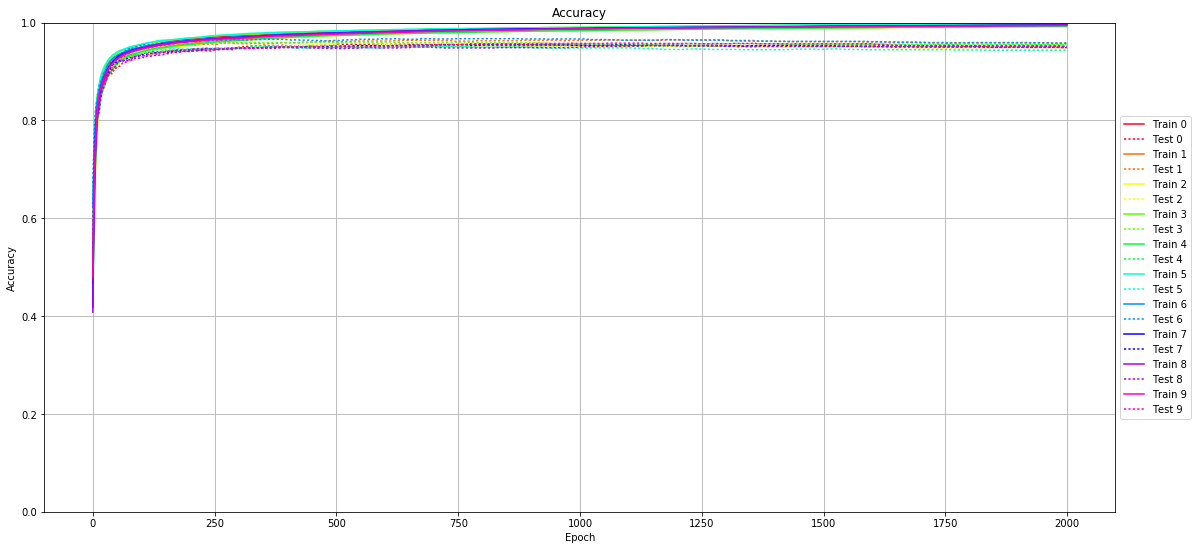

In [14]:
plot_acc(history)

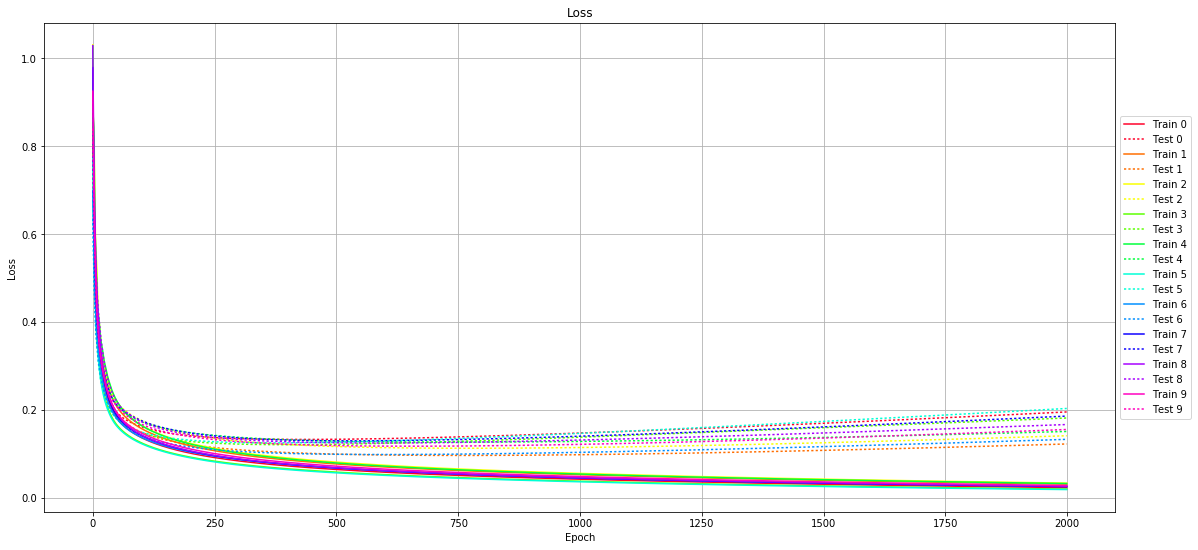

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


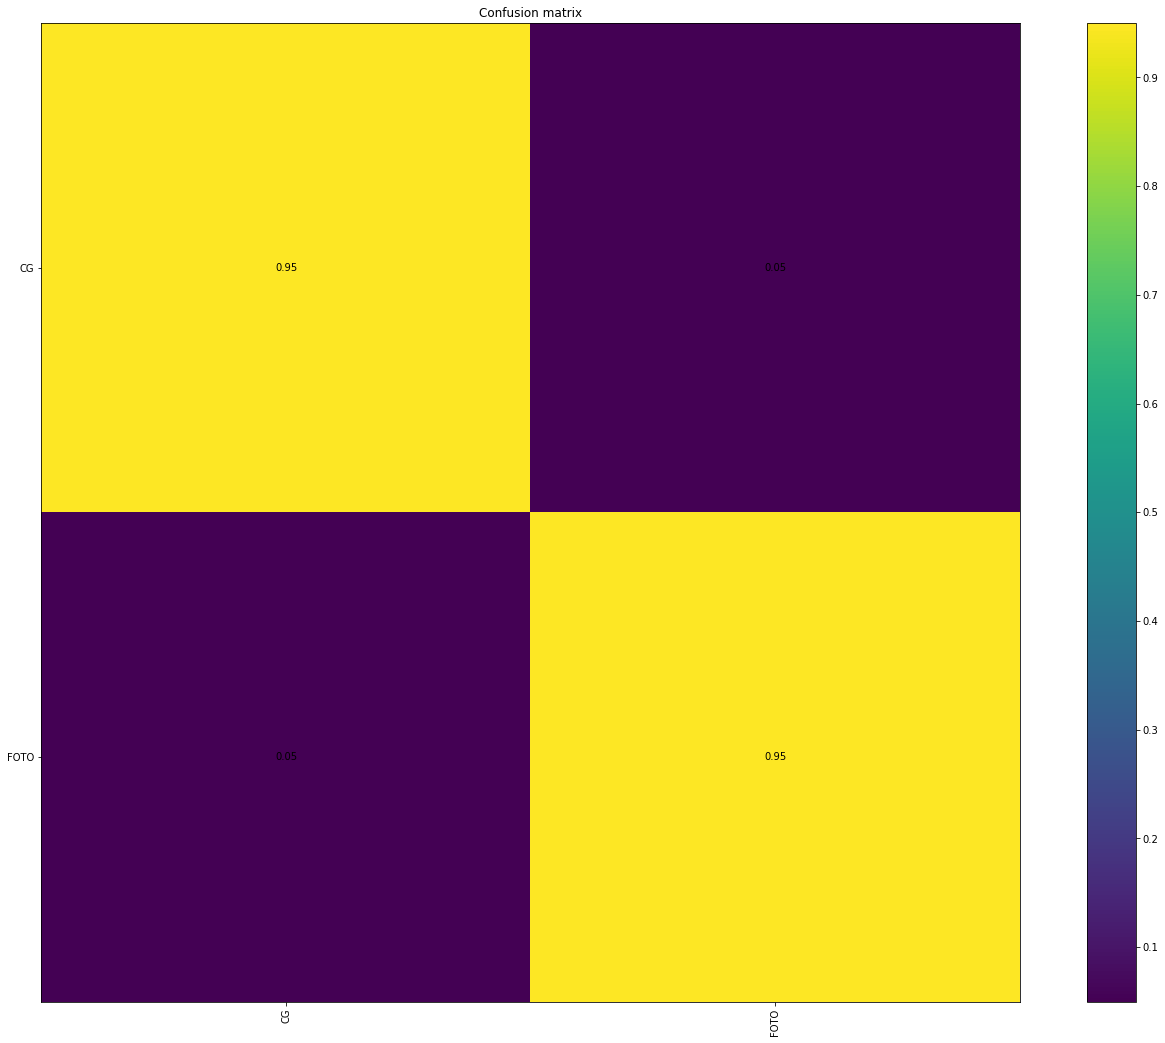

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()